In [1]:
!nvidia-smi

Wed Feb 28 12:59:49 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 545.23.08              Driver Version: 545.23.08    CUDA Version: 12.3     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 2080        On  | 00000000:01:00.0  On |                  N/A |
| 32%   30C    P8              20W / 215W |    532MiB /  8192MiB |     13%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import os
os.getcwd()

'/home/linh/projects/IConNet/notebooks'

In [4]:
os.chdir('..')

In [5]:
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "max_split_size_mb:512"
import gc
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import sys
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [6]:
import glob
import numpy as np
from tqdm import tqdm
import itertools
import matplotlib.pyplot as plt
import pandas as pd

# Scikit learn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import shuffle

import warnings
warnings.filterwarnings('ignore', category=FutureWarning)

In [11]:
data_dir = '../data/data_preprocessed/crema_d/preprocessed/'

In [12]:
sr = 16000

data_x = np.load(f'{data_dir}crema_d.audio16k.npy', allow_pickle=True)
data_y = np.load(f'{data_dir}crema_d.label_emotion.npy', allow_pickle=True)
classnames = np.load(f'{data_dir}crema_d.classnames.npy', allow_pickle=True)
print(data_x.shape)
print(data_y.shape)
np.unique(data_y)

(7438,)
(7438,)


array([0, 1, 2, 3, 4, 5], dtype=int16)

In [13]:
classnames

array(['NEU', 'HAP', 'SAD', 'ANG', 'FEA', 'DIS'], dtype='<U3')

In [14]:
labels = ['ANG', 'NEU', 'SAD', 'HAP']

def label_filter(idx):
    return classnames[idx] in labels

def label_to_index(idx):
    return labels.index(classnames[idx])
    
filtered_idx = [label_filter(idx) for idx in data_y]
data_x = data_x[filtered_idx]
data_y = [label_to_index(idx) for idx in data_y[filtered_idx]]
print(data_x.shape)

(4898,)


In [15]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(
    data_x, data_y, test_size=0.2, 
    random_state=42, stratify=data_y)
print("Train: %i" % len(x_train))
print("Test: %i" % len(x_test))

Train: 3918
Test: 980


In [16]:
train_set = list(zip(x_train, y_train))
test_set = list(zip(x_test, y_test))

In [46]:
def pad_sequence(batch):
    # Make all tensor in a batch the same length by padding with zeros
    batch = [item.t() for item in batch]
    batch = torch.nn.utils.rnn.pad_sequence(
        batch, batch_first=True, padding_value=0.).permute(0, 2, 1)
    return batch

def collate_fn(batch, max_duration_in_second=3, sample_rate=sr):
    tensors, targets = [], []

    # Gather in lists, and encode labels as indices
    for waveform, label in batch:
        if max_duration_in_second is not None:
            waveform = np.array(waveform, dtype=float).squeeze()
            length = len(waveform)
            max_length = sample_rate * max_duration_in_second
            offset = max(0, (length - max_length) // 2)
            waveform = waveform[offset: length-offset]
        tensors += [torch.tensor(waveform, dtype=torch.float32)[None,:]]
        targets += [torch.tensor(label, dtype=torch.long)]

    # Group the list of tensors into a batched tensor
    tensors = pad_sequence(tensors)
    targets = torch.stack(targets)
    return tensors, targets

batch_size = 16

if device == "cuda":
    num_workers = 1
    pin_memory = True
else:
    num_workers = 0
    pin_memory = False

train_loader = torch.utils.data.DataLoader(
    train_set,
    batch_size=batch_size,
    shuffle=True,
    collate_fn=collate_fn,
    num_workers=num_workers,
    pin_memory=pin_memory, 
    drop_last=True
)
test_loader = torch.utils.data.DataLoader(
    test_set,
    batch_size=batch_size,
    shuffle=False,
    drop_last=True,
    collate_fn=collate_fn,
    num_workers=num_workers,
    pin_memory=pin_memory
)

In [30]:
from IConNet.nn.model import M13

In [31]:
from omegaconf import OmegaConf as ocf

In [32]:
import traceback

In [49]:
model_config_path = 'config/model/m13ser.yaml'
model_config = ocf.load(model_config_path)
model_config

{'name': 'M13', 'description': 'FirConv with fftconv', 'fe': {'n_block': 2, 'n_channel': [198, 30], 'kernel_size': [511, 127], 'stride': [2, 4], 'window_k': [5, 9], 'mel_resolution': 3, 'residual_connection_type': 'stack', 'pooling': 'mean', 'filter_type': 'firwin', 'conv_mode': 'fftconv', 'norm_type': 'LocalResponseNorm'}, 'cls': {'n_block': 2, 'n_hidden_dim': [512, 512], 'norm_type': 'LayerNorm'}}

In [50]:
model = M13(config=model_config,
           n_input=1, n_output=len(labels))
model

M13(
  (fe_blocks): FeBlocks(
    (blocks): ModuleList(
      (0-1): 2 x FrontEndBlock(
        (block): ModuleDict(
          (layer): FirConvLayer(
            (conv_layer): ResidualConv1d(
              (pad_layer): PadForConv()
              (stride_layer): DownsampleLayer(
                (pad_right): PadForConv()
              )
              (norm_layer): CustomNormLayer(
                (layer): LocalResponseNorm(2, alpha=0.0001, beta=0.75, k=1.0)
              )
              (act): NLReLU()
            )
          )
          (downsample): ResidualConv1d(
            (pad_layer): PadForConv()
            (stride_layer): DownsampleLayer(
              (pad_right): PadForConv()
            )
            (norm_layer): CustomNormLayer(
              (layer): LocalResponseNorm(2, alpha=0.0001, beta=0.75, k=1.0)
            )
            (act): NLReLU()
          )
        )
      )
    )
  )
  (cls_head): Classifier(
    (blocks): ModuleList(
      (0): Sequential(
        (norm):

In [51]:
n_epoch = 10
train_losses = []
test_accuracy = []
optimizer = optim.RAdam(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.OneCycleLR(
    optimizer, max_lr=0.1,
    steps_per_epoch=len(train_loader), epochs=n_epoch)

In [52]:
train_loader_length = len(train_loader.dataset)
test_loader_length = len(test_loader.dataset)

def train(model, epoch, log_interval, 
          train_losses=train_losses):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        try:
            _mem_before = torch.cuda.memory_allocated()
            data = data.to(device)
            target = target.to(device)
            output = model(data)
            del data
            gc.collect()
            torch.cuda.empty_cache()
            loss = F.cross_entropy(output.squeeze(), target)
            _mem_during = torch.cuda.memory_allocated()
            del target
            gc.collect()
            torch.cuda.empty_cache()
            optimizer.zero_grad()
            loss.backward()
            nn.utils.clip_grad.clip_grad_norm_(
                model.parameters(), 1.0)
            optimizer.step()
            _mem_after = torch.cuda.memory_allocated()
            # print training stats
            if batch_idx % log_interval == 0:
                print(f"Train Epoch: {epoch} [{batch_idx * batch_size}/{train_loader_length} ({100. * batch_idx / len(train_loader):.0f}%)]\tLoss: {loss.item():.6f}")
                print(f'Mem before-during-after: {_mem_before} {_mem_during} {_mem_after}')
            # update progress bar
            pbar.update(pbar_update)
            # record loss
            train_losses.append(loss.item())
        except Exception as e:
            print(f'data: {data.shape} => output: {output.shape} | target: {target.shape}')
            traceback.print_exc()

@torch.no_grad
def test(model, epoch, test_loader=test_loader, device=device):
    model.eval()
    correct = 0
    total = 0
    for data, target in test_loader:
        total += len(target)
        data = data.to(device)
        target = target.to(device)
        output = model(data).squeeze()
        del data
        gc.collect()
        torch.cuda.empty_cache()
        probs = F.softmax(output, dim=-1)
        pred = probs.argmax(dim=-1)
        correct += pred.eq(target).sum().item()
        del target
        gc.collect()
        torch.cuda.empty_cache()
        pbar.update(pbar_update)
    acc = correct / test_loader_length
    print(f"\nTest Epoch: {epoch}\tAccuracy: {correct}/{total} ({100. * acc:.0f}%)\n")
    return acc

In [53]:
log_interval = 40
pbar_update = 1 / (len(train_loader) + len(test_loader))
model.to(device)
with tqdm(total=n_epoch) as pbar:
    for epoch in range(1, n_epoch + 1):
        train(model, epoch, log_interval, train_losses)
        acc = test(model, epoch)
        test_accuracy += [acc]
        scheduler.step()

  0%|                                 | 0.003278688524590164/10 [00:00<30:31, 183.24s/it]

Train Epoch: 1 [0/3918 (0%)]	Loss: 1.501312
Mem before-during-after: 13788672 4040270848 56999424


  1%|▍                                 | 0.13442622950819672/10 [00:16<19:06, 116.20s/it]

Train Epoch: 1 [640/3918 (16%)]	Loss: 1.422818
Mem before-during-after: 57881088 4055741440 57022976


  3%|▉                                 | 0.26557377049180286/10 [00:32<20:30, 126.36s/it]

Train Epoch: 1 [1280/3918 (33%)]	Loss: 1.211070
Mem before-during-after: 57022976 4053644288 57881088


  4%|█▍                                   | 0.39672131147541/10 [00:48<23:28, 146.67s/it]

Train Epoch: 1 [1920/3918 (49%)]	Loss: 1.083974
Mem before-during-after: 57698816 4056074240 57779712


  5%|█▊                                 | 0.5278688524590167/10 [01:04<18:31, 117.38s/it]

Train Epoch: 1 [2560/3918 (66%)]	Loss: 1.000385
Mem before-during-after: 57779712 4056576000 57779712


  7%|██▎                                | 0.6590163934426216/10 [01:19<21:18, 136.88s/it]

Train Epoch: 1 [3200/3918 (82%)]	Loss: 1.137436
Mem before-during-after: 57779712 3672547840 57603584


  8%|██▊                                | 0.7901639344262266/10 [01:36<20:40, 134.72s/it]

Train Epoch: 1 [3840/3918 (98%)]	Loss: 0.886049
Mem before-during-after: 58104320 4053668352 57779712


 10%|███▌                                | 0.9999999999999944/10 [01:50<09:48, 65.44s/it]


Test Epoch: 1	Accuracy: 500/976 (51%)



 10%|███▌                                | 1.0032786885245846/10 [01:50<11:51, 79.06s/it]

Train Epoch: 2 [0/3918 (0%)]	Loss: 0.923535
Mem before-during-after: 56961536 4053864448 57665024


 11%|███▉                               | 1.1344262295081895/10 [02:06<17:28, 118.27s/it]

Train Epoch: 2 [640/3918 (16%)]	Loss: 1.327605
Mem before-during-after: 57779712 4056576000 57779712


 13%|████▍                              | 1.2655737704917944/10 [02:22<16:50, 115.64s/it]

Train Epoch: 2 [1280/3918 (33%)]	Loss: 0.996149
Mem before-during-after: 58104320 4056343552 58104320


 14%|████▉                              | 1.3967213114753994/10 [02:37<19:43, 137.61s/it]

Train Epoch: 2 [1920/3918 (49%)]	Loss: 0.949744
Mem before-during-after: 57779712 4054478848 57779712


 15%|█████▎                             | 1.5278688524590043/10 [02:53<19:09, 135.73s/it]

Train Epoch: 2 [2560/3918 (66%)]	Loss: 1.178094
Mem before-during-after: 57206272 4055372800 57285120


 17%|█████▊                             | 1.6590163934426092/10 [03:08<15:47, 113.62s/it]

Train Epoch: 2 [3200/3918 (82%)]	Loss: 0.849142
Mem before-during-after: 57779712 4055717888 57779712


 18%|██████▎                            | 1.7901639344262141/10 [03:24<17:55, 131.04s/it]

Train Epoch: 2 [3840/3918 (98%)]	Loss: 1.126364
Mem before-during-after: 57779712 3846981120 57073152


 20%|███████▍                             | 1.999999999999982/10 [03:39<08:46, 65.87s/it]


Test Epoch: 2	Accuracy: 540/976 (55%)



 20%|███████▏                            | 2.0032786885245724/10 [03:39<10:30, 78.86s/it]

Train Epoch: 3 [0/3918 (0%)]	Loss: 1.112576
Mem before-during-after: 56961536 4053864448 57665024


 21%|███████▍                           | 2.1344262295081773/10 [03:55<15:38, 119.37s/it]

Train Epoch: 3 [640/3918 (16%)]	Loss: 1.135035
Mem before-during-after: 57779712 4056576000 57779712


 23%|████████▏                           | 2.265573770491782/10 [04:10<14:53, 115.55s/it]

Train Epoch: 3 [1280/3918 (33%)]	Loss: 1.171887
Mem before-during-after: 57779712 4027323904 56898048


 24%|████████▋                           | 2.396721311475387/10 [04:26<16:30, 130.34s/it]

Train Epoch: 3 [1920/3918 (49%)]	Loss: 1.088457
Mem before-during-after: 57362432 3928835584 56898048


 25%|█████████                           | 2.527868852458992/10 [04:42<16:31, 132.66s/it]

Train Epoch: 3 [2560/3918 (66%)]	Loss: 1.066855
Mem before-during-after: 56898048 4053971456 57779712


 27%|█████████▌                          | 2.659016393442597/10 [04:58<15:40, 128.13s/it]

Train Epoch: 3 [3200/3918 (82%)]	Loss: 0.986915
Mem before-during-after: 57286656 4053732352 57843712


 28%|██████████                          | 2.790163934426202/10 [05:13<14:04, 117.12s/it]

Train Epoch: 3 [3840/3918 (98%)]	Loss: 0.780102
Mem before-during-after: 57779712 4055717888 57779712


 30%|███████████▍                          | 2.99999999999997/10 [05:28<07:42, 66.08s/it]


Test Epoch: 3	Accuracy: 535/976 (55%)



 30%|███████████▍                          | 3.00327868852456/10 [05:28<09:17, 79.69s/it]

Train Epoch: 4 [0/3918 (0%)]	Loss: 0.830926
Mem before-during-after: 56961536 4053864448 57665024


 31%|███████████▎                        | 3.134426229508165/10 [05:44<13:53, 121.40s/it]

Train Epoch: 4 [640/3918 (16%)]	Loss: 1.020939
Mem before-during-after: 57779712 4054478848 57779712


 33%|████████████                         | 3.26557377049177/10 [06:00<13:53, 123.84s/it]

Train Epoch: 4 [1280/3918 (33%)]	Loss: 1.186559
Mem before-during-after: 58104320 4055765504 57779712


 34%|███████████▉                       | 3.3967213114753747/10 [06:16<12:47, 116.18s/it]

Train Epoch: 4 [1920/3918 (49%)]	Loss: 0.855084
Mem before-during-after: 57779712 4056576000 57779712


 35%|████████████▎                      | 3.5278688524589796/10 [06:31<13:51, 128.42s/it]

Train Epoch: 4 [2560/3918 (66%)]	Loss: 0.625182
Mem before-during-after: 57222656 4053921792 57779712


 37%|████████████▊                      | 3.6590163934425846/10 [06:47<14:42, 139.20s/it]

Train Epoch: 4 [3200/3918 (82%)]	Loss: 1.030046
Mem before-during-after: 57206272 3929405952 56921600


 38%|█████████████▎                     | 3.7901639344261895/10 [07:02<13:03, 126.24s/it]

Train Epoch: 4 [3840/3918 (98%)]	Loss: 1.177823
Mem before-during-after: 57628160 4056369664 57222656


 40%|██████████████▍                     | 3.9999999999999574/10 [07:17<06:26, 64.42s/it]


Test Epoch: 4	Accuracy: 518/976 (53%)



 40%|██████████████▍                     | 4.0032786885245475/10 [07:17<07:41, 77.03s/it]

Train Epoch: 5 [0/3918 (0%)]	Loss: 1.400368
Mem before-during-after: 56961536 4053864448 57665024


 41%|██████████████▉                     | 4.134426229508152/10 [07:33<12:18, 125.85s/it]

Train Epoch: 5 [640/3918 (16%)]	Loss: 0.707456
Mem before-during-after: 57779712 4056576000 57779712


 43%|███████████████▎                    | 4.265573770491757/10 [07:49<10:49, 113.24s/it]

Train Epoch: 5 [1280/3918 (33%)]	Loss: 1.527576
Mem before-during-after: 57779712 3997049856 56898048


 44%|███████████████▊                    | 4.396721311475362/10 [08:05<11:26, 122.53s/it]

Train Epoch: 5 [1920/3918 (49%)]	Loss: 1.217026
Mem before-during-after: 57779712 3805459968 57206272


 45%|████████████████▎                   | 4.527868852458967/10 [08:21<11:42, 128.29s/it]

Train Epoch: 5 [2560/3918 (66%)]	Loss: 1.221769
Mem before-during-after: 56898048 4056926720 57779712


 47%|████████████████▊                   | 4.659016393442572/10 [08:36<11:34, 129.99s/it]

Train Epoch: 5 [3200/3918 (82%)]	Loss: 0.927936
Mem before-during-after: 57779712 4054478848 57779712


 48%|█████████████████▏                  | 4.790163934426177/10 [08:51<10:00, 115.18s/it]

Train Epoch: 5 [3840/3918 (98%)]	Loss: 1.426465
Mem before-during-after: 57779712 4056576000 57779712


 50%|██████████████████▍                  | 4.999999999999945/10 [09:06<05:19, 63.99s/it]


Test Epoch: 5	Accuracy: 544/976 (56%)



 50%|██████████████████▌                  | 5.003278688524535/10 [09:06<06:33, 78.82s/it]

Train Epoch: 6 [0/3918 (0%)]	Loss: 0.854525
Mem before-during-after: 56961536 4053864448 57665024


 51%|██████████████████▉                  | 5.13442622950814/10 [09:22<10:46, 132.97s/it]

Train Epoch: 6 [640/3918 (16%)]	Loss: 1.453021
Mem before-during-after: 57842176 4056521728 58661376


 53%|██████████████████▉                 | 5.265573770491745/10 [09:38<10:32, 133.65s/it]

Train Epoch: 6 [1280/3918 (33%)]	Loss: 1.445552
Mem before-during-after: 57073152 4055983104 57264640


 54%|███████████████████▉                 | 5.39672131147535/10 [09:53<09:28, 123.42s/it]

Train Epoch: 6 [1920/3918 (49%)]	Loss: 0.977054
Mem before-during-after: 57779712 4054803456 58104320


 55%|███████████████████▉                | 5.527868852458955/10 [10:09<09:41, 129.95s/it]

Train Epoch: 6 [2560/3918 (66%)]	Loss: 0.752432
Mem before-during-after: 57222656 3846020608 57073152


 57%|████████████████████▉                | 5.65901639344256/10 [10:24<09:10, 126.78s/it]

Train Epoch: 6 [3200/3918 (82%)]	Loss: 0.929725
Mem before-during-after: 58104320 4056090112 58104320


 58%|████████████████████▊               | 5.790163934426165/10 [10:39<08:07, 115.89s/it]

Train Epoch: 6 [3840/3918 (98%)]	Loss: 1.086356
Mem before-during-after: 57779712 4056576000 57779712


 60%|█████████████████████▌              | 5.9999999999999325/10 [10:54<04:20, 65.23s/it]


Test Epoch: 6	Accuracy: 514/976 (52%)



 60%|██████████████████████▏              | 6.003278688524523/10 [10:55<05:17, 79.55s/it]

Train Epoch: 7 [0/3918 (0%)]	Loss: 1.343410
Mem before-during-after: 56961536 3971602432 56898048


 61%|█████████████████████▍             | 6.1344262295081275/10 [11:11<07:54, 122.79s/it]

Train Epoch: 7 [640/3918 (16%)]	Loss: 0.685488
Mem before-during-after: 57779712 4054478848 57779712


 63%|█████████████████████▉             | 6.2655737704917325/10 [11:26<07:12, 115.71s/it]

Train Epoch: 7 [1280/3918 (33%)]	Loss: 0.882086
Mem before-during-after: 57022976 4053644288 57881088


 64%|███████████████████████             | 6.396721311475337/10 [11:42<07:27, 124.06s/it]

Train Epoch: 7 [1920/3918 (49%)]	Loss: 0.771841
Mem before-during-after: 58104320 4054246400 58104320


 65%|███████████████████████▌            | 6.527868852458942/10 [11:58<07:39, 132.34s/it]

Train Epoch: 7 [2560/3918 (66%)]	Loss: 1.049775
Mem before-during-after: 58104320 4055789056 58661376


 67%|███████████████████████▉            | 6.659016393442547/10 [12:13<06:26, 115.71s/it]

Train Epoch: 7 [3200/3918 (82%)]	Loss: 0.903330
Mem before-during-after: 58104320 4055533056 58104320


 68%|████████████████████████▍           | 6.790163934426152/10 [12:29<06:13, 116.24s/it]

Train Epoch: 7 [3840/3918 (98%)]	Loss: 0.961029
Mem before-during-after: 57779712 3997049856 56898048


 70%|██████████████████████████▌           | 6.99999999999992/10 [12:43<03:19, 66.55s/it]


Test Epoch: 7	Accuracy: 530/976 (54%)



 70%|██████████████████████████▌           | 7.00327868852451/10 [12:44<03:54, 78.22s/it]

Train Epoch: 8 [0/3918 (0%)]	Loss: 0.902443
Mem before-during-after: 56890880 3971588608 57726976


 71%|█████████████████████████▋          | 7.134426229508115/10 [12:59<05:33, 116.52s/it]

Train Epoch: 8 [640/3918 (16%)]	Loss: 0.932519
Mem before-during-after: 57779712 4055717888 57779712


 73%|██████████████████████████▉          | 7.26557377049172/10 [13:15<06:12, 136.23s/it]

Train Epoch: 8 [1280/3918 (33%)]	Loss: 1.002684
Mem before-during-after: 56940544 4055055872 58006016


 74%|██████████████████████████▋         | 7.396721311475325/10 [13:30<05:13, 120.26s/it]

Train Epoch: 8 [1920/3918 (49%)]	Loss: 1.305844
Mem before-during-after: 57779712 3722689536 57470976


 75%|███████████████████████████▊         | 7.52786885245893/10 [13:47<05:25, 131.67s/it]

Train Epoch: 8 [2560/3918 (66%)]	Loss: 0.766216
Mem before-during-after: 56927744 4055407616 57246208


 77%|███████████████████████████▌        | 7.659016393442535/10 [14:02<04:28, 114.71s/it]

Train Epoch: 8 [3200/3918 (82%)]	Loss: 0.724698
Mem before-during-after: 57779712 4056576000 57779712


 78%|████████████████████████████▊        | 7.79016393442614/10 [14:18<04:37, 125.61s/it]

Train Epoch: 8 [3840/3918 (98%)]	Loss: 0.931646
Mem before-during-after: 57779712 4028156928 57425408


 80%|█████████████████████████████▌       | 7.999999999999908/10 [14:32<02:11, 65.67s/it]


Test Epoch: 8	Accuracy: 547/976 (56%)



 80%|█████████████████████████████▌       | 8.003278688524498/10 [14:32<02:36, 78.51s/it]

Train Epoch: 9 [0/3918 (0%)]	Loss: 1.065207
Mem before-during-after: 56961536 3889663488 56898048


 81%|█████████████████████████████▎      | 8.134426229508103/10 [14:48<03:35, 115.67s/it]

Train Epoch: 9 [640/3918 (16%)]	Loss: 1.157910
Mem before-during-after: 57779712 4056576000 57779712


 83%|█████████████████████████████▊      | 8.265573770491708/10 [15:03<03:23, 117.49s/it]

Train Epoch: 9 [1280/3918 (33%)]	Loss: 1.127122
Mem before-during-after: 58104320 4055765504 57779712


 84%|██████████████████████████████▏     | 8.396721311475313/10 [15:19<03:31, 131.82s/it]

Train Epoch: 9 [1920/3918 (49%)]	Loss: 1.053845
Mem before-during-after: 56898048 4055750144 57842176


 85%|██████████████████████████████▋     | 8.527868852458917/10 [15:35<02:53, 117.79s/it]

Train Epoch: 9 [2560/3918 (66%)]	Loss: 0.853933
Mem before-during-after: 57779712 4056576000 57779712


 87%|███████████████████████████████▏    | 8.659016393442522/10 [15:50<02:33, 114.83s/it]

Train Epoch: 9 [3200/3918 (82%)]	Loss: 1.455150
Mem before-during-after: 57779712 4056018944 57222656


 88%|███████████████████████████████▋    | 8.790163934426127/10 [16:06<02:19, 114.92s/it]

Train Epoch: 9 [3840/3918 (98%)]	Loss: 1.020258
Mem before-during-after: 57779712 4056576000 57779712


 90%|█████████████████████████████████▎   | 8.999999999999895/10 [16:20<01:06, 66.05s/it]


Test Epoch: 9	Accuracy: 473/976 (48%)



 90%|█████████████████████████████████▎   | 9.003278688524485/10 [16:21<01:18, 78.68s/it]

Train Epoch: 10 [0/3918 (0%)]	Loss: 0.766159
Mem before-during-after: 56890880 4053852672 57660928


 91%|█████████████████████████████████▊   | 9.13442622950809/10 [16:37<01:40, 116.00s/it]

Train Epoch: 10 [640/3918 (16%)]	Loss: 0.702985
Mem before-during-after: 58104320 4056090112 58104320


 93%|█████████████████████████████████▎  | 9.265573770491695/10 [16:52<01:36, 131.89s/it]

Train Epoch: 10 [1280/3918 (33%)]	Loss: 0.730976
Mem before-during-after: 57073152 4054829568 57779712


 94%|███████████████████████████████████▋  | 9.3967213114753/10 [17:08<01:11, 119.17s/it]

Train Epoch: 10 [1920/3918 (49%)]	Loss: 0.715437
Mem before-during-after: 58104320 4055789056 58661376


 95%|██████████████████████████████████▎ | 9.527868852458905/10 [17:25<01:06, 140.15s/it]

Train Epoch: 10 [2560/3918 (66%)]	Loss: 0.906553
Mem before-during-after: 57779712 4054478848 57779712


 97%|███████████████████████████████████▋ | 9.65901639344251/10 [17:41<00:47, 138.14s/it]

Train Epoch: 10 [3200/3918 (82%)]	Loss: 0.841927
Mem before-during-after: 57779712 4053921792 57222656


 98%|███████████████████████████████████▏| 9.790163934426115/10 [17:57<00:25, 121.83s/it]

Train Epoch: 10 [3840/3918 (98%)]	Loss: 0.955136
Mem before-during-after: 57779712 4056576000 57779712


100%|███████████████████████████████████▉| 9.999999999999883/10 [18:12<00:00, 109.23s/it]


Test Epoch: 10	Accuracy: 565/976 (58%)



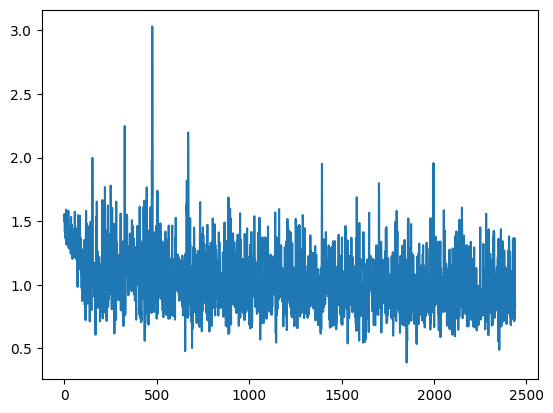

In [54]:
plt.plot(train_losses)

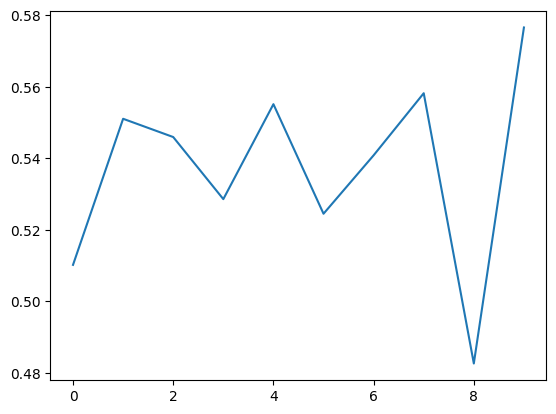

In [55]:
plt.plot(test_accuracy)

In [57]:
from torchmetrics.classification import (
    MulticlassAccuracy, MulticlassPrecision, 
    MulticlassRecall, MulticlassF1Score, 
    MulticlassConfusionMatrix,
    MulticlassAUROC
)
from torchmetrics import MetricCollection
from pprint import pprint

@torch.no_grad
def report_metrics(model, labels=labels, 
                   test_loader=test_loader, device=device):
    n = len(labels)
    metrics = MetricCollection({
        'acc_unweighted': MulticlassAccuracy(num_classes=n, average='macro'), 
        'acc_weighted': MulticlassAccuracy(num_classes=n, average='weighted'), 
        
        'f1s_unweighted': MulticlassF1Score(num_classes=n, average='macro'),  
        'f1s_weighted': MulticlassF1Score(num_classes=n, average='weighted'),  

        'acc_weighted': MulticlassAccuracy(num_classes=n, average='weighted'), 
        'uar': MulticlassRecall(num_classes=n, average='macro'), 
        'wap': MulticlassPrecision(num_classes=n, average='weighted'),
        'rocauc': MulticlassAUROC(num_classes=n, average='macro', thresholds=None),    
        'f1s_detail': MulticlassF1Score(num_classes=n, average=None),  
        'acc_detail': MulticlassAccuracy(num_classes=n, average=None), 
        'precision_detail': MulticlassPrecision(num_classes=n, average=None),
        'recall_detail': MulticlassRecall(num_classes=n, average=None), 
        'rocauc_detail': MulticlassAUROC(num_classes=n, average=None, thresholds=None),
    }).to(device)
    confusion_matrix = MulticlassConfusionMatrix(num_classes=n).to(device)
    model.eval()
    correct = 0
    total = 0
    for data, target in test_loader:
        total += len(target)
        
        data = data.to(device)
        target = target.to(device)
        output = model(data).squeeze()
        del data
        gc.collect()
        torch.cuda.empty_cache()
        probs = F.softmax(output, dim=-1)
        pred = probs.argmax(dim=-1)
        correct += pred.eq(target).sum().item()
        
        metrics.update(probs, target)
        confusion_matrix.update(pred, target)
        
        del target
        gc.collect()
        torch.cuda.empty_cache()
        pbar.update(pbar_update)
    print(f'Correct: {correct}/{total} ({correct/total:.4f})')
    return metrics, confusion_matrix

In [58]:
metrics, confusion_matrix = report_metrics(
    model, labels=labels, device=device)
pprint(metrics.compute())
confusion_matrix.compute()

Correct: 565/976 (0.5789)
{'acc_detail': tensor([0.8031, 0.4676, 0.6772, 0.3492], device='cuda:0'),
 'acc_unweighted': tensor(0.5743, device='cuda:0'),
 'acc_weighted': tensor(0.5789, device='cuda:0'),
 'f1s_detail': tensor([0.7234, 0.4665, 0.6978, 0.3810], device='cuda:0'),
 'f1s_unweighted': tensor(0.5672, device='cuda:0'),
 'f1s_weighted': tensor(0.5715, device='cuda:0'),
 'precision_detail': tensor([0.6581, 0.4654, 0.7197, 0.4190], device='cuda:0'),
 'recall_detail': tensor([0.8031, 0.4676, 0.6772, 0.3492], device='cuda:0'),
 'rocauc': tensor(0.8350, device='cuda:0'),
 'rocauc_detail': tensor([0.9051, 0.8039, 0.8954, 0.7358], device='cuda:0'),
 'uar': tensor(0.5743, device='cuda:0'),
 'wap': tensor(0.5698, device='cuda:0')}


tensor([[204,  10,   5,  35],
        [  2, 101,  46,  67],
        [  6,  56, 172,  20],
        [ 98,  50,  16,  88]], device='cuda:0')

In [59]:
model_path = '../models_cremad4/cremad_label4_m13ser_10epochs.pt' 
torch.save(model.state_dict(), model_path)

In [60]:
n_epoch = 10
n_epoch2 = 50
# train_losses = []
# test_accuracy = []
best_accuracy = test_accuracy[-1]
best_epoch = n_epoch
model_path_prefix = '../models_cremad4/cremad_label4_m13ser_best_'

optimizer = optim.RAdam(model.parameters(), lr=0.00002)
scheduler = optim.lr_scheduler.OneCycleLR(
    optimizer, max_lr=0.01,
    steps_per_epoch=len(train_loader), epochs=n_epoch2)
log_interval = 40
pbar_update = 1 / (len(train_loader) + len(test_loader))
# model.to(device)
with tqdm(total=n_epoch2) as pbar:
    for epoch in range(1+n_epoch, n_epoch2 + n_epoch + 1):
        train(model, epoch, log_interval, train_losses)
        acc = test(model, epoch)
        test_accuracy += [acc]
        if acc > best_accuracy:
            best_accuracy = acc
            best_epoch = epoch
            bmodel_path = f'{model_path_prefix}{epoch}epoch.pt'
            torch.save(model.state_dict(), bmodel_path)
            print(f'saved model: {bmodel_path}')
        scheduler.step()

  0%|                               | 0.003278688524590164/50 [00:00<1:40:16, 120.33s/it]

Train Epoch: 11 [0/3918 (0%)]	Loss: 1.006902
Mem before-during-after: 53368320 4050330112 57747968


  0%|                                | 0.13442622950819672/50 [00:16<1:45:47, 127.29s/it]

Train Epoch: 11 [640/3918 (16%)]	Loss: 0.848278
Mem before-during-after: 57251328 4055017984 57890304


  1%|▏                               | 0.26557377049180286/50 [00:32<1:48:36, 131.03s/it]

Train Epoch: 11 [1280/3918 (33%)]	Loss: 1.053002
Mem before-during-after: 57866752 4056663040 57866752


  1%|▎                                  | 0.39672131147541/50 [00:49<1:49:27, 132.39s/it]

Train Epoch: 11 [1920/3918 (49%)]	Loss: 0.798326
Mem before-during-after: 57309696 4054021120 57086464


  1%|▎                                | 0.5278688524590167/50 [01:04<1:44:15, 126.44s/it]

Train Epoch: 11 [2560/3918 (66%)]	Loss: 0.783459
Mem before-during-after: 58170880 4056663040 57866752


  1%|▍                                | 0.6590163934426216/50 [01:20<1:38:51, 120.21s/it]

Train Epoch: 11 [3200/3918 (82%)]	Loss: 0.659691
Mem before-during-after: 57866752 4056663040 57866752


  2%|▌                                | 0.7901639344262266/50 [01:37<1:59:03, 145.17s/it]

Train Epoch: 11 [3840/3918 (98%)]	Loss: 0.678741
Mem before-during-after: 58191360 4053198336 57309696


  2%|▋                                   | 0.9999999999999944/50 [01:53<55:06, 67.47s/it]


Test Epoch: 11	Accuracy: 583/976 (59%)

saved model: ../models_cremad4/cremad_label4_m13ser_best_11epoch.pt


  2%|▋                                 | 1.0032786885245846/50 [01:53<1:06:40, 81.64s/it]

Train Epoch: 12 [0/3918 (0%)]	Loss: 0.972352
Mem before-during-after: 57048576 4053951488 57752064


  2%|▋                                | 1.1344262295081895/50 [02:09<1:38:33, 121.02s/it]

Train Epoch: 12 [640/3918 (16%)]	Loss: 1.004413
Mem before-during-after: 57866752 4054565888 57866752


  3%|▊                                | 1.2655737704917944/50 [02:25<1:36:41, 119.05s/it]

Train Epoch: 12 [1280/3918 (33%)]	Loss: 0.971245
Mem before-during-after: 57866752 4056663040 57866752


  3%|▉                                | 1.3967213114753994/50 [02:42<1:43:13, 127.44s/it]

Train Epoch: 12 [1920/3918 (49%)]	Loss: 0.992965
Mem before-during-after: 58191360 4055852544 57866752


  3%|█                                | 1.5278688524590043/50 [02:58<1:42:28, 126.85s/it]

Train Epoch: 12 [2560/3918 (66%)]	Loss: 0.852927
Mem before-during-after: 58191360 4053755392 57866752


  3%|█                                | 1.6590163934426092/50 [03:14<1:50:54, 137.65s/it]

Train Epoch: 12 [3200/3918 (82%)]	Loss: 1.041488
Mem before-during-after: 57866752 3992942592 56985088


  4%|█▏                               | 1.7901639344262141/50 [03:29<1:45:16, 131.01s/it]

Train Epoch: 12 [3840/3918 (98%)]	Loss: 0.829527
Mem before-during-after: 57929216 4055727104 57866752


  4%|█▍                                   | 1.999999999999982/50 [03:45<54:06, 67.64s/it]


Test Epoch: 12	Accuracy: 576/976 (59%)



  4%|█▎                                | 2.0032786885245724/50 [03:45<1:05:14, 81.56s/it]

Train Epoch: 13 [0/3918 (0%)]	Loss: 1.151106
Mem before-during-after: 57048576 4053951488 57752064


  4%|█▍                               | 2.1344262295081773/50 [04:01<1:41:30, 127.24s/it]

Train Epoch: 13 [640/3918 (16%)]	Loss: 1.068036
Mem before-during-after: 57309696 4055852544 57866752


  5%|█▌                                | 2.265573770491782/50 [04:17<1:37:34, 122.65s/it]

Train Epoch: 13 [1280/3918 (33%)]	Loss: 0.926134
Mem before-during-after: 57866752 3846478336 57160192


  5%|█▋                                | 2.396721311475387/50 [04:35<1:44:16, 131.43s/it]

Train Epoch: 13 [1920/3918 (49%)]	Loss: 1.030922
Mem before-during-after: 57866752 4056105984 57309696


  5%|█▋                                | 2.527868852458992/50 [04:51<1:32:30, 116.93s/it]

Train Epoch: 13 [2560/3918 (66%)]	Loss: 0.679653
Mem before-during-after: 57866752 4056663040 57866752


  5%|█▊                                | 2.659016393442597/50 [05:06<1:32:09, 116.81s/it]

Train Epoch: 13 [3200/3918 (82%)]	Loss: 0.842354
Mem before-during-after: 57866752 4056663040 57866752


  6%|█▉                                | 2.790163934426202/50 [05:22<1:33:55, 119.36s/it]

Train Epoch: 13 [3840/3918 (98%)]	Loss: 0.585303
Mem before-during-after: 57866752 4054565888 57866752


  6%|██▎                                   | 2.99999999999997/50 [05:37<53:03, 67.73s/it]


Test Epoch: 13	Accuracy: 579/976 (59%)



  6%|██▏                                 | 3.00327868852456/50 [05:38<1:03:38, 81.26s/it]

Train Epoch: 14 [0/3918 (0%)]	Loss: 1.057393
Mem before-during-after: 56977920 4053939712 57747968


  6%|██▏                               | 3.134426229508165/50 [05:53<1:31:15, 116.84s/it]

Train Epoch: 14 [640/3918 (16%)]	Loss: 1.002569
Mem before-during-after: 57866752 4056663040 57866752


  7%|██▎                                | 3.26557377049177/50 [06:09<1:39:53, 128.26s/it]

Train Epoch: 14 [1280/3918 (33%)]	Loss: 0.709084
Mem before-during-after: 57027072 4054858752 57733632


  7%|██▏                              | 3.3967213114753747/50 [06:25<1:41:36, 130.82s/it]

Train Epoch: 14 [1920/3918 (49%)]	Loss: 1.148150
Mem before-during-after: 57219584 4054985728 57866752


  7%|██▎                              | 3.5278688524589796/50 [06:41<1:35:25, 123.21s/it]

Train Epoch: 14 [2560/3918 (66%)]	Loss: 0.945112
Mem before-during-after: 57866752 4054565888 57866752


  7%|██▍                              | 3.6590163934425846/50 [06:57<1:34:03, 121.79s/it]

Train Epoch: 14 [3200/3918 (82%)]	Loss: 0.960807
Mem before-during-after: 57866752 4054565888 57866752


  8%|██▌                              | 3.7901639344261895/50 [07:14<1:32:02, 119.50s/it]

Train Epoch: 14 [3840/3918 (98%)]	Loss: 0.768705
Mem before-during-after: 57866752 4056663040 57866752


  8%|██▉                                 | 3.9999999999999574/50 [07:29<52:48, 68.88s/it]


Test Epoch: 14	Accuracy: 586/976 (60%)

saved model: ../models_cremad4/cremad_label4_m13ser_best_14epoch.pt


  8%|██▋                               | 4.0032786885245475/50 [07:29<1:03:22, 82.67s/it]

Train Epoch: 15 [0/3918 (0%)]	Loss: 0.768614
Mem before-during-after: 57048576 4053951488 57752064


  8%|██▊                               | 4.134426229508152/50 [07:45<1:41:14, 132.45s/it]

Train Epoch: 15 [640/3918 (16%)]	Loss: 1.202153
Mem before-during-after: 57866752 4054565888 57866752


  9%|██▉                               | 4.265573770491757/50 [08:01<1:39:09, 130.08s/it]

Train Epoch: 15 [1280/3918 (33%)]	Loss: 0.943896
Mem before-during-after: 57866752 4054565888 57866752


  9%|██▉                               | 4.396721311475362/50 [08:17<1:40:11, 131.82s/it]

Train Epoch: 15 [1920/3918 (49%)]	Loss: 1.018239
Mem before-during-after: 57309696 4054008832 57866752


  9%|███                               | 4.527868852458967/50 [08:33<1:41:31, 133.96s/it]

Train Epoch: 15 [2560/3918 (66%)]	Loss: 0.587624
Mem before-during-after: 57309696 4054008832 57866752


  9%|███▏                              | 4.659016393442572/50 [08:49<1:27:51, 116.26s/it]

Train Epoch: 15 [3200/3918 (82%)]	Loss: 1.159293
Mem before-during-after: 57890304 3995206656 57008640


 10%|███▎                              | 4.790163934426177/50 [09:05<1:31:12, 121.04s/it]

Train Epoch: 15 [3840/3918 (98%)]	Loss: 0.868367
Mem before-during-after: 57175040 4054141952 57094656


 10%|███▋                                 | 4.999999999999945/50 [09:19<50:25, 67.23s/it]


Test Epoch: 15	Accuracy: 588/976 (60%)

saved model: ../models_cremad4/cremad_label4_m13ser_best_15epoch.pt


 10%|███▌                               | 5.003278688524535/50 [09:20<1:00:35, 80.78s/it]

Train Epoch: 16 [0/3918 (0%)]	Loss: 0.600050
Mem before-during-after: 57048576 4053951488 57752064


 10%|███▌                               | 5.13442622950814/50 [09:36<1:27:42, 117.29s/it]

Train Epoch: 16 [640/3918 (16%)]	Loss: 0.846142
Mem before-during-after: 57866752 4056663040 57866752


 11%|███▌                              | 5.265573770491745/50 [09:51<1:28:46, 119.07s/it]

Train Epoch: 16 [1280/3918 (33%)]	Loss: 0.766289
Mem before-during-after: 57866752 4054008832 57309696


 11%|███▊                               | 5.39672131147535/50 [10:07<1:29:00, 119.74s/it]

Train Epoch: 16 [1920/3918 (49%)]	Loss: 0.866439
Mem before-during-after: 57890304 4054589440 57890304


 11%|███▊                              | 5.527868852458955/50 [10:23<1:44:03, 140.38s/it]

Train Epoch: 16 [2560/3918 (66%)]	Loss: 0.963715
Mem before-during-after: 57153024 4054994432 57866752


 11%|███▉                               | 5.65901639344256/50 [10:39<1:28:11, 119.34s/it]

Train Epoch: 16 [3200/3918 (82%)]	Loss: 0.706800
Mem before-during-after: 57309696 4054008832 57866752


 12%|███▉                              | 5.790163934426165/50 [10:55<1:26:53, 117.93s/it]

Train Epoch: 16 [3840/3918 (98%)]	Loss: 0.820957
Mem before-during-after: 57309696 4056105984 57866752


 12%|████▎                               | 5.9999999999999325/50 [11:10<49:31, 67.55s/it]


Test Epoch: 16	Accuracy: 590/976 (60%)

saved model: ../models_cremad4/cremad_label4_m13ser_best_16epoch.pt


 12%|████▏                              | 6.003278688524523/50 [11:11<1:02:39, 85.45s/it]

Train Epoch: 17 [0/3918 (0%)]	Loss: 0.885061
Mem before-during-after: 57048576 4053951488 57752064


 12%|████                             | 6.1344262295081275/50 [11:27<1:28:30, 121.07s/it]

Train Epoch: 17 [640/3918 (16%)]	Loss: 1.020494
Mem before-during-after: 57866752 4056663040 57866752


 13%|████▏                            | 6.2655737704917325/50 [11:43<1:43:33, 142.08s/it]

Train Epoch: 17 [1280/3918 (33%)]	Loss: 1.089449
Mem before-during-after: 57634304 4053522944 57634304


 13%|████▎                             | 6.396721311475337/50 [12:01<1:29:43, 123.47s/it]

Train Epoch: 17 [1920/3918 (49%)]	Loss: 0.830076
Mem before-during-after: 58748416 4056663040 57866752


 13%|████▍                             | 6.527868852458942/50 [12:17<1:25:04, 117.42s/it]

Train Epoch: 17 [2560/3918 (66%)]	Loss: 0.654442
Mem before-during-after: 57866752 4055804928 57866752


 13%|████▌                             | 6.659016393442547/50 [12:34<1:36:03, 132.98s/it]

Train Epoch: 17 [3200/3918 (82%)]	Loss: 1.011886
Mem before-during-after: 57866752 4053707776 57866752


 14%|████▌                             | 6.790163934426152/50 [12:50<1:27:11, 121.08s/it]

Train Epoch: 17 [3840/3918 (98%)]	Loss: 0.724291
Mem before-during-after: 58191360 4055876096 58748416


 14%|█████▎                                | 6.99999999999992/50 [13:05<49:15, 68.74s/it]


Test Epoch: 17	Accuracy: 587/976 (60%)



 14%|█████▎                                | 7.00327868852451/50 [13:05<58:50, 82.12s/it]

Train Epoch: 18 [0/3918 (0%)]	Loss: 0.893995
Mem before-during-after: 57048576 4053951488 57752064


 14%|████▊                             | 7.134426229508115/50 [13:22<1:24:56, 118.89s/it]

Train Epoch: 18 [640/3918 (16%)]	Loss: 0.966296
Mem before-during-after: 57866752 4056663040 57866752


 15%|█████                              | 7.26557377049172/50 [13:38<1:32:52, 130.39s/it]

Train Epoch: 18 [1280/3918 (33%)]	Loss: 0.894107
Mem before-during-after: 57309696 4056105984 57866752


 15%|█████                             | 7.396721311475325/50 [13:54<1:25:28, 120.39s/it]

Train Epoch: 18 [1920/3918 (49%)]	Loss: 1.026936
Mem before-during-after: 57929216 3888452096 57027584


 15%|█████▎                             | 7.52786885245893/50 [14:10<1:25:02, 120.13s/it]

Train Epoch: 18 [2560/3918 (66%)]	Loss: 0.797160
Mem before-during-after: 57866752 4055804928 57866752


 15%|█████▏                            | 7.659016393442535/50 [14:25<1:22:22, 116.73s/it]

Train Epoch: 18 [3200/3918 (82%)]	Loss: 0.576236
Mem before-during-after: 57866752 4056663040 57866752


 16%|█████▍                             | 7.79016393442614/50 [14:41<1:22:27, 117.20s/it]

Train Epoch: 18 [3840/3918 (98%)]	Loss: 1.003764
Mem before-during-after: 57866752 4055804928 57866752


 16%|█████▉                               | 7.999999999999908/50 [14:56<47:20, 67.64s/it]


Test Epoch: 18	Accuracy: 607/976 (62%)

saved model: ../models_cremad4/cremad_label4_m13ser_best_18epoch.pt


 16%|█████▉                               | 8.003278688524498/50 [14:56<56:57, 81.38s/it]

Train Epoch: 19 [0/3918 (0%)]	Loss: 0.841673
Mem before-during-after: 56977920 4053868544 56985088


 16%|█████▌                            | 8.134426229508103/50 [15:12<1:25:31, 122.57s/it]

Train Epoch: 19 [640/3918 (16%)]	Loss: 0.889248
Mem before-during-after: 57309696 4055852544 57866752


 17%|█████▌                            | 8.265573770491708/50 [15:28<1:22:02, 117.94s/it]

Train Epoch: 19 [1280/3918 (33%)]	Loss: 0.744142
Mem before-during-after: 57866752 4055804928 57866752


 17%|█████▋                            | 8.396721311475313/50 [15:44<1:29:51, 129.59s/it]

Train Epoch: 19 [1920/3918 (49%)]	Loss: 0.974285
Mem before-during-after: 57866752 4054565888 57866752


 17%|█████▊                            | 8.527868852458917/50 [16:00<1:21:36, 118.07s/it]

Train Epoch: 19 [2560/3918 (66%)]	Loss: 1.160304
Mem before-during-after: 57866752 4056663040 57866752


 17%|█████▉                            | 8.659016393442522/50 [16:16<1:24:56, 123.27s/it]

Train Epoch: 19 [3200/3918 (82%)]	Loss: 1.013373
Mem before-during-after: 57309696 4056105984 57866752


 18%|█████▉                            | 8.790163934426127/50 [16:32<1:21:04, 118.04s/it]

Train Epoch: 19 [3840/3918 (98%)]	Loss: 0.819236
Mem before-during-after: 57866752 4056663040 57866752


 18%|██████▋                              | 8.999999999999895/50 [16:48<50:19, 73.66s/it]


Test Epoch: 19	Accuracy: 590/976 (60%)



 18%|██████▋                              | 9.003278688524485/50 [16:48<58:12, 85.20s/it]

Train Epoch: 20 [0/3918 (0%)]	Loss: 0.710873
Mem before-during-after: 56977920 3932011520 57077248


 18%|██████▍                            | 9.13442622950809/50 [17:04<1:20:26, 118.11s/it]

Train Epoch: 20 [640/3918 (16%)]	Loss: 0.907657
Mem before-during-after: 57309696 4056105984 57309696


 19%|██████▎                           | 9.265573770491695/50 [17:21<1:19:51, 117.63s/it]

Train Epoch: 20 [1280/3918 (33%)]	Loss: 0.801291
Mem before-during-after: 57866752 4056663040 57866752


 19%|██████▊                             | 9.3967213114753/50 [17:36<1:26:16, 127.50s/it]

Train Epoch: 20 [1920/3918 (49%)]	Loss: 1.079715
Mem before-during-after: 57203200 4056284160 57356800


 19%|██████▍                           | 9.527868852458905/50 [17:52<1:22:12, 121.89s/it]

Train Epoch: 20 [2560/3918 (66%)]	Loss: 0.874587
Mem before-during-after: 57866752 3847391232 57160192


 19%|██████▊                            | 9.65901639344251/50 [18:08<1:22:13, 122.29s/it]

Train Epoch: 20 [3200/3918 (82%)]	Loss: 0.980564
Mem before-during-after: 57634304 4055319040 58191360


 20%|██████▋                           | 9.790163934426115/50 [18:24<1:37:01, 144.77s/it]

Train Epoch: 20 [3840/3918 (98%)]	Loss: 0.751421
Mem before-during-after: 57113088 3929679360 57048064


 20%|███████▍                             | 9.999999999999883/50 [18:40<45:22, 68.05s/it]


Test Epoch: 20	Accuracy: 604/976 (62%)



 20%|███████▏                            | 10.003278688524473/50 [18:40<54:32, 81.83s/it]

Train Epoch: 21 [0/3918 (0%)]	Loss: 1.024748
Mem before-during-after: 57048576 4053951488 57752064


 20%|██████▋                          | 10.134426229508078/50 [18:56<1:18:57, 118.83s/it]

Train Epoch: 21 [640/3918 (16%)]	Loss: 0.746910
Mem before-during-after: 57866752 3945373184 57020928


 21%|██████▊                          | 10.265573770491683/50 [19:12<1:21:19, 122.81s/it]

Train Epoch: 21 [1280/3918 (33%)]	Loss: 0.639022
Mem before-during-after: 57866752 4056663040 57866752


 21%|██████▊                          | 10.396721311475288/50 [19:28<1:18:36, 119.09s/it]

Train Epoch: 21 [1920/3918 (49%)]	Loss: 1.024171
Mem before-during-after: 57866752 4056663040 57866752


 21%|██████▉                          | 10.527868852458893/50 [19:44<1:16:02, 115.58s/it]

Train Epoch: 21 [2560/3918 (66%)]	Loss: 0.633470
Mem before-during-after: 57866752 4055804928 57866752


 21%|███████                          | 10.659016393442498/50 [20:00<1:28:37, 135.15s/it]

Train Epoch: 21 [3200/3918 (82%)]	Loss: 0.818786
Mem before-during-after: 57866752 4054890496 58191360


 22%|███████                          | 10.790163934426102/50 [20:16<1:16:37, 117.24s/it]

Train Epoch: 21 [3840/3918 (98%)]	Loss: 0.789052
Mem before-during-after: 57929216 4054628352 57929216


 22%|████████▏                            | 10.99999999999987/50 [20:32<45:58, 70.74s/it]


Test Epoch: 21	Accuracy: 580/976 (59%)



 22%|████████▏                            | 11.00327868852446/50 [20:32<54:35, 83.99s/it]

Train Epoch: 22 [0/3918 (0%)]	Loss: 0.715890
Mem before-during-after: 56977920 4053939712 57747968


 22%|███████▎                         | 11.134426229508065/50 [20:48<1:27:51, 135.63s/it]

Train Epoch: 22 [640/3918 (16%)]	Loss: 0.996080
Mem before-during-after: 57866752 4056663040 57866752


 23%|███████▋                          | 11.26557377049167/50 [21:05<1:19:58, 123.87s/it]

Train Epoch: 22 [1280/3918 (33%)]	Loss: 0.819944
Mem before-during-after: 57866752 4056663040 57866752


 23%|███████▌                         | 11.396721311475275/50 [21:21<1:18:48, 122.50s/it]

Train Epoch: 22 [1920/3918 (49%)]	Loss: 1.036746
Mem before-during-after: 57866752 4054565888 57866752


 23%|███████▊                          | 11.52786885245888/50 [21:37<1:30:47, 141.59s/it]

Train Epoch: 22 [2560/3918 (66%)]	Loss: 0.769466
Mem before-during-after: 57022976 4055369728 57929216


 23%|███████▋                         | 11.659016393442485/50 [21:52<1:17:16, 120.92s/it]

Train Epoch: 22 [3200/3918 (82%)]	Loss: 0.736186
Mem before-during-after: 57866752 4056663040 57866752


 24%|████████                          | 11.79016393442609/50 [22:08<1:16:23, 119.94s/it]

Train Epoch: 22 [3840/3918 (98%)]	Loss: 1.238204
Mem before-during-after: 57866752 3887625216 57196032


 24%|████████▋                           | 11.999999999999858/50 [22:24<44:17, 69.92s/it]


Test Epoch: 22	Accuracy: 581/976 (59%)



 24%|████████▋                           | 12.003278688524448/50 [22:24<53:59, 85.25s/it]

Train Epoch: 23 [0/3918 (0%)]	Loss: 0.749072
Mem before-during-after: 57048576 4053951488 57752064


 24%|████████                         | 12.134426229508053/50 [22:41<1:18:53, 125.01s/it]

Train Epoch: 23 [640/3918 (16%)]	Loss: 0.709018
Mem before-during-after: 57890304 4054589440 57890304


 25%|████████                         | 12.265573770491658/50 [22:57<1:23:13, 132.34s/it]

Train Epoch: 23 [1280/3918 (33%)]	Loss: 0.468359
Mem before-during-after: 57866752 3927183872 56985088


 25%|████████▏                        | 12.396721311475263/50 [23:13<1:30:34, 144.51s/it]

Train Epoch: 23 [1920/3918 (49%)]	Loss: 0.929401
Mem before-during-after: 57866752 4054565888 57866752


 25%|████████▎                        | 12.527868852458868/50 [23:30<1:23:21, 133.46s/it]

Train Epoch: 23 [2560/3918 (66%)]	Loss: 0.902354
Mem before-during-after: 57047552 4056168448 58191360


 25%|████████▎                        | 12.659016393442473/50 [23:46<1:14:47, 120.18s/it]

Train Epoch: 23 [3200/3918 (82%)]	Loss: 0.891885
Mem before-during-after: 57866752 4056663040 57866752


 26%|████████▍                        | 12.790163934426078/50 [24:04<1:24:36, 136.44s/it]

Train Epoch: 23 [3840/3918 (98%)]	Loss: 0.734777
Mem before-during-after: 58748416 4056663040 57866752


 26%|█████████▎                          | 12.999999999999845/50 [24:20<43:46, 71.00s/it]


Test Epoch: 23	Accuracy: 600/976 (61%)



 26%|█████████▎                          | 13.003278688524436/50 [24:21<51:32, 83.59s/it]

Train Epoch: 24 [0/3918 (0%)]	Loss: 0.698596
Mem before-during-after: 57048576 4053951488 57752064


 26%|████████▉                         | 13.13442622950804/50 [24:37<1:20:45, 131.43s/it]

Train Epoch: 24 [640/3918 (16%)]	Loss: 0.936132
Mem before-during-after: 57309696 4056105984 57866752


 27%|████████▊                        | 13.265573770491645/50 [24:53<1:20:33, 131.57s/it]

Train Epoch: 24 [1280/3918 (33%)]	Loss: 0.938962
Mem before-during-after: 57866752 4056028160 57309696


 27%|█████████                         | 13.39672131147525/50 [25:09<1:24:06, 137.88s/it]

Train Epoch: 24 [1920/3918 (49%)]	Loss: 1.018388
Mem before-during-after: 57866752 3888681472 57027584


 27%|████████▉                        | 13.527868852458855/50 [25:26<1:18:10, 128.59s/it]

Train Epoch: 24 [2560/3918 (66%)]	Loss: 1.297692
Mem before-during-after: 58228224 3849098240 57008640


 27%|█████████▎                        | 13.65901639344246/50 [25:43<1:27:51, 145.06s/it]

Train Epoch: 24 [3200/3918 (82%)]	Loss: 0.805769
Mem before-during-after: 57028096 4055423488 57372160


 28%|█████████                        | 13.790163934426065/50 [25:59<1:26:04, 142.63s/it]

Train Epoch: 24 [3840/3918 (98%)]	Loss: 1.325188
Mem before-during-after: 57008640 4054420992 57866752


 28%|██████████                          | 13.999999999999833/50 [26:14<41:35, 69.31s/it]


Test Epoch: 24	Accuracy: 606/976 (62%)



 28%|██████████                          | 14.003278688524423/50 [26:14<49:43, 82.87s/it]

Train Epoch: 25 [0/3918 (0%)]	Loss: 1.045367
Mem before-during-after: 56977920 4053939712 57747968


 28%|█████████▎                       | 14.134426229508028/50 [26:30<1:11:34, 119.74s/it]

Train Epoch: 25 [640/3918 (16%)]	Loss: 0.741924
Mem before-during-after: 57866752 4056663040 57866752


 29%|█████████▍                       | 14.265573770491633/50 [26:46<1:10:35, 118.53s/it]

Train Epoch: 25 [1280/3918 (33%)]	Loss: 0.811623
Mem before-during-after: 57866752 4056663040 57866752


 29%|█████████▌                       | 14.396721311475238/50 [27:02<1:10:53, 119.48s/it]

Train Epoch: 25 [1920/3918 (49%)]	Loss: 0.938925
Mem before-during-after: 57866752 4056663040 57866752


 29%|█████████▌                       | 14.527868852458843/50 [27:18<1:09:52, 118.19s/it]

Train Epoch: 25 [2560/3918 (66%)]	Loss: 0.829406
Mem before-during-after: 57866752 4056663040 57866752


 29%|█████████▋                       | 14.659016393442448/50 [27:33<1:08:57, 117.06s/it]

Train Epoch: 25 [3200/3918 (82%)]	Loss: 0.901248
Mem before-during-after: 57866752 4056663040 57866752


 30%|█████████▊                       | 14.790163934426053/50 [27:50<1:19:32, 135.53s/it]

Train Epoch: 25 [3840/3918 (98%)]	Loss: 1.109731
Mem before-during-after: 58191360 4055620096 58191360


 30%|███████████                          | 14.99999999999982/50 [28:05<40:18, 69.09s/it]


Test Epoch: 25	Accuracy: 611/976 (62%)

saved model: ../models_cremad4/cremad_label4_m13ser_best_25epoch.pt


 30%|███████████                          | 15.00327868852441/50 [28:05<48:40, 83.45s/it]

Train Epoch: 26 [0/3918 (0%)]	Loss: 0.673292
Mem before-during-after: 57048576 4053951488 57752064


 30%|█████████▉                       | 15.134426229508016/50 [28:21<1:08:21, 117.63s/it]

Train Epoch: 26 [640/3918 (16%)]	Loss: 0.638387
Mem before-during-after: 57866752 4056663040 57866752


 31%|██████████▍                       | 15.26557377049162/50 [28:36<1:08:32, 118.39s/it]

Train Epoch: 26 [1280/3918 (33%)]	Loss: 0.999447
Mem before-during-after: 57866752 4054565888 57866752


 31%|██████████▏                      | 15.396721311475225/50 [28:52<1:15:22, 130.69s/it]

Train Epoch: 26 [1920/3918 (49%)]	Loss: 0.898716
Mem before-during-after: 56985088 4057013760 57866752


 31%|██████████▌                       | 15.52786885245883/50 [29:09<1:09:24, 120.81s/it]

Train Epoch: 26 [2560/3918 (66%)]	Loss: 0.993515
Mem before-during-after: 57866752 4054565888 57866752


 31%|██████████▎                      | 15.659016393442435/50 [29:24<1:14:53, 130.86s/it]

Train Epoch: 26 [3200/3918 (82%)]	Loss: 0.969869
Mem before-during-after: 57715200 4054359552 57309696


 32%|██████████▋                       | 15.79016393442604/50 [29:40<1:22:32, 144.78s/it]

Train Epoch: 26 [3840/3918 (98%)]	Loss: 0.860859
Mem before-during-after: 57866752 4056663040 57866752


 32%|███████████▌                        | 15.999999999999808/50 [29:55<39:32, 69.78s/it]


Test Epoch: 26	Accuracy: 616/976 (63%)

saved model: ../models_cremad4/cremad_label4_m13ser_best_26epoch.pt


 32%|████████████▏                         | 16.0032786885244/50 [29:56<47:14, 83.38s/it]

Train Epoch: 27 [0/3918 (0%)]	Loss: 0.750030
Mem before-during-after: 57048576 4053951488 57752064


 32%|██████████▋                      | 16.134426229508076/50 [30:12<1:09:22, 122.90s/it]

Train Epoch: 27 [640/3918 (16%)]	Loss: 0.760229
Mem before-during-after: 57866752 4054565888 57866752


 33%|██████████▋                      | 16.265573770491752/50 [30:29<1:08:28, 121.79s/it]

Train Epoch: 27 [1280/3918 (33%)]	Loss: 0.724403
Mem before-during-after: 57866752 4054565888 57866752


 33%|██████████▊                      | 16.396721311475428/50 [30:45<1:08:26, 122.20s/it]

Train Epoch: 27 [1920/3918 (49%)]	Loss: 0.773040
Mem before-during-after: 57866752 4056663040 57866752


 33%|██████████▉                      | 16.527868852459104/50 [31:01<1:07:20, 120.71s/it]

Train Epoch: 27 [2560/3918 (66%)]	Loss: 0.559471
Mem before-during-after: 57866752 4056663040 57866752


 33%|███████████▎                      | 16.65901639344278/50 [31:17<1:20:33, 144.97s/it]

Train Epoch: 27 [3200/3918 (82%)]	Loss: 0.838951
Mem before-during-after: 57866752 4054565888 57866752


 34%|███████████                      | 16.790163934426456/50 [31:34<1:09:15, 125.12s/it]

Train Epoch: 27 [3840/3918 (98%)]	Loss: 0.894720
Mem before-during-after: 57309696 4056105984 57866752


 34%|████████████▏                       | 17.000000000000338/50 [31:49<41:56, 76.27s/it]


Test Epoch: 27	Accuracy: 597/976 (61%)



 34%|████████████▌                        | 17.00327868852493/50 [31:50<48:10, 87.59s/it]

Train Epoch: 28 [0/3918 (0%)]	Loss: 0.763000
Mem before-during-after: 56977920 4054061056 57071104


 34%|███████████▎                     | 17.134426229508605/50 [32:06<1:10:37, 128.95s/it]

Train Epoch: 28 [640/3918 (16%)]	Loss: 0.754308
Mem before-during-after: 57309696 4056105984 57866752


 35%|███████████▋                      | 17.26557377049228/50 [32:23<1:07:06, 123.00s/it]

Train Epoch: 28 [1280/3918 (33%)]	Loss: 0.892339
Mem before-during-after: 57866752 4056105984 57309696


 35%|███████████▍                     | 17.396721311475957/50 [32:39<1:05:33, 120.66s/it]

Train Epoch: 28 [1920/3918 (49%)]	Loss: 0.882687
Mem before-during-after: 57866752 4056663040 57866752


 35%|███████████▌                     | 17.527868852459633/50 [32:54<1:04:59, 120.07s/it]

Train Epoch: 28 [2560/3918 (66%)]	Loss: 0.835286
Mem before-during-after: 57866752 3805547008 57293312


 35%|████████████                      | 17.65901639344331/50 [33:11<1:06:16, 122.95s/it]

Train Epoch: 28 [3200/3918 (82%)]	Loss: 1.073153
Mem before-during-after: 58191360 4055876096 58748416


 36%|███████████▋                     | 17.790163934426985/50 [33:27<1:06:30, 123.90s/it]

Train Epoch: 28 [3840/3918 (98%)]	Loss: 0.697697
Mem before-during-after: 57866752 4056663040 57866752


 36%|████████████▉                       | 18.000000000000867/50 [33:42<36:59, 69.35s/it]


Test Epoch: 28	Accuracy: 607/976 (62%)



 36%|█████████████▎                       | 18.00327868852546/50 [33:43<44:27, 83.37s/it]

Train Epoch: 29 [0/3918 (0%)]	Loss: 0.803004
Mem before-during-after: 57048576 3591337984 57112576


 36%|███████████▉                     | 18.134426229509135/50 [34:00<1:05:09, 122.69s/it]

Train Epoch: 29 [640/3918 (16%)]	Loss: 1.110512
Mem before-during-after: 57866752 4056663040 57866752


 37%|████████████▍                     | 18.26557377049281/50 [34:16<1:06:47, 126.28s/it]

Train Epoch: 29 [1280/3918 (33%)]	Loss: 1.146468
Mem before-during-after: 58748416 4054589440 58748416


 37%|████████████▏                    | 18.396721311476487/50 [34:31<1:02:12, 118.10s/it]

Train Epoch: 29 [1920/3918 (49%)]	Loss: 0.725177
Mem before-during-after: 57309696 4054008832 57866752


 37%|████████████▏                    | 18.527868852460163/50 [34:49<1:05:52, 125.59s/it]

Train Epoch: 29 [2560/3918 (66%)]	Loss: 0.923991
Mem before-during-after: 57866752 3847302656 57785856


 37%|████████████▋                     | 18.65901639344384/50 [35:05<1:01:14, 117.25s/it]

Train Epoch: 29 [3200/3918 (82%)]	Loss: 0.737809
Mem before-during-after: 57866752 4056663040 57866752


 38%|████████████▍                    | 18.790163934427515/50 [35:20<1:01:57, 119.13s/it]

Train Epoch: 29 [3840/3918 (98%)]	Loss: 0.536492
Mem before-during-after: 57866752 4053707776 57866752


 38%|█████████████▋                      | 19.000000000001396/50 [35:35<35:38, 69.00s/it]


Test Epoch: 29	Accuracy: 607/976 (62%)



 38%|█████████████▋                      | 19.003278688525988/50 [35:36<42:33, 82.37s/it]

Train Epoch: 30 [0/3918 (0%)]	Loss: 0.713687
Mem before-during-after: 57048576 4053951488 57752064


 38%|████████████▋                    | 19.134426229509664/50 [35:51<1:04:03, 124.53s/it]

Train Epoch: 30 [640/3918 (16%)]	Loss: 0.626251
Mem before-during-after: 57866752 4054565888 57866752


 39%|█████████████                     | 19.26557377049334/50 [36:07<1:09:24, 135.50s/it]

Train Epoch: 30 [1280/3918 (33%)]	Loss: 1.040114
Mem before-during-after: 57198080 4054916608 57866752


 39%|████████████▊                    | 19.396721311477016/50 [36:23<1:00:14, 118.10s/it]

Train Epoch: 30 [1920/3918 (49%)]	Loss: 0.623089
Mem before-during-after: 57866752 4056663040 57866752


 39%|████████████▉                    | 19.527868852460692/50 [36:39<1:00:19, 118.79s/it]

Train Epoch: 30 [2560/3918 (66%)]	Loss: 0.804662
Mem before-during-after: 57866752 4056663040 57866752


 39%|████████████▉                    | 19.659016393444368/50 [36:55<1:02:49, 124.25s/it]

Train Epoch: 30 [3200/3918 (82%)]	Loss: 0.845564
Mem before-during-after: 58191360 4054994432 57866752


 40%|█████████████                    | 19.790163934428044/50 [37:10<1:00:58, 121.11s/it]

Train Epoch: 30 [3840/3918 (98%)]	Loss: 0.709268
Mem before-during-after: 57866752 4054565888 57866752


 40%|██████████████▍                     | 20.000000000001926/50 [37:25<34:49, 69.64s/it]


Test Epoch: 30	Accuracy: 611/976 (62%)



 40%|██████████████▍                     | 20.003278688526517/50 [37:26<41:20, 82.70s/it]

Train Epoch: 31 [0/3918 (0%)]	Loss: 1.097816
Mem before-during-after: 57048576 4053951488 57752064


 40%|██████████████                     | 20.134426229510193/50 [37:41<59:38, 119.81s/it]

Train Epoch: 31 [640/3918 (16%)]	Loss: 0.696500
Mem before-during-after: 57866752 4056663040 57866752


 41%|█████████████▊                    | 20.26557377049387/50 [37:57<1:01:11, 123.47s/it]

Train Epoch: 31 [1280/3918 (33%)]	Loss: 1.098914
Mem before-during-after: 57866752 4056663040 57866752


 41%|█████████████▍                   | 20.396721311477545/50 [38:13<1:00:14, 122.11s/it]

Train Epoch: 31 [1920/3918 (49%)]	Loss: 0.754938
Mem before-during-after: 57866752 4055804928 57866752


 41%|██████████████▊                     | 20.52786885246122/50 [38:30<57:49, 117.72s/it]

Train Epoch: 31 [2560/3918 (66%)]	Loss: 0.965695
Mem before-during-after: 57866752 4056663040 57866752


 41%|█████████████▋                   | 20.659016393444897/50 [38:45<1:11:05, 145.39s/it]

Train Epoch: 31 [3200/3918 (82%)]	Loss: 0.867912
Mem before-during-after: 58191360 4054333440 58191360


 42%|██████████████▌                    | 20.790163934428573/50 [39:01<57:00, 117.12s/it]

Train Epoch: 31 [3840/3918 (98%)]	Loss: 1.022588
Mem before-during-after: 57866752 4056663040 57866752


 42%|███████████████                     | 21.000000000002455/50 [39:16<33:32, 69.38s/it]


Test Epoch: 31	Accuracy: 596/976 (61%)



 42%|███████████████                     | 21.003278688527047/50 [39:16<41:31, 85.92s/it]

Train Epoch: 32 [0/3918 (0%)]	Loss: 1.180226
Mem before-during-after: 56977920 4054061056 57071104


 42%|██████████████▊                    | 21.134426229510723/50 [39:32<57:34, 119.68s/it]

Train Epoch: 32 [640/3918 (16%)]	Loss: 0.961019
Mem before-during-after: 57890304 3764497408 57449472


 43%|███████████████▋                     | 21.2655737704944/50 [39:47<56:30, 118.01s/it]

Train Epoch: 32 [1280/3918 (33%)]	Loss: 0.814476
Mem before-during-after: 57866752 4056663040 57866752


 43%|██████████████▉                    | 21.396721311478075/50 [40:03<58:49, 123.41s/it]

Train Epoch: 32 [1920/3918 (49%)]	Loss: 0.877792
Mem before-during-after: 57866752 3632860160 57543168


 43%|███████████████▌                    | 21.52786885246175/50 [40:19<57:56, 122.11s/it]

Train Epoch: 32 [2560/3918 (66%)]	Loss: 0.907414
Mem before-during-after: 57309696 4054008832 57866752


 43%|███████████████▏                   | 21.659016393445427/50 [40:35<56:09, 118.88s/it]

Train Epoch: 32 [3200/3918 (82%)]	Loss: 0.600926
Mem before-during-after: 57866752 4056663040 57866752


 44%|███████████████▎                   | 21.790163934429103/50 [40:51<55:18, 117.63s/it]

Train Epoch: 32 [3840/3918 (98%)]	Loss: 0.993250
Mem before-during-after: 57866752 4056663040 57866752


 44%|███████████████▊                    | 22.000000000002984/50 [41:06<31:33, 67.62s/it]


Test Epoch: 32	Accuracy: 611/976 (62%)



 44%|███████████████▊                    | 22.003278688527576/50 [41:07<38:19, 82.13s/it]

Train Epoch: 33 [0/3918 (0%)]	Loss: 0.844100
Mem before-during-after: 57048576 4053951488 57752064


 44%|███████████████▍                   | 22.134426229511252/50 [41:23<55:49, 120.20s/it]

Train Epoch: 33 [640/3918 (16%)]	Loss: 0.657044
Mem before-during-after: 57866752 4054565888 57866752


 45%|███████████████▌                   | 22.265573770494928/50 [41:39<56:36, 122.45s/it]

Train Epoch: 33 [1280/3918 (33%)]	Loss: 0.636065
Mem before-during-after: 57890304 4056686592 57890304


 45%|███████████████▋                   | 22.396721311478604/50 [41:55<58:09, 126.43s/it]

Train Epoch: 33 [1920/3918 (49%)]	Loss: 0.835053
Mem before-during-after: 57866752 4054565888 57866752


 45%|████████████████▏                   | 22.52786885246228/50 [42:11<53:38, 117.16s/it]

Train Epoch: 33 [2560/3918 (66%)]	Loss: 0.879858
Mem before-during-after: 57866752 4054565888 57866752


 45%|██████████████▉                  | 22.659016393445956/50 [42:27<1:02:26, 137.03s/it]

Train Epoch: 33 [3200/3918 (82%)]	Loss: 0.736588
Mem before-during-after: 57028096 4055926784 57929216


 46%|███████████████▉                   | 22.790163934429632/50 [42:43<54:51, 120.96s/it]

Train Epoch: 33 [3840/3918 (98%)]	Loss: 0.800404
Mem before-during-after: 57866752 4054565888 57866752


 46%|████████████████▌                   | 23.000000000003514/50 [42:58<30:27, 67.67s/it]


Test Epoch: 33	Accuracy: 598/976 (61%)



 46%|████████████████▌                   | 23.003278688528106/50 [42:59<37:04, 82.42s/it]

Train Epoch: 34 [0/3918 (0%)]	Loss: 0.816814
Mem before-during-after: 56977920 4054061056 57071104


 46%|████████████████▋                   | 23.13442622951178/50 [43:15<53:21, 119.17s/it]

Train Epoch: 34 [640/3918 (16%)]	Loss: 0.630527
Mem before-during-after: 57866752 4056663040 57866752


 47%|████████████████▎                  | 23.265573770495457/50 [43:30<56:38, 127.14s/it]

Train Epoch: 34 [1280/3918 (33%)]	Loss: 1.234301
Mem before-during-after: 57866752 4056663040 57866752


 47%|████████████████▍                  | 23.396721311479133/50 [43:46<54:29, 122.91s/it]

Train Epoch: 34 [1920/3918 (49%)]	Loss: 0.613198
Mem before-during-after: 57866752 3888825856 56985088


 47%|████████████████▉                   | 23.52786885246281/50 [44:03<52:29, 118.97s/it]

Train Epoch: 34 [2560/3918 (66%)]	Loss: 0.807281
Mem before-during-after: 57866752 4056663040 57866752


 47%|████████████████▌                  | 23.659016393446485/50 [44:19<54:07, 123.29s/it]

Train Epoch: 34 [3200/3918 (82%)]	Loss: 0.825820
Mem before-during-after: 57309696 4056105984 57866752


 48%|█████████████████▏                  | 23.79016393443016/50 [44:35<51:44, 118.45s/it]

Train Epoch: 34 [3840/3918 (98%)]	Loss: 1.182737
Mem before-during-after: 57309696 4056105984 57866752


 48%|█████████████████▎                  | 24.000000000004043/50 [44:50<30:08, 69.57s/it]


Test Epoch: 34	Accuracy: 614/976 (63%)



 48%|█████████████████▎                  | 24.003278688528635/50 [44:50<35:38, 82.24s/it]

Train Epoch: 35 [0/3918 (0%)]	Loss: 0.756528
Mem before-during-after: 57048576 4053951488 57752064


 48%|█████████████████▍                  | 24.13442622951231/50 [45:07<57:48, 134.09s/it]

Train Epoch: 35 [640/3918 (16%)]	Loss: 1.153260
Mem before-during-after: 56985088 4057013760 57866752


 49%|████████████████                 | 24.265573770495987/50 [45:24<1:02:05, 144.77s/it]

Train Epoch: 35 [1280/3918 (33%)]	Loss: 0.741582
Mem before-during-after: 57047552 4056900096 58103808


 49%|█████████████████                  | 24.396721311479663/50 [45:39<50:45, 118.94s/it]

Train Epoch: 35 [1920/3918 (49%)]	Loss: 0.876090
Mem before-during-after: 57866752 4056663040 57866752


 49%|█████████████████▋                  | 24.52786885246334/50 [45:55<53:01, 124.90s/it]

Train Epoch: 35 [2560/3918 (66%)]	Loss: 0.763237
Mem before-during-after: 58191360 4055852544 57866752


 49%|█████████████████▎                 | 24.659016393447015/50 [46:11<50:44, 120.14s/it]

Train Epoch: 35 [3200/3918 (82%)]	Loss: 1.134164
Mem before-during-after: 57866752 4056663040 57866752


 50%|█████████████████▊                  | 24.79016393443069/50 [46:27<48:35, 115.65s/it]

Train Epoch: 35 [3840/3918 (98%)]	Loss: 0.636609
Mem before-during-after: 58191360 3998573568 57715200


 50%|██████████████████                  | 25.000000000004572/50 [46:42<28:09, 67.57s/it]


Test Epoch: 35	Accuracy: 596/976 (61%)



 50%|██████████████████                  | 25.003278688529164/50 [46:42<34:08, 81.97s/it]

Train Epoch: 36 [0/3918 (0%)]	Loss: 1.186598
Mem before-during-after: 57048576 4053951488 57752064


 50%|██████████████████                  | 25.13442622951284/50 [46:58<49:04, 118.43s/it]

Train Epoch: 36 [640/3918 (16%)]	Loss: 1.213384
Mem before-during-after: 57866752 4054565888 57866752


 51%|█████████████████▋                 | 25.265573770496516/50 [47:14<48:37, 117.94s/it]

Train Epoch: 36 [1280/3918 (33%)]	Loss: 0.769317
Mem before-during-after: 57044480 4055762944 57902592


 51%|█████████████████▊                 | 25.396721311480192/50 [47:30<56:46, 138.45s/it]

Train Epoch: 36 [1920/3918 (49%)]	Loss: 1.127931
Mem before-during-after: 57866752 4056663040 57866752


 51%|█████████████████▊                 | 25.527868852463868/50 [47:47<56:30, 138.55s/it]

Train Epoch: 36 [2560/3918 (66%)]	Loss: 0.950244
Mem before-during-after: 57372160 4055948800 57309696


 51%|█████████████████▉                 | 25.659016393447544/50 [48:03<48:46, 120.24s/it]

Train Epoch: 36 [3200/3918 (82%)]	Loss: 0.886782
Mem before-during-after: 57866752 3927038464 57198080


 52%|██████████████████▌                 | 25.79016393443122/50 [48:20<54:09, 134.23s/it]

Train Epoch: 36 [3840/3918 (98%)]	Loss: 0.900660
Mem before-during-after: 56985088 4057013760 57866752


 52%|███████████████████▊                  | 26.0000000000051/50 [48:36<27:15, 68.16s/it]


Test Epoch: 36	Accuracy: 591/976 (60%)



 52%|██████████████████▋                 | 26.003278688529694/50 [48:36<32:48, 82.03s/it]

Train Epoch: 37 [0/3918 (0%)]	Loss: 0.996113
Mem before-during-after: 57048576 4053951488 57752064


 52%|██████████████████▊                 | 26.13442622951337/50 [48:52<47:03, 118.32s/it]

Train Epoch: 37 [640/3918 (16%)]	Loss: 0.841302
Mem before-during-after: 57866752 4056663040 57866752


 53%|██████████████████▍                | 26.265573770497046/50 [49:07<48:47, 123.36s/it]

Train Epoch: 37 [1280/3918 (33%)]	Loss: 0.836042
Mem before-during-after: 57866752 4056663040 57866752


 53%|███████████████████                 | 26.39672131148072/50 [49:23<47:17, 120.20s/it]

Train Epoch: 37 [1920/3918 (49%)]	Loss: 0.916021
Mem before-during-after: 57866752 4056663040 57866752


 53%|██████████████████▌                | 26.527868852464398/50 [49:40<46:16, 118.27s/it]

Train Epoch: 37 [2560/3918 (66%)]	Loss: 0.558820
Mem before-during-after: 57866752 4056663040 57866752


 53%|██████████████████▋                | 26.659016393448074/50 [49:56<46:11, 118.73s/it]

Train Epoch: 37 [3200/3918 (82%)]	Loss: 0.866383
Mem before-during-after: 57309696 4056105984 57866752


 54%|███████████████████▎                | 26.79016393443175/50 [50:12<51:27, 133.02s/it]

Train Epoch: 37 [3840/3918 (98%)]	Loss: 0.698407
Mem before-during-after: 57929216 3848645120 57616384


 54%|███████████████████▉                 | 27.00000000000563/50 [50:27<26:26, 68.98s/it]


Test Epoch: 37	Accuracy: 611/976 (62%)



 54%|███████████████████▍                | 27.003278688530223/50 [50:27<31:33, 82.34s/it]

Train Epoch: 38 [0/3918 (0%)]	Loss: 0.761074
Mem before-during-after: 57048576 4053951488 57752064


 54%|████████████████████                 | 27.1344262295139/50 [50:43<44:43, 117.36s/it]

Train Epoch: 38 [640/3918 (16%)]	Loss: 0.678482
Mem before-during-after: 57866752 4056663040 57866752


 55%|███████████████████                | 27.265573770497575/50 [51:01<49:23, 130.34s/it]

Train Epoch: 38 [1280/3918 (33%)]	Loss: 0.945435
Mem before-during-after: 58191360 4055852544 57866752


 55%|███████████████████▋                | 27.39672131148125/50 [51:17<44:46, 118.86s/it]

Train Epoch: 38 [1920/3918 (49%)]	Loss: 1.005714
Mem before-during-after: 57866752 4056663040 57866752


 55%|███████████████████▎               | 27.527868852464927/50 [51:32<44:16, 118.19s/it]

Train Epoch: 38 [2560/3918 (66%)]	Loss: 0.855604
Mem before-during-after: 57866752 4056663040 57866752


 55%|███████████████████▎               | 27.659016393448603/50 [51:48<44:12, 118.71s/it]

Train Epoch: 38 [3200/3918 (82%)]	Loss: 1.004009
Mem before-during-after: 57866752 4056663040 57866752


 56%|████████████████████                | 27.79016393443228/50 [52:05<43:49, 118.40s/it]

Train Epoch: 38 [3840/3918 (98%)]	Loss: 0.796491
Mem before-during-after: 57866752 4056663040 57866752


 56%|████████████████████▋                | 28.00000000000616/50 [52:20<25:53, 70.62s/it]


Test Epoch: 38	Accuracy: 607/976 (62%)



 56%|████████████████████▏               | 28.003278688530752/50 [52:20<30:41, 83.72s/it]

Train Epoch: 39 [0/3918 (0%)]	Loss: 0.535853
Mem before-during-after: 56977920 4053868544 56985088


 56%|████████████████████▎               | 28.13442622951443/50 [52:37<58:37, 160.87s/it]

Train Epoch: 39 [640/3918 (16%)]	Loss: 0.837041
Mem before-during-after: 58191360 4056177152 58191360


 57%|███████████████████▊               | 28.265573770498104/50 [52:53<47:47, 131.95s/it]

Train Epoch: 39 [1280/3918 (33%)]	Loss: 0.764668
Mem before-during-after: 57866752 4056099328 58191360


 57%|████████████████████▍               | 28.39672131148178/50 [53:09<43:15, 120.14s/it]

Train Epoch: 39 [1920/3918 (49%)]	Loss: 0.535669
Mem before-during-after: 58155008 4053782528 57941504


 57%|███████████████████▉               | 28.527868852465456/50 [53:25<42:22, 118.40s/it]

Train Epoch: 39 [2560/3918 (66%)]	Loss: 0.819281
Mem before-during-after: 57866752 4054565888 57866752


 57%|████████████████████               | 28.659016393449132/50 [53:41<47:28, 133.46s/it]

Train Epoch: 39 [3200/3918 (82%)]	Loss: 1.011674
Mem before-during-after: 57183744 4056924672 57866752


 58%|████████████████████▏              | 28.790163934432808/50 [53:58<53:08, 150.35s/it]

Train Epoch: 39 [3840/3918 (98%)]	Loss: 1.082816
Mem before-during-after: 57293312 4055280128 57929216


 58%|█████████████████████▍               | 29.00000000000669/50 [54:13<23:35, 67.40s/it]


Test Epoch: 39	Accuracy: 605/976 (62%)



 58%|█████████████████████▍               | 29.00327868853128/50 [54:14<28:41, 81.99s/it]

Train Epoch: 40 [0/3918 (0%)]	Loss: 0.715410
Mem before-during-after: 57048576 4053951488 57752064


 58%|████████████████████▍              | 29.134426229514958/50 [54:29<40:48, 117.34s/it]

Train Epoch: 40 [640/3918 (16%)]	Loss: 0.875699
Mem before-during-after: 57866752 4054565888 57866752


 59%|████████████████████▍              | 29.265573770498634/50 [54:45<41:23, 119.77s/it]

Train Epoch: 40 [1280/3918 (33%)]	Loss: 0.724622
Mem before-during-after: 57866752 4056663040 57866752


 59%|█████████████████████▏              | 29.39672131148231/50 [55:01<41:25, 120.62s/it]

Train Epoch: 40 [1920/3918 (49%)]	Loss: 0.808090
Mem before-during-after: 57866752 4056663040 57866752


 59%|████████████████████▋              | 29.527868852465986/50 [55:17<41:06, 120.50s/it]

Train Epoch: 40 [2560/3918 (66%)]	Loss: 0.947806
Mem before-during-after: 57866752 4056663040 57866752


 59%|█████████████████████▎              | 29.65901639344966/50 [55:33<41:33, 122.61s/it]

Train Epoch: 40 [3200/3918 (82%)]	Loss: 0.926403
Mem before-during-after: 57866752 4054565888 57866752


 60%|████████████████████▊              | 29.790163934433338/50 [55:49<40:27, 120.12s/it]

Train Epoch: 40 [3840/3918 (98%)]	Loss: 0.943562
Mem before-during-after: 57866752 4056663040 57866752


 60%|██████████████████████▏              | 30.00000000000722/50 [56:05<23:29, 70.45s/it]


Test Epoch: 40	Accuracy: 617/976 (63%)

saved model: ../models_cremad4/cremad_label4_m13ser_best_40epoch.pt


 60%|██████████████████████▏              | 30.00327868853181/50 [56:05<28:00, 84.05s/it]

Train Epoch: 41 [0/3918 (0%)]	Loss: 0.641309
Mem before-during-after: 57048576 4053951488 57752064


 60%|█████████████████████              | 30.134426229515487/50 [56:21<39:40, 119.82s/it]

Train Epoch: 41 [640/3918 (16%)]	Loss: 1.580877
Mem before-during-after: 57866752 4054565888 57866752


 61%|█████████████████████▏             | 30.265573770499163/50 [56:37<40:12, 122.22s/it]

Train Epoch: 41 [1280/3918 (33%)]	Loss: 0.613983
Mem before-during-after: 57866752 4056663040 57866752


 61%|█████████████████████▉              | 30.39672131148284/50 [56:54<49:56, 152.86s/it]

Train Epoch: 41 [1920/3918 (49%)]	Loss: 0.964690
Mem before-during-after: 57160192 4054422016 57929216


 61%|█████████████████████▎             | 30.527868852466515/50 [57:11<39:58, 123.17s/it]

Train Epoch: 41 [2560/3918 (66%)]	Loss: 0.687301
Mem before-during-after: 57866752 4055804928 57866752


 61%|██████████████████████              | 30.65901639345019/50 [57:27<39:35, 122.83s/it]

Train Epoch: 41 [3200/3918 (82%)]	Loss: 0.889143
Mem before-during-after: 57866752 4054565888 57866752


 62%|█████████████████████▌             | 30.790163934433867/50 [57:43<38:36, 120.61s/it]

Train Epoch: 41 [3840/3918 (98%)]	Loss: 0.933659
Mem before-during-after: 57866752 4056663040 57866752


 62%|██████████████████████▉              | 31.00000000000775/50 [57:59<22:14, 70.25s/it]


Test Epoch: 41	Accuracy: 608/976 (62%)



 62%|██████████████████████▉              | 31.00327868853234/50 [57:59<26:13, 82.83s/it]

Train Epoch: 42 [0/3918 (0%)]	Loss: 0.765283
Mem before-during-after: 57048576 4053951488 57752064


 62%|█████████████████████▊             | 31.134426229516016/50 [58:15<41:59, 133.52s/it]

Train Epoch: 42 [640/3918 (16%)]	Loss: 0.813747
Mem before-during-after: 57866752 4056663040 57866752


 63%|█████████████████████▉             | 31.265573770499692/50 [58:31<37:19, 119.52s/it]

Train Epoch: 42 [1280/3918 (33%)]	Loss: 0.913464
Mem before-during-after: 57866752 4056663040 57866752


 63%|██████████████████████▌             | 31.39672131148337/50 [58:48<37:58, 122.49s/it]

Train Epoch: 42 [1920/3918 (49%)]	Loss: 0.790459
Mem before-during-after: 57866752 4056663040 57866752


 63%|██████████████████████             | 31.527868852467044/50 [59:03<36:33, 118.77s/it]

Train Epoch: 42 [2560/3918 (66%)]	Loss: 1.355449
Mem before-during-after: 57866752 4056663040 57866752


 63%|██████████████████████▊             | 31.65901639345072/50 [59:20<37:44, 123.49s/it]

Train Epoch: 42 [3200/3918 (82%)]	Loss: 0.835166
Mem before-during-after: 57866752 4056663040 57866752


 64%|██████████████████████▎            | 31.790163934434396/50 [59:36<35:45, 117.81s/it]

Train Epoch: 42 [3840/3918 (98%)]	Loss: 0.844239
Mem before-during-after: 57866752 4056663040 57866752


 64%|███████████████████████▋             | 32.00000000000828/50 [59:51<21:30, 71.68s/it]


Test Epoch: 42	Accuracy: 606/976 (62%)



 64%|███████████████████████             | 32.003278688532866/50 [59:52<25:36, 85.37s/it]

Train Epoch: 43 [0/3918 (0%)]	Loss: 0.866781
Mem before-during-after: 56977920 4054061056 57071104


 64%|██████████████████████▍            | 32.1344262295164/50 [1:00:07<40:03, 134.51s/it]

Train Epoch: 43 [640/3918 (16%)]	Loss: 0.684501
Mem before-during-after: 57060352 4053562880 57060352


 65%|█████████████████████▎           | 32.265573770499934/50 [1:00:24<35:11, 119.03s/it]

Train Epoch: 43 [1280/3918 (33%)]	Loss: 0.739458
Mem before-during-after: 57866752 3997136896 56985088


 65%|██████████████████████            | 32.39672131148347/50 [1:00:40<37:31, 127.88s/it]

Train Epoch: 43 [1920/3918 (49%)]	Loss: 1.023227
Mem before-during-after: 57094656 4053879808 57094656


 65%|███████████████████████▍            | 32.527868852467/50 [1:00:56<35:32, 122.03s/it]

Train Epoch: 43 [2560/3918 (66%)]	Loss: 0.798164
Mem before-during-after: 57890304 4056686592 57890304


 65%|█████████████████████▌           | 32.659016393450536/50 [1:01:12<34:06, 118.01s/it]

Train Epoch: 43 [3200/3918 (82%)]	Loss: 0.983571
Mem before-during-after: 57866752 4056663040 57866752


 66%|██████████████████████▎           | 32.79016393443407/50 [1:01:28<35:17, 123.05s/it]

Train Epoch: 43 [3840/3918 (98%)]	Loss: 1.446223
Mem before-during-after: 57634304 4054333440 57634304


 66%|██████████████████████▍           | 33.000000000007724/50 [1:01:43<19:31, 68.92s/it]


Test Epoch: 43	Accuracy: 600/976 (61%)



 66%|███████████████████████            | 33.00327868853231/50 [1:01:43<23:30, 82.96s/it]

Train Epoch: 44 [0/3918 (0%)]	Loss: 1.366123
Mem before-during-after: 57048576 4053951488 57752064


 66%|█████████████████████▊           | 33.134426229515846/50 [1:02:00<34:02, 121.13s/it]

Train Epoch: 44 [640/3918 (16%)]	Loss: 1.040216
Mem before-during-after: 57309696 4054008832 57866752


 67%|██████████████████████▌           | 33.26557377049938/50 [1:02:16<32:56, 118.09s/it]

Train Epoch: 44 [1280/3918 (33%)]	Loss: 0.795362
Mem before-during-after: 57866752 4056663040 57866752


 67%|██████████████████████           | 33.396721311482914/50 [1:02:31<32:24, 117.14s/it]

Train Epoch: 44 [1920/3918 (49%)]	Loss: 0.730879
Mem before-during-after: 57866752 3926462976 56985088


 67%|██████████████████████▊           | 33.52786885246645/50 [1:02:47<32:53, 119.81s/it]

Train Epoch: 44 [2560/3918 (66%)]	Loss: 0.951396
Mem before-during-after: 57866752 3887625216 57196032


 67%|██████████████████████▉           | 33.65901639344998/50 [1:03:04<33:23, 122.62s/it]

Train Epoch: 44 [3200/3918 (82%)]	Loss: 1.210278
Mem before-during-after: 57890304 4056686592 57890304


 68%|██████████████████████▎          | 33.790163934433515/50 [1:03:20<32:29, 120.29s/it]

Train Epoch: 44 [3840/3918 (98%)]	Loss: 0.940816
Mem before-during-after: 57029120 4052704256 57039360


 68%|███████████████████████▊           | 34.00000000000717/50 [1:03:35<18:40, 70.01s/it]


Test Epoch: 44	Accuracy: 612/976 (62%)



 68%|███████████████████████▊           | 34.00327868853176/50 [1:03:35<22:37, 84.84s/it]

Train Epoch: 45 [0/3918 (0%)]	Loss: 0.743201
Mem before-during-after: 57048576 4053951488 57752064


 68%|███████████████████████▏          | 34.13442622951529/50 [1:03:52<32:05, 121.39s/it]

Train Epoch: 45 [640/3918 (16%)]	Loss: 0.708813
Mem before-during-after: 57309696 3888849920 57028096


 69%|██████████████████████▌          | 34.265573770498825/50 [1:04:08<31:05, 118.58s/it]

Train Epoch: 45 [1280/3918 (33%)]	Loss: 0.735103
Mem before-during-after: 57866752 4054565888 57866752


 69%|███████████████████████▍          | 34.39672131148236/50 [1:04:24<31:28, 121.03s/it]

Train Epoch: 45 [1920/3918 (49%)]	Loss: 0.403639
Mem before-during-after: 57866752 4056663040 57866752


 69%|███████████████████████▍          | 34.52786885246589/50 [1:04:40<30:32, 118.47s/it]

Train Epoch: 45 [2560/3918 (66%)]	Loss: 0.861589
Mem before-during-after: 57866752 4056663040 57866752


 69%|███████████████████████▌          | 34.65901639344943/50 [1:04:56<35:54, 140.42s/it]

Train Epoch: 45 [3200/3918 (82%)]	Loss: 0.561305
Mem before-during-after: 57866752 4054565888 57866752


 70%|███████████████████████▋          | 34.79016393443296/50 [1:05:12<34:55, 137.80s/it]

Train Epoch: 45 [3840/3918 (98%)]	Loss: 0.882791
Mem before-during-after: 57866752 4023984128 57227776


 70%|███████████████████████▊          | 35.000000000006615/50 [1:05:28<17:25, 69.70s/it]


Test Epoch: 45	Accuracy: 607/976 (62%)



 70%|█████████████████████████▏          | 35.0032786885312/50 [1:05:28<20:57, 83.86s/it]

Train Epoch: 46 [0/3918 (0%)]	Loss: 0.801236
Mem before-during-after: 57048576 4053951488 57752064


 70%|███████████████████████▉          | 35.13442622951474/50 [1:05:45<30:13, 121.99s/it]

Train Epoch: 46 [640/3918 (16%)]	Loss: 0.869164
Mem before-during-after: 57309696 4056105984 57866752


 71%|███████████████████████▉          | 35.26557377049827/50 [1:06:00<29:37, 120.63s/it]

Train Epoch: 46 [1280/3918 (33%)]	Loss: 0.898916
Mem before-during-after: 57866752 4054565888 57866752


 71%|███████████████████████▎         | 35.396721311481805/50 [1:06:17<34:36, 142.19s/it]

Train Epoch: 46 [1920/3918 (49%)]	Loss: 0.842153
Mem before-during-after: 57558016 4055837184 57929216


 71%|████████████████████████▏         | 35.52786885246534/50 [1:06:34<36:38, 151.94s/it]

Train Epoch: 46 [2560/3918 (66%)]	Loss: 0.874105
Mem before-during-after: 57521664 4054437376 57309696


 71%|████████████████████████▏         | 35.65901639344887/50 [1:06:50<29:38, 124.04s/it]

Train Epoch: 46 [3200/3918 (82%)]	Loss: 0.944059
Mem before-during-after: 57866752 4056663040 57866752


 72%|████████████████████████▎         | 35.79016393443241/50 [1:07:06<34:05, 143.94s/it]

Train Epoch: 46 [3840/3918 (98%)]	Loss: 0.957402
Mem before-during-after: 57634304 4053522944 57634304


 72%|█████████████████████████▏         | 36.00000000000606/50 [1:07:22<16:07, 69.08s/it]


Test Epoch: 46	Accuracy: 609/976 (62%)



 72%|█████████████████████████▏         | 36.00327868853065/50 [1:07:22<19:25, 83.29s/it]

Train Epoch: 47 [0/3918 (0%)]	Loss: 1.722127
Mem before-during-after: 56977920 4053939712 57747968


 72%|████████████████████████▌         | 36.13442622951418/50 [1:07:39<32:46, 141.85s/it]

Train Epoch: 47 [640/3918 (16%)]	Loss: 1.503588
Mem before-during-after: 57014784 4056791040 57929216


 73%|████████████████████████▋         | 36.26557377049772/50 [1:07:55<28:22, 123.97s/it]

Train Epoch: 47 [1280/3918 (33%)]	Loss: 0.867645
Mem before-during-after: 57866752 4056663040 57866752


 73%|████████████████████████▋         | 36.39672131148125/50 [1:08:11<30:46, 135.72s/it]

Train Epoch: 47 [1920/3918 (49%)]	Loss: 0.635130
Mem before-during-after: 57866752 4054565888 57866752


 73%|████████████████████████         | 36.527868852464785/50 [1:08:27<26:49, 119.43s/it]

Train Epoch: 47 [2560/3918 (66%)]	Loss: 0.748260
Mem before-during-after: 57866752 4056663040 57866752


 73%|████████████████████████▉         | 36.65901639344832/50 [1:08:43<26:08, 117.56s/it]

Train Epoch: 47 [3200/3918 (82%)]	Loss: 1.184729
Mem before-during-after: 57866752 4027791872 56985088


 74%|█████████████████████████         | 36.79016393443185/50 [1:09:00<26:04, 118.46s/it]

Train Epoch: 47 [3840/3918 (98%)]	Loss: 0.817961
Mem before-during-after: 57866752 4055804928 57866752


 74%|█████████████████████████▉         | 37.00000000000551/50 [1:09:15<14:52, 68.62s/it]


Test Epoch: 47	Accuracy: 617/976 (63%)



 74%|█████████████████████████▏        | 37.003278688530095/50 [1:09:15<17:52, 82.49s/it]

Train Epoch: 48 [0/3918 (0%)]	Loss: 0.691635
Mem before-during-after: 57048576 3932034048 56985088


 74%|█████████████████████████▎        | 37.13442622951363/50 [1:09:31<29:30, 137.61s/it]

Train Epoch: 48 [640/3918 (16%)]	Loss: 0.735830
Mem before-during-after: 57929216 4056725504 58748416


 75%|█████████████████████████▎        | 37.26557377049716/50 [1:09:47<25:48, 121.59s/it]

Train Epoch: 48 [1280/3918 (33%)]	Loss: 0.875466
Mem before-during-after: 57866752 4054008832 57309696


 75%|██████████████████████████▏        | 37.3967213114807/50 [1:10:03<24:18, 115.70s/it]

Train Epoch: 48 [1920/3918 (49%)]	Loss: 0.828111
Mem before-during-after: 57866752 4027077632 56985088


 75%|█████████████████████████▌        | 37.52786885246423/50 [1:10:19<24:37, 118.44s/it]

Train Epoch: 48 [2560/3918 (66%)]	Loss: 0.743907
Mem before-during-after: 57866752 4056663040 57866752


 75%|████████████████████████▊        | 37.659016393447764/50 [1:10:35<24:00, 116.73s/it]

Train Epoch: 48 [3200/3918 (82%)]	Loss: 1.180819
Mem before-during-after: 57866752 4028178432 57227776


 76%|██████████████████████████▍        | 37.7901639344313/50 [1:10:51<24:19, 119.52s/it]

Train Epoch: 48 [3840/3918 (98%)]	Loss: 0.637908
Mem before-during-after: 57309696 4056105984 57866752


 76%|██████████████████████████▌        | 38.00000000000495/50 [1:11:06<13:57, 69.78s/it]


Test Epoch: 48	Accuracy: 608/976 (62%)



 76%|██████████████████████████▌        | 38.00327868852954/50 [1:11:06<16:34, 82.88s/it]

Train Epoch: 49 [0/3918 (0%)]	Loss: 0.715371
Mem before-during-after: 57048576 3889750528 56985088


 76%|█████████████████████████▏       | 38.134426229513075/50 [1:11:23<23:53, 120.79s/it]

Train Epoch: 49 [640/3918 (16%)]	Loss: 1.120835
Mem before-during-after: 57890304 4054589440 57890304


 77%|██████████████████████████        | 38.26557377049661/50 [1:11:39<24:59, 127.79s/it]

Train Epoch: 49 [1280/3918 (33%)]	Loss: 1.002674
Mem before-during-after: 57866752 4056663040 57866752


 77%|██████████████████████████        | 38.39672131148014/50 [1:11:55<25:15, 130.64s/it]

Train Epoch: 49 [1920/3918 (49%)]	Loss: 0.891213
Mem before-during-after: 58191360 4056177152 58191360


 77%|█████████████████████████▍       | 38.527868852463676/50 [1:12:12<23:01, 120.38s/it]

Train Epoch: 49 [2560/3918 (66%)]	Loss: 1.111942
Mem before-during-after: 57866752 4056663040 57866752


 77%|██████████████████████████▎       | 38.65901639344721/50 [1:12:27<22:10, 117.31s/it]

Train Epoch: 49 [3200/3918 (82%)]	Loss: 0.673293
Mem before-during-after: 57866752 4056663040 57866752


 78%|█████████████████████████▌       | 38.790163934430744/50 [1:12:43<22:10, 118.71s/it]

Train Epoch: 49 [3840/3918 (98%)]	Loss: 0.612150
Mem before-during-after: 57866752 4056663040 57866752


 78%|████████████████████████████        | 39.0000000000044/50 [1:12:58<12:49, 69.94s/it]


Test Epoch: 49	Accuracy: 611/976 (62%)



 78%|███████████████████████████▎       | 39.00327868852899/50 [1:12:58<15:51, 86.53s/it]

Train Epoch: 50 [0/3918 (0%)]	Loss: 0.846833
Mem before-during-after: 57048576 4053951488 57752064


 78%|██████████████████████████▌       | 39.13442622951252/50 [1:13:15<21:47, 120.30s/it]

Train Epoch: 50 [640/3918 (16%)]	Loss: 0.643217
Mem before-during-after: 57866752 4056663040 57866752


 79%|█████████████████████████▉       | 39.265573770496054/50 [1:13:31<21:59, 122.95s/it]

Train Epoch: 50 [1280/3918 (33%)]	Loss: 0.917731
Mem before-during-after: 57866752 4054565888 57866752


 79%|██████████████████████████▊       | 39.39672131147959/50 [1:13:47<24:26, 138.27s/it]

Train Epoch: 50 [1920/3918 (49%)]	Loss: 1.219959
Mem before-during-after: 57008640 4056194560 57008640


 79%|██████████████████████████▉       | 39.52786885246312/50 [1:14:03<20:44, 118.79s/it]

Train Epoch: 50 [2560/3918 (66%)]	Loss: 0.979208
Mem before-during-after: 57866752 4056663040 57866752


 79%|██████████████████████████▏      | 39.659016393446656/50 [1:14:19<20:08, 116.87s/it]

Train Epoch: 50 [3200/3918 (82%)]	Loss: 0.920332
Mem before-during-after: 57866752 3545179648 56985088


 80%|███████████████████████████       | 39.79016393443019/50 [1:14:36<24:20, 143.05s/it]

Train Epoch: 50 [3840/3918 (98%)]	Loss: 1.028418
Mem before-during-after: 57866752 3846848512 57160192


 80%|███████████████████████████▏      | 40.000000000003844/50 [1:14:51<11:35, 69.58s/it]


Test Epoch: 50	Accuracy: 608/976 (62%)



 80%|████████████████████████████       | 40.00327868852843/50 [1:14:52<13:54, 83.45s/it]

Train Epoch: 51 [0/3918 (0%)]	Loss: 0.792996
Mem before-during-after: 56977920 4053939712 57747968


 80%|██████████████████████████▍      | 40.134426229511966/50 [1:15:08<20:13, 123.05s/it]

Train Epoch: 51 [640/3918 (16%)]	Loss: 0.708868
Mem before-during-after: 57866752 4055804928 57866752


 81%|████████████████████████████▏      | 40.2655737704955/50 [1:15:23<19:28, 120.00s/it]

Train Epoch: 51 [1280/3918 (33%)]	Loss: 1.070477
Mem before-during-after: 57866752 4056663040 57866752


 81%|██████████████████████████▋      | 40.396721311479034/50 [1:15:39<20:15, 126.56s/it]

Train Epoch: 51 [1920/3918 (49%)]	Loss: 0.890106
Mem before-during-after: 57309696 4056105984 57866752


 81%|███████████████████████████▌      | 40.52786885246257/50 [1:15:55<18:45, 118.80s/it]

Train Epoch: 51 [2560/3918 (66%)]	Loss: 0.810520
Mem before-during-after: 57866752 4056663040 57866752


 81%|████████████████████████████▍      | 40.6590163934461/50 [1:16:11<18:21, 117.94s/it]

Train Epoch: 51 [3200/3918 (82%)]	Loss: 0.988522
Mem before-during-after: 57890304 4056686592 57890304


 82%|██████████████████████████▉      | 40.790163934429636/50 [1:16:27<19:58, 130.15s/it]

Train Epoch: 51 [3840/3918 (98%)]	Loss: 0.852298
Mem before-during-after: 57866752 4055804928 57866752


 82%|████████████████████████████▋      | 41.00000000000329/50 [1:16:42<10:30, 70.07s/it]


Test Epoch: 51	Accuracy: 612/976 (62%)



 82%|████████████████████████████▋      | 41.00327868852788/50 [1:16:42<12:24, 82.72s/it]

Train Epoch: 52 [0/3918 (0%)]	Loss: 0.749837
Mem before-during-after: 57048576 4053951488 57752064


 82%|███████████████████████████▉      | 41.13442622951141/50 [1:16:59<19:04, 129.10s/it]

Train Epoch: 52 [640/3918 (16%)]	Loss: 0.681165
Mem before-during-after: 58748416 4056663040 57866752


 83%|███████████████████████████▏     | 41.265573770494946/50 [1:17:16<20:05, 138.02s/it]

Train Epoch: 52 [1280/3918 (33%)]	Loss: 1.114043
Mem before-during-after: 57866752 4054565888 57866752


 83%|████████████████████████████▏     | 41.39672131147848/50 [1:17:33<18:34, 129.54s/it]

Train Epoch: 52 [1920/3918 (49%)]	Loss: 0.849620
Mem before-during-after: 57866752 4056663040 57866752


 83%|███████████████████████████▍     | 41.527868852462014/50 [1:17:49<17:16, 122.39s/it]

Train Epoch: 52 [2560/3918 (66%)]	Loss: 0.607164
Mem before-during-after: 57866752 4053707776 57866752


 83%|████████████████████████████▎     | 41.65901639344555/50 [1:18:05<17:07, 123.15s/it]

Train Epoch: 52 [3200/3918 (82%)]	Loss: 0.859361
Mem before-during-after: 57866752 4056663040 57866752


 84%|████████████████████████████▍     | 41.79016393442908/50 [1:18:21<16:37, 121.47s/it]

Train Epoch: 52 [3840/3918 (98%)]	Loss: 0.830237
Mem before-during-after: 57309696 4056105984 57866752


 84%|████████████████████████████▌     | 42.000000000002736/50 [1:18:36<09:26, 70.76s/it]


Test Epoch: 52	Accuracy: 605/976 (62%)



 84%|████████████████████████████▌     | 42.003278688527324/50 [1:18:37<11:05, 83.28s/it]

Train Epoch: 53 [0/3918 (0%)]	Loss: 1.039580
Mem before-during-after: 57048576 3971689472 56985088


 84%|████████████████████████████▋     | 42.13442622951086/50 [1:18:53<18:16, 139.43s/it]

Train Epoch: 53 [640/3918 (16%)]	Loss: 0.557735
Mem before-during-after: 56985088 4055837184 57929216


 85%|████████████████████████████▋     | 42.26557377049439/50 [1:19:10<15:44, 122.13s/it]

Train Epoch: 53 [1280/3918 (33%)]	Loss: 1.155638
Mem before-during-after: 58748416 4056663040 57866752


 85%|███████████████████████████▉     | 42.396721311477926/50 [1:19:26<15:17, 120.73s/it]

Train Epoch: 53 [1920/3918 (49%)]	Loss: 0.687536
Mem before-during-after: 57866752 4055804928 57866752


 85%|████████████████████████████▉     | 42.52786885246146/50 [1:19:42<15:00, 120.51s/it]

Train Epoch: 53 [2560/3918 (66%)]	Loss: 0.710850
Mem before-during-after: 57866752 4056663040 57866752


 85%|█████████████████████████████     | 42.65901639344499/50 [1:19:58<14:32, 118.86s/it]

Train Epoch: 53 [3200/3918 (82%)]	Loss: 1.082803
Mem before-during-after: 57866752 4056663040 57866752


 86%|█████████████████████████████     | 42.79016393442853/50 [1:20:14<14:36, 121.50s/it]

Train Epoch: 53 [3840/3918 (98%)]	Loss: 0.983568
Mem before-during-after: 58748416 4056663040 57866752


 86%|██████████████████████████████     | 43.00000000000218/50 [1:20:29<07:52, 67.45s/it]


Test Epoch: 53	Accuracy: 623/976 (64%)

saved model: ../models_cremad4/cremad_label4_m13ser_best_53epoch.pt


 86%|██████████████████████████████     | 43.00327868852677/50 [1:20:29<09:36, 82.45s/it]

Train Epoch: 54 [0/3918 (0%)]	Loss: 1.477947
Mem before-during-after: 57048576 4053951488 57752064


 86%|████████████████████████████▍    | 43.134426229510304/50 [1:20:45<13:46, 120.45s/it]

Train Epoch: 54 [640/3918 (16%)]	Loss: 0.467986
Mem before-during-after: 57866752 4056663040 57866752


 87%|█████████████████████████████▍    | 43.26557377049384/50 [1:21:01<13:24, 119.39s/it]

Train Epoch: 54 [1280/3918 (33%)]	Loss: 0.788341
Mem before-during-after: 57866752 4056663040 57866752


 87%|█████████████████████████████▌    | 43.39672131147737/50 [1:21:17<13:22, 121.58s/it]

Train Epoch: 54 [1920/3918 (49%)]	Loss: 0.683808
Mem before-during-after: 57866752 4054565888 57866752


 87%|████████████████████████████▋    | 43.527868852460905/50 [1:21:33<14:32, 134.77s/it]

Train Epoch: 54 [2560/3918 (66%)]	Loss: 0.870964
Mem before-during-after: 57309696 4056430592 58191360


 87%|█████████████████████████████▋    | 43.65901639344444/50 [1:21:50<14:20, 135.66s/it]

Train Epoch: 54 [3200/3918 (82%)]	Loss: 0.598370
Mem before-during-after: 57866752 4056663040 57866752


 88%|█████████████████████████████▊    | 43.79016393442797/50 [1:22:07<15:06, 146.05s/it]

Train Epoch: 54 [3840/3918 (98%)]	Loss: 0.653760
Mem before-during-after: 57866752 4054565888 57866752


 88%|██████████████████████████████▊    | 44.00000000000163/50 [1:22:23<06:58, 69.83s/it]


Test Epoch: 54	Accuracy: 599/976 (61%)



 88%|█████████████████████████████▉    | 44.003278688526215/50 [1:22:23<08:32, 85.46s/it]

Train Epoch: 55 [0/3918 (0%)]	Loss: 1.113815
Mem before-during-after: 57048576 4053951488 57752064


 88%|██████████████████████████████    | 44.13442622950975/50 [1:22:39<13:11, 134.97s/it]

Train Epoch: 55 [640/3918 (16%)]	Loss: 0.771619
Mem before-during-after: 57866752 4056987648 58191360


 89%|██████████████████████████████    | 44.26557377049328/50 [1:22:55<11:30, 120.46s/it]

Train Epoch: 55 [1280/3918 (33%)]	Loss: 0.745523
Mem before-during-after: 57866752 3847278592 57160192


 89%|██████████████████████████████▏   | 44.39672131147682/50 [1:23:12<11:44, 125.81s/it]

Train Epoch: 55 [1920/3918 (49%)]	Loss: 0.998366
Mem before-during-after: 57866752 4054565888 57866752


 89%|██████████████████████████████▎   | 44.52786885246035/50 [1:23:28<11:01, 120.93s/it]

Train Epoch: 55 [2560/3918 (66%)]	Loss: 0.750485
Mem before-during-after: 57866752 4054565888 57866752


 89%|█████████████████████████████▍   | 44.659016393443885/50 [1:23:44<10:33, 118.55s/it]

Train Epoch: 55 [3200/3918 (82%)]	Loss: 0.979720
Mem before-during-after: 57866752 4054565888 57866752


 90%|██████████████████████████████▍   | 44.79016393442742/50 [1:23:59<10:16, 118.29s/it]

Train Epoch: 55 [3840/3918 (98%)]	Loss: 0.774501
Mem before-during-after: 57866752 4054008832 57309696


 90%|███████████████████████████████▌   | 45.00000000000107/50 [1:24:15<06:07, 73.55s/it]


Test Epoch: 55	Accuracy: 600/976 (61%)



 90%|███████████████████████████████▌   | 45.00327868852566/50 [1:24:15<07:21, 88.44s/it]

Train Epoch: 56 [0/3918 (0%)]	Loss: 0.986744
Mem before-during-after: 57048576 4053951488 57752064


 90%|█████████████████████████████▊   | 45.134426229509195/50 [1:24:32<10:05, 124.36s/it]

Train Epoch: 56 [640/3918 (16%)]	Loss: 1.052079
Mem before-during-after: 57866752 4056663040 57866752


 91%|██████████████████████████████▊   | 45.26557377049273/50 [1:24:48<09:36, 121.69s/it]

Train Epoch: 56 [1280/3918 (33%)]	Loss: 0.652714
Mem before-during-after: 57309696 4056105984 57866752


 91%|██████████████████████████████▊   | 45.39672131147626/50 [1:25:04<10:12, 132.98s/it]

Train Epoch: 56 [1920/3918 (49%)]	Loss: 1.026498
Mem before-during-after: 57866752 4056663040 57866752


 91%|███████████████████████████████▊   | 45.5278688524598/50 [1:25:21<09:11, 123.30s/it]

Train Epoch: 56 [2560/3918 (66%)]	Loss: 0.872440
Mem before-during-after: 57866752 4056663040 57866752


 91%|███████████████████████████████   | 45.65901639344333/50 [1:25:37<09:12, 127.23s/it]

Train Epoch: 56 [3200/3918 (82%)]	Loss: 0.764612
Mem before-during-after: 58191360 4056430592 58191360


 92%|██████████████████████████████▏  | 45.790163934426865/50 [1:25:53<08:23, 119.59s/it]

Train Epoch: 56 [3840/3918 (98%)]	Loss: 0.686151
Mem before-during-after: 57866752 4056663040 57866752


 92%|████████████████████████████████▏  | 46.00000000000052/50 [1:26:08<04:32, 68.24s/it]


Test Epoch: 56	Accuracy: 613/976 (63%)



 92%|████████████████████████████████▏  | 46.00327868852511/50 [1:26:08<05:27, 81.97s/it]

Train Epoch: 57 [0/3918 (0%)]	Loss: 1.292341
Mem before-during-after: 57048576 4015174144 57752064


 92%|███████████████████████████████▎  | 46.13442622950864/50 [1:26:25<07:45, 120.47s/it]

Train Epoch: 57 [640/3918 (16%)]	Loss: 1.096358
Mem before-during-after: 57866752 4056663040 57866752


 93%|██████████████████████████████▌  | 46.265573770492175/50 [1:26:41<07:18, 117.54s/it]

Train Epoch: 57 [1280/3918 (33%)]	Loss: 1.014077
Mem before-during-after: 57866752 4056663040 57866752


 93%|███████████████████████████████▌  | 46.39672131147571/50 [1:26:57<07:48, 130.08s/it]

Train Epoch: 57 [1920/3918 (49%)]	Loss: 0.907044
Mem before-during-after: 57146880 4056352768 58191360


 93%|███████████████████████████████▋  | 46.52786885245924/50 [1:27:12<06:50, 118.32s/it]

Train Epoch: 57 [2560/3918 (66%)]	Loss: 0.867432
Mem before-during-after: 57309696 4054008832 57866752


 93%|██████████████████████████████▊  | 46.659016393442776/50 [1:27:28<07:10, 128.94s/it]

Train Epoch: 57 [3200/3918 (82%)]	Loss: 0.719365
Mem before-during-after: 56985088 4057314816 57309696


 94%|███████████████████████████████▊  | 46.79016393442631/50 [1:27:44<06:09, 115.24s/it]

Train Epoch: 57 [3840/3918 (98%)]	Loss: 0.893298
Mem before-during-after: 57866752 3997136896 56985088


 94%|███████████████████████████████▉  | 46.999999999999964/50 [1:27:59<03:24, 68.03s/it]


Test Epoch: 57	Accuracy: 606/976 (62%)



 94%|████████████████████████████████▉  | 47.00327868852455/50 [1:28:00<04:05, 82.01s/it]

Train Epoch: 58 [0/3918 (0%)]	Loss: 0.713886
Mem before-during-after: 56977920 4054061056 57071104


 94%|████████████████████████████████  | 47.13442622950809/50 [1:28:15<05:44, 120.18s/it]

Train Epoch: 58 [640/3918 (16%)]	Loss: 1.271717
Mem before-during-after: 57890304 3766258688 57449472


 95%|████████████████████████████████▏ | 47.26557377049162/50 [1:28:32<05:31, 121.25s/it]

Train Epoch: 58 [1280/3918 (33%)]	Loss: 0.754059
Mem before-during-after: 57913856 4055813120 57094656


 95%|███████████████████████████████▎ | 47.396721311475154/50 [1:28:47<05:06, 117.65s/it]

Train Epoch: 58 [1920/3918 (49%)]	Loss: 1.233924
Mem before-during-after: 57866752 4056663040 57866752


 95%|████████████████████████████████▎ | 47.52786885245869/50 [1:29:03<04:53, 118.68s/it]

Train Epoch: 58 [2560/3918 (66%)]	Loss: 0.725676
Mem before-during-after: 57866752 4054565888 57866752


 95%|████████████████████████████████▍ | 47.65901639344222/50 [1:29:20<06:07, 156.97s/it]

Train Epoch: 58 [3200/3918 (82%)]	Loss: 0.704933
Mem before-during-after: 57866752 4054565888 57866752


 96%|███████████████████████████████▌ | 47.790163934425756/50 [1:29:37<04:31, 122.90s/it]

Train Epoch: 58 [3840/3918 (98%)]	Loss: 0.809686
Mem before-during-after: 57866752 4056663040 57866752


 96%|█████████████████████████████████▌ | 47.99999999999941/50 [1:29:52<02:20, 70.03s/it]


Test Epoch: 58	Accuracy: 608/976 (62%)



 96%|███████████████████████████████████▌ | 48.003278688524/50 [1:29:53<02:47, 84.10s/it]

Train Epoch: 59 [0/3918 (0%)]	Loss: 0.793916
Mem before-during-after: 57048576 4053951488 57752064


 96%|████████████████████████████████▋ | 48.13442622950753/50 [1:30:09<03:48, 122.30s/it]

Train Epoch: 59 [640/3918 (16%)]	Loss: 0.824782
Mem before-during-after: 57866752 4056663040 57866752


 97%|███████████████████████████████▊ | 48.265573770491066/50 [1:30:26<03:40, 126.95s/it]

Train Epoch: 59 [1280/3918 (33%)]	Loss: 0.908421
Mem before-during-after: 58191360 4056430592 58191360


 97%|█████████████████████████████████▉ | 48.3967213114746/50 [1:30:42<03:17, 123.18s/it]

Train Epoch: 59 [1920/3918 (49%)]	Loss: 0.901548
Mem before-during-after: 57094656 4053960192 57175040


 97%|████████████████████████████████ | 48.527868852458134/50 [1:30:58<02:58, 121.37s/it]

Train Epoch: 59 [2560/3918 (66%)]	Loss: 0.765018
Mem before-during-after: 57866752 4054565888 57866752


 97%|█████████████████████████████████ | 48.65901639344167/50 [1:31:15<02:40, 119.87s/it]

Train Epoch: 59 [3200/3918 (82%)]	Loss: 0.644467
Mem before-during-after: 57866752 4054008832 57309696


 98%|██████████████████████████████████▏| 48.7901639344252/50 [1:31:32<02:45, 137.11s/it]

Train Epoch: 59 [3840/3918 (98%)]	Loss: 0.618221
Mem before-during-after: 58005504 3807029760 57052672


 98%|█████████████████████████████████▎| 48.999999999998856/50 [1:31:48<01:10, 70.09s/it]


Test Epoch: 59	Accuracy: 628/976 (64%)

saved model: ../models_cremad4/cremad_label4_m13ser_best_59epoch.pt


 98%|█████████████████████████████████▎| 49.003278688523444/50 [1:31:49<01:22, 83.25s/it]

Train Epoch: 60 [0/3918 (0%)]	Loss: 1.378460
Mem before-during-after: 56977920 4053939712 57747968


 98%|█████████████████████████████████▍| 49.13442622950698/50 [1:32:04<01:44, 120.32s/it]

Train Epoch: 60 [640/3918 (16%)]	Loss: 0.883172
Mem before-during-after: 58748416 4054589440 58748416


 99%|█████████████████████████████████▌| 49.26557377049051/50 [1:32:21<01:50, 150.29s/it]

Train Epoch: 60 [1280/3918 (33%)]	Loss: 0.647508
Mem before-during-after: 57866752 4054565888 57866752


 99%|████████████████████████████████▌| 49.396721311474046/50 [1:32:41<01:24, 140.67s/it]

Train Epoch: 60 [1920/3918 (49%)]	Loss: 1.096417
Mem before-during-after: 58109440 4058125312 57309696


 99%|█████████████████████████████████▋| 49.52786885245758/50 [1:32:58<00:55, 118.41s/it]

Train Epoch: 60 [2560/3918 (66%)]	Loss: 1.042311
Mem before-during-after: 57929216 4056725504 57929216


 99%|████████████████████████████████▊| 49.659016393441114/50 [1:33:15<00:44, 130.00s/it]

Train Epoch: 60 [3200/3918 (82%)]	Loss: 1.010667
Mem before-during-after: 56985088 4057013760 57866752


100%|█████████████████████████████████▊| 49.79016393442465/50 [1:33:32<00:25, 120.98s/it]

Train Epoch: 60 [3840/3918 (98%)]	Loss: 0.762937
Mem before-during-after: 57866752 4056663040 57866752


100%|██████████████████████████████████▉| 49.9999999999983/50 [1:33:47<00:00, 112.56s/it]


Test Epoch: 60	Accuracy: 617/976 (63%)



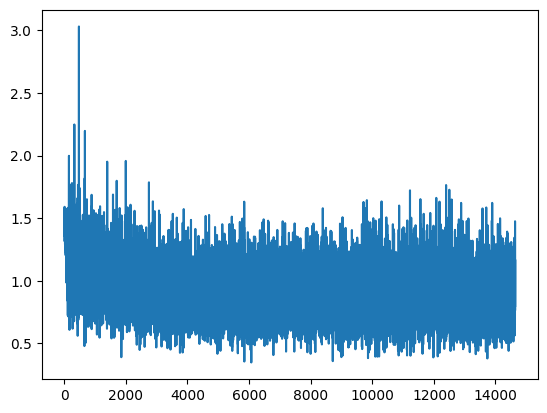

In [61]:
plt.plot(train_losses)

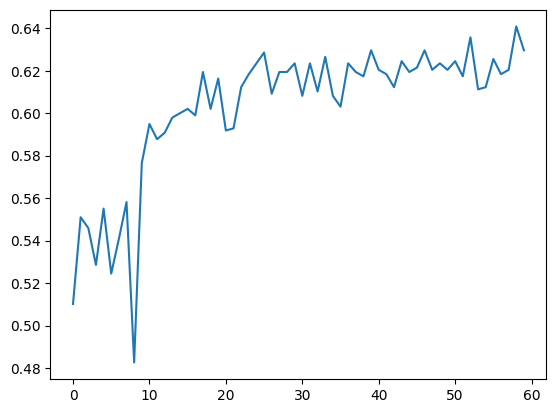

In [62]:
plt.plot(test_accuracy)

In [63]:
metrics2, confusion_matrix2 = report_metrics(
    model, labels=labels, device=device)
pprint(metrics2.compute())
confusion_matrix2.compute()

Correct: 617/976 (0.6322)
{'acc_detail': tensor([0.7323, 0.6389, 0.7087, 0.4484], device='cuda:0'),
 'acc_unweighted': tensor(0.6321, device='cuda:0'),
 'acc_weighted': tensor(0.6322, device='cuda:0'),
 'f1s_detail': tensor([0.7366, 0.5498, 0.7214, 0.5067], device='cuda:0'),
 'f1s_unweighted': tensor(0.6287, device='cuda:0'),
 'f1s_weighted': tensor(0.6320, device='cuda:0'),
 'precision_detail': tensor([0.7410, 0.4825, 0.7347, 0.5825], device='cuda:0'),
 'recall_detail': tensor([0.7323, 0.6389, 0.7087, 0.4484], device='cuda:0'),
 'rocauc': tensor(0.8598, device='cuda:0'),
 'rocauc_detail': tensor([0.9143, 0.8220, 0.9040, 0.7989], device='cuda:0'),
 'uar': tensor(0.6321, device='cuda:0'),
 'wap': tensor(0.6412, device='cuda:0')}


tensor([[186,  18,   5,  45],
        [  7, 138,  43,  28],
        [  5,  61, 180,   8],
        [ 53,  69,  17, 113]], device='cuda:0')

In [64]:
model.to('cpu')
best_model_path = f'{model_path_prefix}{best_epoch}epoch.pt'
print(best_model_path)
best_model = M13(config=model_config,
           n_input=1, n_output=len(labels))
best_model.load_state_dict(torch.load(best_model_path))
best_model.to(device)

metrics_best, confusion_matrix_best = report_metrics(
    best_model, labels=labels, device=device)
best_model.to('cpu')
pprint(metrics_best.compute())
confusion_matrix_best.compute()

../models_cremad4/cremad_label4_m13ser_best_59epoch.pt
Correct: 628/976 (0.6434)
{'acc_detail': tensor([0.6299, 0.6157, 0.7362, 0.5873], device='cuda:0'),
 'acc_unweighted': tensor(0.6423, device='cuda:0'),
 'acc_weighted': tensor(0.6434, device='cuda:0'),
 'f1s_detail': tensor([0.7175, 0.5473, 0.7276, 0.5850], device='cuda:0'),
 'f1s_unweighted': tensor(0.6444, device='cuda:0'),
 'f1s_weighted': tensor(0.6483, device='cuda:0'),
 'precision_detail': tensor([0.8333, 0.4926, 0.7192, 0.5827], device='cuda:0'),
 'recall_detail': tensor([0.6299, 0.6157, 0.7362, 0.5873], device='cuda:0'),
 'rocauc': tensor(0.8581, device='cuda:0'),
 'rocauc_detail': tensor([0.9138, 0.8213, 0.9043, 0.7930], device='cuda:0'),
 'uar': tensor(0.6423, device='cuda:0'),
 'wap': tensor(0.6635, device='cuda:0')}


tensor([[160,  20,   6,  68],
        [  2, 133,  50,  31],
        [  5,  55, 187,   7],
        [ 25,  62,  17, 148]], device='cuda:0')

In [65]:
checkpoint_path = f'../models_cremad4/cremad4_m13ser_{epoch}epoch.ckpt'
torch.save({
    'epoch': epoch,
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'loss': train_losses[-1],
    'best_epoch': best_epoch,
    'best_accuracy': best_accuracy,
    'train_losses': train_losses,
    'test_accuracy': test_accuracy,
    'log_interval': log_interval,
    }, checkpoint_path)

In [66]:
n_epoch = 10
n_epoch2 = 50
n_epoch3 = 40

optimizer = optim.RAdam(model.parameters(), lr=0.00001)
scheduler = optim.lr_scheduler.OneCycleLR(
    optimizer, max_lr=0.02, pct_start=0.3,
    steps_per_epoch=len(train_loader), epochs=n_epoch3)
log_interval = 40
pbar_update = 1 / (len(train_loader) + len(test_loader))
model.to(device)
with tqdm(total=n_epoch3) as pbar:
    for epoch in range(1+n_epoch+n_epoch2, n_epoch3+n_epoch2 + n_epoch + 1):
        train(model, epoch, log_interval, train_losses)
        acc = test(model, epoch)
        test_accuracy += [acc]
        if acc > best_accuracy:
            best_accuracy = acc
            best_epoch = epoch
            bmodel_path = f'{model_path_prefix}{epoch}epoch.pt'
            torch.save(model.state_dict(), bmodel_path)
            print(f'saved model: {bmodel_path}')
        scheduler.step()

  0%|                               | 0.003278688524590164/40 [00:00<1:17:56, 116.93s/it]

Train Epoch: 61 [0/3918 (0%)]	Loss: 0.683802
Mem before-during-after: 74245120 4072348160 77979648


  0%|                                | 0.13442622950819672/40 [00:17<1:42:23, 154.10s/it]

Train Epoch: 61 [640/3918 (16%)]	Loss: 1.153832
Mem before-during-after: 78759936 4075312640 78691328


  1%|▏                               | 0.26557377049180286/40 [00:35<1:31:33, 138.26s/it]

Train Epoch: 61 [1280/3918 (33%)]	Loss: 0.930323
Mem before-during-after: 77908992 4016834560 77919744


  1%|▎                                  | 0.39672131147541/40 [00:51<1:19:37, 120.63s/it]

Train Epoch: 61 [1920/3918 (49%)]	Loss: 0.927344
Mem before-during-after: 77878272 4077339648 77908992


  1%|▍                                | 0.5278688524590167/40 [01:07<1:20:19, 122.09s/it]

Train Epoch: 61 [2560/3918 (66%)]	Loss: 1.127405
Mem before-during-after: 77908992 4076303872 78186496


  2%|▌                                | 0.6590163934426216/40 [01:23<1:23:34, 127.46s/it]

Train Epoch: 61 [3200/3918 (82%)]	Loss: 0.910989
Mem before-during-after: 78186496 4075972096 77908992


  2%|▋                                | 0.7901639344262266/40 [01:39<1:25:13, 130.42s/it]

Train Epoch: 61 [3840/3918 (98%)]	Loss: 0.651890
Mem before-during-after: 77908992 4076860928 78186496


  2%|▉                                   | 0.9999999999999944/40 [01:54<44:36, 68.64s/it]


Test Epoch: 61	Accuracy: 623/976 (64%)



  3%|▉                                   | 1.0032786885245846/40 [01:54<54:04, 83.20s/it]

Train Epoch: 62 [0/3918 (0%)]	Loss: 0.806521
Mem before-during-after: 77871104 4074832896 77908992


  3%|▉                                | 1.1344262295081895/40 [02:12<1:36:16, 148.64s/it]

Train Epoch: 62 [640/3918 (16%)]	Loss: 1.075660
Mem before-during-after: 77908992 3951263744 77861888


  3%|█                                | 1.2655737704917944/40 [02:28<1:22:48, 128.26s/it]

Train Epoch: 62 [1280/3918 (33%)]	Loss: 0.608180
Mem before-during-after: 78186496 4074424320 77908992


  3%|█▏                               | 1.3967213114753994/40 [02:45<1:21:21, 126.46s/it]

Train Epoch: 62 [1920/3918 (49%)]	Loss: 0.919881
Mem before-during-after: 78186496 4074804224 77908992


  4%|█▎                               | 1.5278688524590043/40 [03:00<1:16:07, 118.73s/it]

Train Epoch: 62 [2560/3918 (66%)]	Loss: 0.904282
Mem before-during-after: 78186496 4074424320 77908992


  4%|█▎                               | 1.6590163934426092/40 [03:16<1:17:01, 120.53s/it]

Train Epoch: 62 [3200/3918 (82%)]	Loss: 0.664881
Mem before-during-after: 77878272 4076529664 77908992


  4%|█▍                               | 1.7901639344262141/40 [03:32<1:22:26, 129.45s/it]

Train Epoch: 62 [3840/3918 (98%)]	Loss: 0.800737
Mem before-during-after: 77878272 3868192256 77861888


  5%|█▊                                   | 1.999999999999982/40 [03:48<44:30, 70.27s/it]


Test Epoch: 62	Accuracy: 604/976 (62%)



  5%|█▊                                  | 2.0032786885245724/40 [03:49<55:05, 86.99s/it]

Train Epoch: 63 [0/3918 (0%)]	Loss: 0.714934
Mem before-during-after: 77871104 4074832896 77908992


  5%|█▊                               | 2.1344262295081773/40 [04:05<1:25:42, 135.80s/it]

Train Epoch: 63 [640/3918 (16%)]	Loss: 1.393939
Mem before-during-after: 77861888 3993337344 77861888


  6%|█▉                                | 2.265573770491782/40 [04:22<1:33:41, 148.97s/it]

Train Epoch: 63 [1280/3918 (33%)]	Loss: 0.706867
Mem before-during-after: 78743552 4073628160 77878272


  6%|██                                | 2.396721311475387/40 [04:40<1:16:58, 122.83s/it]

Train Epoch: 63 [1920/3918 (49%)]	Loss: 1.011759
Mem before-during-after: 77878272 4076782592 77908992


  6%|██▏                               | 2.527868852458992/40 [04:57<1:16:48, 122.97s/it]

Train Epoch: 63 [2560/3918 (66%)]	Loss: 0.829987
Mem before-during-after: 77878272 4077340160 77908992


  7%|██▎                               | 2.659016393442597/40 [05:14<1:25:47, 137.85s/it]

Train Epoch: 63 [3200/3918 (82%)]	Loss: 0.854266
Mem before-during-after: 77908992 4016834560 77919744


  7%|██▎                               | 2.790163934426202/40 [05:32<1:19:16, 127.82s/it]

Train Epoch: 63 [3840/3918 (98%)]	Loss: 0.865012
Mem before-during-after: 78743552 4074804224 77908992


  7%|██▊                                   | 2.99999999999997/40 [05:47<43:40, 70.81s/it]


Test Epoch: 63	Accuracy: 597/976 (61%)



  8%|██▋                                | 3.00327868852456/40 [05:48<1:05:34, 106.34s/it]

Train Epoch: 64 [0/3918 (0%)]	Loss: 0.932018
Mem before-during-after: 77871104 4074832896 77908992


  8%|██▋                               | 3.134426229508165/40 [06:04<1:16:25, 124.39s/it]

Train Epoch: 64 [640/3918 (16%)]	Loss: 0.555595
Mem before-during-after: 78186496 4075725312 77878272


  8%|██▊                                | 3.26557377049177/40 [06:21<1:13:27, 119.98s/it]

Train Epoch: 64 [1280/3918 (33%)]	Loss: 0.560203
Mem before-during-after: 77908992 4076782592 78186496


  8%|██▊                              | 3.3967213114753747/40 [06:40<1:23:24, 136.72s/it]

Train Epoch: 64 [1920/3918 (49%)]	Loss: 0.803349
Mem before-during-after: 78186496 4074725888 77878272


  9%|██▉                              | 3.5278688524589796/40 [06:55<1:21:39, 134.35s/it]

Train Epoch: 64 [2560/3918 (66%)]	Loss: 0.850544
Mem before-during-after: 77908992 4075668480 78186496


  9%|███                              | 3.6590163934425846/40 [07:13<1:26:07, 142.18s/it]

Train Epoch: 64 [3200/3918 (82%)]	Loss: 0.872455
Mem before-during-after: 77908992 4074763776 78186496


  9%|███▏                             | 3.7901639344261895/40 [07:30<1:14:57, 124.21s/it]

Train Epoch: 64 [3840/3918 (98%)]	Loss: 0.699436
Mem before-during-after: 77908992 4075746304 78186496


 10%|███▌                                | 3.9999999999999574/40 [07:45<41:06, 68.52s/it]


Test Epoch: 64	Accuracy: 608/976 (62%)



 10%|███▌                                | 4.0032786885245475/40 [07:45<49:29, 82.49s/it]

Train Epoch: 65 [0/3918 (0%)]	Loss: 0.830796
Mem before-during-after: 77871104 4074832896 77908992


 10%|███▌                              | 4.134426229508152/40 [08:02<1:12:59, 122.10s/it]

Train Epoch: 65 [640/3918 (16%)]	Loss: 1.058338
Mem before-during-after: 77908992 4077417472 78743552


 11%|███▋                              | 4.265573770491757/40 [08:18<1:12:08, 121.12s/it]

Train Epoch: 65 [1280/3918 (33%)]	Loss: 1.273180
Mem before-during-after: 77908992 4077417472 78743552


 11%|███▋                              | 4.396721311475362/40 [08:34<1:25:48, 144.60s/it]

Train Epoch: 65 [1920/3918 (49%)]	Loss: 0.591403
Mem before-during-after: 78022144 4076033536 77908992


 11%|███▊                              | 4.527868852458967/40 [08:53<1:26:41, 146.65s/it]

Train Epoch: 65 [2560/3918 (66%)]	Loss: 1.453013
Mem before-during-after: 77908992 4074128384 78186496


 12%|███▉                              | 4.659016393442572/40 [09:09<1:10:33, 119.78s/it]

Train Epoch: 65 [3200/3918 (82%)]	Loss: 0.986606
Mem before-during-after: 78186496 4074424320 77908992


 12%|████                              | 4.790163934426177/40 [09:25<1:24:16, 143.62s/it]

Train Epoch: 65 [3840/3918 (98%)]	Loss: 0.662388
Mem before-during-after: 77885440 4076529152 77885440


 12%|████▌                                | 4.999999999999945/40 [09:41<41:24, 70.97s/it]


Test Epoch: 65	Accuracy: 611/976 (62%)



 13%|████▋                                | 5.003278688524535/40 [09:41<50:09, 85.99s/it]

Train Epoch: 66 [0/3918 (0%)]	Loss: 0.939012
Mem before-during-after: 77871104 4074832896 77908992


 13%|████▍                              | 5.13442622950814/40 [09:57<1:13:14, 126.05s/it]

Train Epoch: 66 [640/3918 (16%)]	Loss: 0.808031
Mem before-during-after: 78186496 4075725312 77878272


 13%|████▍                             | 5.265573770491745/40 [10:14<1:14:55, 129.43s/it]

Train Epoch: 66 [1280/3918 (33%)]	Loss: 0.788816
Mem before-during-after: 77878272 4076225536 77908992


 13%|████▋                              | 5.39672131147535/40 [10:31<1:14:29, 129.15s/it]

Train Epoch: 66 [1920/3918 (49%)]	Loss: 0.713201
Mem before-during-after: 77878272 4077339648 77908992


 14%|████▋                             | 5.527868852458955/40 [10:48<1:24:21, 146.84s/it]

Train Epoch: 66 [2560/3918 (66%)]	Loss: 0.812683
Mem before-during-after: 77908992 4075320320 78743552


 14%|████▉                              | 5.65901639344256/40 [11:06<1:09:57, 122.24s/it]

Train Epoch: 66 [3200/3918 (82%)]	Loss: 1.081870
Mem before-during-after: 78743552 4074424320 77908992


 14%|████▉                             | 5.790163934426165/40 [11:23<1:15:41, 132.75s/it]

Train Epoch: 66 [3840/3918 (98%)]	Loss: 0.700005
Mem before-during-after: 78186496 4073071104 77878272


 15%|█████▍                              | 5.9999999999999325/40 [11:38<39:24, 69.54s/it]


Test Epoch: 66	Accuracy: 595/976 (61%)



 15%|█████▌                               | 6.003278688524523/40 [11:39<47:12, 83.32s/it]

Train Epoch: 67 [0/3918 (0%)]	Loss: 0.863913
Mem before-during-after: 77871104 4074832896 77908992


 15%|█████                            | 6.1344262295081275/40 [11:58<1:27:21, 154.77s/it]

Train Epoch: 67 [640/3918 (16%)]	Loss: 0.720953
Mem before-during-after: 77878272 4074685440 77908992


 16%|█████▏                           | 6.2655737704917325/40 [12:16<1:10:11, 124.83s/it]

Train Epoch: 67 [1280/3918 (33%)]	Loss: 0.753078
Mem before-during-after: 78186496 4075725312 77878272


 16%|█████▍                            | 6.396721311475337/40 [12:32<1:08:13, 121.82s/it]

Train Epoch: 67 [1920/3918 (49%)]	Loss: 0.580162
Mem before-during-after: 77908992 4076782592 78186496


 16%|█████▌                            | 6.527868852458942/40 [12:48<1:11:30, 128.18s/it]

Train Epoch: 67 [2560/3918 (66%)]	Loss: 1.206926
Mem before-during-after: 77908992 4076782592 78186496


 17%|█████▋                            | 6.659016393442547/40 [13:05<1:16:33, 137.79s/it]

Train Epoch: 67 [3200/3918 (82%)]	Loss: 0.994567
Mem before-during-after: 77878272 4075668480 77908992


 17%|█████▊                            | 6.790163934426152/40 [13:23<1:23:07, 150.19s/it]

Train Epoch: 67 [3840/3918 (98%)]	Loss: 0.875128
Mem before-during-after: 78186496 4072327168 77908992


 17%|██████▋                               | 6.99999999999992/40 [13:39<38:56, 70.81s/it]


Test Epoch: 67	Accuracy: 600/976 (61%)



 18%|██████▋                               | 7.00327868852451/40 [13:39<46:16, 84.14s/it]

Train Epoch: 68 [0/3918 (0%)]	Loss: 1.068463
Mem before-during-after: 77871104 4074832896 77908992


 18%|██████                            | 7.134426229508115/40 [13:56<1:09:26, 126.78s/it]

Train Epoch: 68 [640/3918 (16%)]	Loss: 0.874605
Mem before-during-after: 77908992 3910610944 77861888


 18%|██████▎                            | 7.26557377049172/40 [14:14<1:12:34, 133.03s/it]

Train Epoch: 68 [1280/3918 (33%)]	Loss: 0.705054
Mem before-during-after: 78186496 3743349760 77908992


 18%|██████▎                           | 7.396721311475325/40 [14:30<1:05:23, 120.35s/it]

Train Epoch: 68 [1920/3918 (49%)]	Loss: 0.631770
Mem before-during-after: 77878272 4076782592 77908992


 19%|██████▌                            | 7.52786885245893/40 [14:48<1:15:48, 140.06s/it]

Train Epoch: 68 [2560/3918 (66%)]	Loss: 0.900603
Mem before-during-after: 77908992 4075631104 77861888


 19%|██████▌                           | 7.659016393442535/40 [15:04<1:07:13, 124.71s/it]

Train Epoch: 68 [3200/3918 (82%)]	Loss: 0.914214
Mem before-during-after: 77908992 4074685440 78186496


 19%|██████▊                            | 7.79016393442614/40 [15:21<1:10:26, 131.22s/it]

Train Epoch: 68 [3840/3918 (98%)]	Loss: 0.791369
Mem before-during-after: 77908992 4076782592 78186496


 20%|███████▍                             | 7.999999999999908/40 [15:36<37:39, 70.62s/it]


Test Epoch: 68	Accuracy: 611/976 (62%)



 20%|███████▍                             | 8.003278688524498/40 [15:37<44:40, 83.78s/it]

Train Epoch: 69 [0/3918 (0%)]	Loss: 0.942126
Mem before-during-after: 77871104 4074832896 77908992


 20%|██████▉                           | 8.134426229508103/40 [15:54<1:06:52, 125.92s/it]

Train Epoch: 69 [640/3918 (16%)]	Loss: 0.996775
Mem before-during-after: 77878272 4073571328 77908992


 21%|███████                           | 8.265573770491708/40 [16:11<1:06:22, 125.51s/it]

Train Epoch: 69 [1280/3918 (33%)]	Loss: 0.976142
Mem before-during-after: 78186496 4074725888 77878272


 21%|███████▏                          | 8.396721311475313/40 [16:27<1:05:31, 124.41s/it]

Train Epoch: 69 [1920/3918 (49%)]	Loss: 1.092924
Mem before-during-after: 77908992 4076529664 78743552


 21%|███████▏                          | 8.527868852458917/40 [16:43<1:03:16, 120.62s/it]

Train Epoch: 69 [2560/3918 (66%)]	Loss: 1.025426
Mem before-during-after: 77878272 4076782592 77908992


 22%|███████▎                          | 8.659016393442522/40 [17:00<1:03:13, 121.02s/it]

Train Epoch: 69 [3200/3918 (82%)]	Loss: 0.937270
Mem before-during-after: 77908992 4076782592 78186496


 22%|███████▍                          | 8.790163934426127/40 [17:17<1:05:26, 125.82s/it]

Train Epoch: 69 [3840/3918 (98%)]	Loss: 0.893674
Mem before-during-after: 77878272 4075668992 77908992


 22%|████████▎                            | 8.999999999999895/40 [17:32<37:44, 73.06s/it]


Test Epoch: 69	Accuracy: 607/976 (62%)



 23%|████████▎                            | 9.003278688524485/40 [17:33<44:19, 85.80s/it]

Train Epoch: 70 [0/3918 (0%)]	Loss: 1.017845
Mem before-during-after: 77871104 4074832896 77908992


 23%|███████▉                           | 9.13442622950809/40 [17:49<1:06:41, 129.63s/it]

Train Epoch: 70 [640/3918 (16%)]	Loss: 0.902958
Mem before-during-after: 78186496 4074424320 77908992


 23%|███████▉                          | 9.265573770491695/40 [18:05<1:04:23, 125.69s/it]

Train Epoch: 70 [1280/3918 (33%)]	Loss: 0.828750
Mem before-during-after: 77940736 4077409792 78691328


 23%|████████▍                           | 9.3967213114753/40 [18:21<1:01:04, 119.74s/it]

Train Epoch: 70 [1920/3918 (49%)]	Loss: 1.142025
Mem before-during-after: 77940736 4077409792 78691328


 24%|████████                          | 9.527868852458905/40 [18:37<1:01:24, 120.90s/it]

Train Epoch: 70 [2560/3918 (66%)]	Loss: 0.788427
Mem before-during-after: 77878272 4076782592 77908992


 24%|████████▍                          | 9.65901639344251/40 [18:54<1:02:22, 123.35s/it]

Train Epoch: 70 [3200/3918 (82%)]	Loss: 0.814157
Mem before-during-after: 78186496 4072628736 77878272


 24%|████████▎                         | 9.790163934426115/40 [19:11<1:04:23, 127.88s/it]

Train Epoch: 70 [3840/3918 (98%)]	Loss: 0.863282
Mem before-during-after: 77924352 4075406848 77908992


 25%|█████████▏                           | 9.999999999999883/40 [19:26<36:59, 73.99s/it]


Test Epoch: 70	Accuracy: 627/976 (64%)



 25%|█████████                           | 10.003278688524473/40 [19:27<43:37, 87.27s/it]

Train Epoch: 71 [0/3918 (0%)]	Loss: 1.201986
Mem before-during-after: 77871104 4074832896 77908992


 25%|████████▎                        | 10.134426229508078/40 [19:43<1:01:31, 123.60s/it]

Train Epoch: 71 [640/3918 (16%)]	Loss: 0.989523
Mem before-during-after: 77878272 4076783104 77908992


 26%|████████▍                        | 10.265573770491683/40 [20:00<1:11:20, 143.97s/it]

Train Epoch: 71 [1280/3918 (33%)]	Loss: 0.725362
Mem before-during-after: 77908992 4074128384 78186496


 26%|████████▌                        | 10.396721311475288/40 [20:19<1:09:10, 140.22s/it]

Train Epoch: 71 [1920/3918 (49%)]	Loss: 0.789557
Mem before-during-after: 78953472 4075944448 77940736


 26%|████████▋                        | 10.527868852458893/40 [20:35<1:01:18, 124.82s/it]

Train Epoch: 71 [2560/3918 (66%)]	Loss: 1.049350
Mem before-during-after: 77940736 4076852736 78691328


 27%|████████▊                        | 10.659016393442498/40 [20:53<1:05:03, 133.05s/it]

Train Epoch: 71 [3200/3918 (82%)]	Loss: 0.885011
Mem before-during-after: 77986816 4076033536 78287872


 27%|█████████▍                         | 10.790163934426102/40 [21:10<59:02, 121.28s/it]

Train Epoch: 71 [3840/3918 (98%)]	Loss: 1.200822
Mem before-during-after: 78767104 4078217728 78767104


 27%|██████████▏                          | 10.99999999999987/40 [21:25<34:16, 70.91s/it]


Test Epoch: 71	Accuracy: 627/976 (64%)



 28%|██████████▏                          | 11.00327868852446/40 [21:26<41:18, 85.49s/it]

Train Epoch: 72 [0/3918 (0%)]	Loss: 0.464283
Mem before-during-after: 77871104 4074832896 77908992


 28%|█████████▏                       | 11.134426229508065/40 [21:42<1:01:37, 128.10s/it]

Train Epoch: 72 [640/3918 (16%)]	Loss: 1.109522
Mem before-during-after: 77908992 4076303872 78186496


 28%|██████████▏                         | 11.26557377049167/40 [21:59<57:31, 120.10s/it]

Train Epoch: 72 [1280/3918 (33%)]	Loss: 0.945407
Mem before-during-after: 78186496 4075725312 77878272


 28%|█████████▍                       | 11.396721311475275/40 [22:16<1:01:00, 127.99s/it]

Train Epoch: 72 [1920/3918 (49%)]	Loss: 0.763046
Mem before-during-after: 78186496 4075725312 77878272


 29%|█████████▊                        | 11.52786885245888/40 [22:32<1:07:20, 141.92s/it]

Train Epoch: 72 [2560/3918 (66%)]	Loss: 1.222123
Mem before-during-after: 77908992 4074128384 78186496


 29%|██████████▏                        | 11.659016393442485/40 [22:49<57:14, 121.20s/it]

Train Epoch: 72 [3200/3918 (82%)]	Loss: 0.586146
Mem before-during-after: 78743552 4075725312 77878272


 29%|██████████▌                         | 11.79016393442609/40 [23:04<57:30, 122.30s/it]

Train Epoch: 72 [3840/3918 (98%)]	Loss: 0.668095
Mem before-during-after: 78743552 4075725312 77878272


 30%|██████████▊                         | 11.999999999999858/40 [23:20<33:48, 72.44s/it]


Test Epoch: 72	Accuracy: 588/976 (60%)



 30%|██████████▊                         | 12.003278688524448/40 [23:21<40:16, 86.30s/it]

Train Epoch: 73 [0/3918 (0%)]	Loss: 0.835039
Mem before-during-after: 77871104 4074832896 77908992


 30%|██████████▌                        | 12.134426229508053/40 [23:38<56:36, 121.87s/it]

Train Epoch: 73 [640/3918 (16%)]	Loss: 0.591998
Mem before-during-after: 77878272 4076783104 77908992


 31%|██████████▋                        | 12.265573770491658/40 [23:55<55:58, 121.11s/it]

Train Epoch: 73 [1280/3918 (33%)]	Loss: 1.054756
Mem before-during-after: 77908992 3785308672 77861888


 31%|██████████▏                      | 12.396721311475263/40 [24:13<1:06:33, 144.67s/it]

Train Epoch: 73 [1920/3918 (49%)]	Loss: 0.719927
Mem before-during-after: 77924352 4075963392 77908992


 31%|██████████▉                        | 12.527868852458868/40 [24:32<58:45, 128.35s/it]

Train Epoch: 73 [2560/3918 (66%)]	Loss: 1.025660
Mem before-during-after: 77908992 4075668480 78186496


 32%|██████████▍                      | 12.659016393442473/40 [24:48<1:04:16, 141.07s/it]

Train Epoch: 73 [3200/3918 (82%)]	Loss: 0.799750
Mem before-during-after: 77908992 4075668480 78186496


 32%|███████████▏                       | 12.790163934426078/40 [25:04<56:02, 123.59s/it]

Train Epoch: 73 [3840/3918 (98%)]	Loss: 0.945162
Mem before-during-after: 78186496 4073071104 77878272


 32%|███████████▋                        | 12.999999999999845/40 [25:20<35:29, 78.87s/it]


Test Epoch: 73	Accuracy: 626/976 (64%)



 33%|███████████▋                        | 13.003278688524436/40 [25:20<41:00, 91.13s/it]

Train Epoch: 74 [0/3918 (0%)]	Loss: 0.990120
Mem before-during-after: 77871104 4074832896 77908992


 33%|███████████▏                      | 13.13442622950804/40 [25:38<1:07:59, 151.83s/it]

Train Epoch: 74 [640/3918 (16%)]	Loss: 0.816001
Mem before-during-after: 77878272 4074685440 77908992


 33%|███████████▌                       | 13.265573770491645/40 [25:56<54:45, 122.90s/it]

Train Epoch: 74 [1280/3918 (33%)]	Loss: 0.935067
Mem before-during-after: 78743552 4075725312 77878272


 33%|████████████                        | 13.39672131147525/40 [26:12<54:59, 124.04s/it]

Train Epoch: 74 [1920/3918 (49%)]	Loss: 0.941089
Mem before-during-after: 77908992 4076860416 78186496


 34%|███████████▊                       | 13.527868852458855/40 [26:29<54:27, 123.42s/it]

Train Epoch: 74 [2560/3918 (66%)]	Loss: 0.928727
Mem before-during-after: 78186496 4074424320 77908992


 34%|████████████▎                       | 13.65901639344246/40 [26:45<53:35, 122.08s/it]

Train Epoch: 74 [3200/3918 (82%)]	Loss: 0.838188
Mem before-during-after: 78186496 4073071104 77878272


 34%|███████████▍                     | 13.790163934426065/40 [27:03<1:04:16, 147.12s/it]

Train Epoch: 74 [3840/3918 (98%)]	Loss: 1.089921
Mem before-during-after: 78186496 4072326656 77908992


 35%|████████████▌                       | 13.999999999999833/40 [27:19<30:54, 71.34s/it]


Test Epoch: 74	Accuracy: 625/976 (64%)



 35%|████████████▌                       | 14.003278688524423/40 [27:19<37:21, 86.23s/it]

Train Epoch: 75 [0/3918 (0%)]	Loss: 0.826836
Mem before-during-after: 77871104 4074832896 77908992


 35%|████████████▎                      | 14.134426229508028/40 [27:35<53:59, 125.24s/it]

Train Epoch: 75 [640/3918 (16%)]	Loss: 1.053505
Mem before-during-after: 77878272 4076783104 77908992


 36%|████████████▍                      | 14.265573770491633/40 [27:52<55:51, 130.24s/it]

Train Epoch: 75 [1280/3918 (33%)]	Loss: 0.612068
Mem before-during-after: 77908992 4074725888 77878272


 36%|████████████▌                      | 14.396721311475238/40 [28:09<51:35, 120.89s/it]

Train Epoch: 75 [1920/3918 (49%)]	Loss: 0.738452
Mem before-during-after: 77878272 4076529152 77908992


 36%|████████████▋                      | 14.527868852458843/40 [28:25<51:30, 121.31s/it]

Train Epoch: 75 [2560/3918 (66%)]	Loss: 0.947106
Mem before-during-after: 78186496 4074804224 77908992


 37%|████████████▊                      | 14.659016393442448/40 [28:43<52:52, 125.20s/it]

Train Epoch: 75 [3200/3918 (82%)]	Loss: 1.222833
Mem before-during-after: 77878272 4075972608 77908992


 37%|████████████▏                    | 14.790163934426053/40 [29:00<1:02:01, 147.62s/it]

Train Epoch: 75 [3840/3918 (98%)]	Loss: 0.974778
Mem before-during-after: 78743552 4074685440 77908992


 37%|█████████████▊                       | 14.99999999999982/40 [29:17<29:17, 70.30s/it]


Test Epoch: 75	Accuracy: 615/976 (63%)



 38%|█████████████▉                       | 15.00327868852441/40 [29:17<35:44, 85.81s/it]

Train Epoch: 76 [0/3918 (0%)]	Loss: 1.079815
Mem before-during-after: 77871104 4074832896 77908992


 38%|████████████▍                    | 15.134426229508016/40 [29:35<1:03:31, 153.29s/it]

Train Epoch: 76 [640/3918 (16%)]	Loss: 0.797412
Mem before-during-after: 77908992 4074685440 78186496


 38%|█████████████▋                      | 15.26557377049162/40 [29:52<53:23, 129.52s/it]

Train Epoch: 76 [1280/3918 (33%)]	Loss: 0.989151
Mem before-during-after: 78022144 3808097792 77908992


 38%|█████████████▍                     | 15.396721311475225/40 [30:09<51:41, 126.06s/it]

Train Epoch: 76 [1920/3918 (49%)]	Loss: 0.765284
Mem before-during-after: 77878272 4076225536 77908992


 39%|█████████████▉                      | 15.52786885245883/40 [30:25<49:31, 121.44s/it]

Train Epoch: 76 [2560/3918 (66%)]	Loss: 0.961142
Mem before-during-after: 77908992 4076225536 78186496


 39%|█████████████▋                     | 15.659016393442435/40 [30:42<48:33, 119.71s/it]

Train Epoch: 76 [3200/3918 (82%)]	Loss: 0.704806
Mem before-during-after: 77908992 4076860928 78186496


 39%|██████████████▏                     | 15.79016393442604/40 [30:58<57:38, 142.87s/it]

Train Epoch: 76 [3840/3918 (98%)]	Loss: 0.980649
Mem before-during-after: 77861888 4076205568 77908992


 40%|██████████████▍                     | 15.999999999999808/40 [31:13<29:08, 72.84s/it]


Test Epoch: 76	Accuracy: 613/976 (63%)



 40%|███████████████▏                      | 16.0032786885244/40 [31:14<35:00, 87.54s/it]

Train Epoch: 77 [0/3918 (0%)]	Loss: 0.597223
Mem before-during-after: 77871104 4074832896 77908992


 40%|██████████████                     | 16.134426229508076/40 [31:30<48:01, 120.75s/it]

Train Epoch: 77 [640/3918 (16%)]	Loss: 0.592952
Mem before-during-after: 77878272 4075972608 77908992


 41%|██████████████▏                    | 16.265573770491752/40 [31:47<48:48, 123.39s/it]

Train Epoch: 77 [1280/3918 (33%)]	Loss: 0.856707
Mem before-during-after: 77908992 4076860416 78186496


 41%|██████████████▎                    | 16.396721311475428/40 [32:03<49:17, 125.31s/it]

Train Epoch: 77 [1920/3918 (49%)]	Loss: 0.773758
Mem before-during-after: 78186496 4074423808 77908992


 41%|██████████████▍                    | 16.527868852459104/40 [32:20<46:33, 118.99s/it]

Train Epoch: 77 [2560/3918 (66%)]	Loss: 0.835823
Mem before-during-after: 77878272 4076783104 77908992


 42%|██████████████▉                     | 16.65901639344278/40 [32:36<47:19, 121.65s/it]

Train Epoch: 77 [3200/3918 (82%)]	Loss: 0.902869
Mem before-during-after: 78743552 4074424320 77908992


 42%|██████████████▋                    | 16.790163934426456/40 [32:53<48:05, 124.32s/it]

Train Epoch: 77 [3840/3918 (98%)]	Loss: 1.224385
Mem before-during-after: 77878272 4076783104 77908992


 43%|███████████████▎                    | 17.000000000000338/40 [33:09<29:12, 76.21s/it]


Test Epoch: 77	Accuracy: 565/976 (58%)



 43%|███████████████▋                     | 17.00327868852493/40 [33:09<34:56, 91.18s/it]

Train Epoch: 78 [0/3918 (0%)]	Loss: 0.936229
Mem before-during-after: 77871104 4074832896 77908992


 43%|██████████████▉                    | 17.134426229508605/40 [33:26<46:07, 121.02s/it]

Train Epoch: 78 [640/3918 (16%)]	Loss: 0.955061
Mem before-during-after: 77908992 4076783104 78186496


 43%|███████████████▌                    | 17.26557377049228/40 [33:42<45:38, 120.47s/it]

Train Epoch: 78 [1280/3918 (33%)]	Loss: 0.942176
Mem before-during-after: 78186496 4074804224 77908992


 43%|███████████████▏                   | 17.396721311475957/40 [34:00<46:37, 123.79s/it]

Train Epoch: 78 [1920/3918 (49%)]	Loss: 1.043527
Mem before-during-after: 77908992 4076225536 78186496


 44%|███████████████▎                   | 17.527868852459633/40 [34:16<46:03, 123.00s/it]

Train Epoch: 78 [2560/3918 (66%)]	Loss: 0.755030
Mem before-during-after: 78186496 4073628160 77878272


 44%|███████████████▉                    | 17.65901639344331/40 [34:32<45:26, 122.06s/it]

Train Epoch: 78 [3200/3918 (82%)]	Loss: 0.628935
Mem before-during-after: 77878272 4076529664 77908992


 44%|███████████████▌                   | 17.790163934426985/40 [34:48<49:51, 134.71s/it]

Train Epoch: 78 [3840/3918 (98%)]	Loss: 0.799508
Mem before-during-after: 78186496 3867684352 77908992


 45%|████████████████▏                   | 18.000000000000867/40 [35:04<25:41, 70.08s/it]


Test Epoch: 78	Accuracy: 626/976 (64%)



 45%|████████████████▋                    | 18.00327868852546/40 [35:04<31:35, 86.16s/it]

Train Epoch: 79 [0/3918 (0%)]	Loss: 1.052921
Mem before-during-after: 77871104 4074832896 77908992


 45%|███████████████▊                   | 18.134426229509135/40 [35:20<45:28, 124.77s/it]

Train Epoch: 79 [640/3918 (16%)]	Loss: 0.992992
Mem before-during-after: 77908992 4076783104 78186496


 46%|████████████████▍                   | 18.26557377049281/40 [35:38<49:23, 136.35s/it]

Train Epoch: 79 [1280/3918 (33%)]	Loss: 0.533765
Mem before-during-after: 77908992 4075034112 78186496


 46%|████████████████                   | 18.396721311476487/40 [35:54<43:30, 120.82s/it]

Train Epoch: 79 [1920/3918 (49%)]	Loss: 0.874892
Mem before-during-after: 77908992 4076782592 78186496


 46%|████████████████▏                  | 18.527868852460163/40 [36:12<53:54, 150.64s/it]

Train Epoch: 79 [2560/3918 (66%)]	Loss: 0.830812
Mem before-during-after: 78692352 4077796864 79000576


 47%|████████████████▊                   | 18.65901639344384/40 [36:29<45:45, 128.67s/it]

Train Epoch: 79 [3200/3918 (82%)]	Loss: 0.955109
Mem before-during-after: 78248960 4076590592 78691328


 47%|████████████████▍                  | 18.790163934427515/40 [36:46<43:51, 124.08s/it]

Train Epoch: 79 [3840/3918 (98%)]	Loss: 1.163366
Mem before-during-after: 77908992 4076860416 78186496


 48%|█████████████████                   | 19.000000000001396/40 [37:02<24:27, 69.88s/it]


Test Epoch: 79	Accuracy: 623/976 (64%)



 48%|█████████████████                   | 19.003278688525988/40 [37:02<29:23, 83.98s/it]

Train Epoch: 80 [0/3918 (0%)]	Loss: 0.909002
Mem before-during-after: 77871104 4074832896 77908992


 48%|████████████████▋                  | 19.134426229509664/40 [37:20<54:12, 155.88s/it]

Train Epoch: 80 [640/3918 (16%)]	Loss: 0.688838
Mem before-during-after: 78097408 4075136512 77908992


 48%|█████████████████▎                  | 19.26557377049334/40 [37:36<44:57, 130.10s/it]

Train Epoch: 80 [1280/3918 (33%)]	Loss: 0.819641
Mem before-during-after: 77878272 4076782592 77908992


 48%|████████████████▉                  | 19.396721311477016/40 [37:52<41:42, 121.47s/it]

Train Epoch: 80 [1920/3918 (49%)]	Loss: 0.686987
Mem before-during-after: 78186496 4074804736 77908992


 49%|█████████████████                  | 19.527868852460692/40 [38:09<42:52, 125.66s/it]

Train Epoch: 80 [2560/3918 (66%)]	Loss: 0.601221
Mem before-during-after: 78691328 4076033536 78248960


 49%|█████████████████▏                 | 19.659016393444368/40 [38:25<40:55, 120.73s/it]

Train Epoch: 80 [3200/3918 (82%)]	Loss: 0.784581
Mem before-during-after: 77940736 4077409792 78691328


 49%|█████████████████▎                 | 19.790163934428044/40 [38:41<41:09, 122.21s/it]

Train Epoch: 80 [3840/3918 (98%)]	Loss: 0.926244
Mem before-during-after: 77940736 4075312640 78691328


 50%|██████████████████                  | 20.000000000001926/40 [38:56<22:58, 68.92s/it]


Test Epoch: 80	Accuracy: 620/976 (63%)



 50%|██████████████████                  | 20.003278688526517/40 [38:57<27:35, 82.78s/it]

Train Epoch: 81 [0/3918 (0%)]	Loss: 0.472548
Mem before-during-after: 77871104 4074832896 77908992


 50%|█████████████████▌                 | 20.134426229510193/40 [39:13<43:10, 130.40s/it]

Train Epoch: 81 [640/3918 (16%)]	Loss: 0.882858
Mem before-during-after: 77924352 4075406848 77908992


 51%|██████████████████▏                 | 20.26557377049387/40 [39:32<44:18, 134.72s/it]

Train Epoch: 81 [1280/3918 (33%)]	Loss: 1.228703
Mem before-during-after: 77878272 4017673728 77861888


 51%|█████████████████▊                 | 20.396721311477545/40 [39:48<39:23, 120.56s/it]

Train Epoch: 81 [1920/3918 (49%)]	Loss: 1.039142
Mem before-during-after: 78186496 4075725312 77878272


 51%|██████████████████▍                 | 20.52786885246122/40 [40:05<39:50, 122.76s/it]

Train Epoch: 81 [2560/3918 (66%)]	Loss: 0.762198
Mem before-during-after: 77878272 4076226048 77908992


 52%|██████████████████                 | 20.659016393444897/40 [40:24<44:08, 136.96s/it]

Train Epoch: 81 [3200/3918 (82%)]	Loss: 0.788455
Mem before-during-after: 77908992 4016851968 77861888


 52%|██████████████████▏                | 20.790163934428573/40 [40:42<40:11, 125.53s/it]

Train Epoch: 81 [3840/3918 (98%)]	Loss: 1.217204
Mem before-during-after: 77908992 4076303360 78186496


 53%|██████████████████▉                 | 21.000000000002455/40 [40:57<22:14, 70.25s/it]


Test Epoch: 81	Accuracy: 615/976 (63%)



 53%|██████████████████▉                 | 21.003278688527047/40 [40:57<26:30, 83.71s/it]

Train Epoch: 82 [0/3918 (0%)]	Loss: 0.771259
Mem before-during-after: 77871104 4074832896 77908992


 53%|██████████████████▍                | 21.134426229510723/40 [41:14<38:17, 121.76s/it]

Train Epoch: 82 [640/3918 (16%)]	Loss: 0.600600
Mem before-during-after: 77878272 4076783104 77908992


 53%|███████████████████▋                 | 21.2655737704944/40 [41:31<42:01, 134.61s/it]

Train Epoch: 82 [1280/3918 (33%)]	Loss: 1.240412
Mem before-during-after: 77878272 3909665280 77861888


 53%|██████████████████▋                | 21.396721311478075/40 [41:47<38:53, 125.44s/it]

Train Epoch: 82 [1920/3918 (49%)]	Loss: 0.950455
Mem before-during-after: 77878272 4076226048 77908992


 54%|███████████████████▍                | 21.52786885246175/40 [42:04<39:00, 126.72s/it]

Train Epoch: 82 [2560/3918 (66%)]	Loss: 0.816396
Mem before-during-after: 77908992 3909601280 78569472


 54%|██████████████████▉                | 21.659016393445427/40 [42:21<39:40, 129.80s/it]

Train Epoch: 82 [3200/3918 (82%)]	Loss: 0.518299
Mem before-during-after: 77908992 4074725888 77878272


 54%|███████████████████                | 21.790163934429103/40 [42:37<44:38, 147.11s/it]

Train Epoch: 82 [3840/3918 (98%)]	Loss: 0.787269
Mem before-during-after: 77861888 4076745216 77878272


 55%|███████████████████▊                | 22.000000000002984/40 [42:53<21:22, 71.27s/it]


Test Epoch: 82	Accuracy: 619/976 (63%)



 55%|███████████████████▊                | 22.003278688527576/40 [42:53<25:20, 84.48s/it]

Train Epoch: 83 [0/3918 (0%)]	Loss: 0.742902
Mem before-during-after: 77871104 4074832896 77908992


 55%|███████████████████▎               | 22.134426229511252/40 [43:10<36:36, 122.92s/it]

Train Epoch: 83 [640/3918 (16%)]	Loss: 0.887435
Mem before-during-after: 77908992 4077417472 78743552


 56%|███████████████████▍               | 22.265573770494928/40 [43:27<36:14, 122.60s/it]

Train Epoch: 83 [1280/3918 (33%)]	Loss: 1.000120
Mem before-during-after: 77908992 4076860928 78186496


 56%|███████████████████▌               | 22.396721311478604/40 [43:44<37:06, 126.48s/it]

Train Epoch: 83 [1920/3918 (49%)]	Loss: 1.056030
Mem before-during-after: 77878272 4076225536 77908992


 56%|████████████████████▎               | 22.52786885246228/40 [44:00<35:27, 121.75s/it]

Train Epoch: 83 [2560/3918 (66%)]	Loss: 0.754513
Mem before-during-after: 77908992 4076860928 78186496


 57%|███████████████████▊               | 22.659016393445956/40 [44:16<35:37, 123.26s/it]

Train Epoch: 83 [3200/3918 (82%)]	Loss: 0.850023
Mem before-during-after: 77908992 4076860416 78186496


 57%|███████████████████▉               | 22.790163934429632/40 [44:35<43:08, 150.40s/it]

Train Epoch: 83 [3840/3918 (98%)]	Loss: 0.694456
Mem before-during-after: 78186496 4073628160 77878272


 58%|████████████████████▋               | 23.000000000003514/40 [44:50<19:36, 69.19s/it]


Test Epoch: 83	Accuracy: 611/976 (62%)



 58%|████████████████████▋               | 23.003278688528106/40 [44:50<23:40, 83.60s/it]

Train Epoch: 84 [0/3918 (0%)]	Loss: 1.035003
Mem before-during-after: 77871104 4074832896 77908992


 58%|████████████████████▊               | 23.13442622951178/40 [45:08<40:12, 143.05s/it]

Train Epoch: 84 [640/3918 (16%)]	Loss: 0.839990
Mem before-during-after: 77861888 4074393088 77885440


 58%|████████████████████▎              | 23.265573770495457/40 [45:24<33:59, 121.86s/it]

Train Epoch: 84 [1280/3918 (33%)]	Loss: 0.654362
Mem before-during-after: 77878272 4076782592 77908992


 58%|████████████████████▍              | 23.396721311479133/40 [45:41<33:39, 121.61s/it]

Train Epoch: 84 [1920/3918 (49%)]	Loss: 1.113595
Mem before-during-after: 78186496 4075725312 77878272


 59%|█████████████████████▏              | 23.52786885246281/40 [46:00<41:04, 149.62s/it]

Train Epoch: 84 [2560/3918 (66%)]	Loss: 0.636272
Mem before-during-after: 77878272 4074432000 77908992


 59%|████████████████████▋              | 23.659016393446485/40 [46:18<37:06, 136.22s/it]

Train Epoch: 84 [3200/3918 (82%)]	Loss: 0.781681
Mem before-during-after: 78186496 4072628736 77878272


 59%|█████████████████████▍              | 23.79016393443016/40 [46:34<33:12, 122.89s/it]

Train Epoch: 84 [3840/3918 (98%)]	Loss: 0.626462
Mem before-during-after: 77908992 3948429312 77954048


 60%|█████████████████████▌              | 24.000000000004043/40 [46:49<18:21, 68.87s/it]


Test Epoch: 84	Accuracy: 620/976 (63%)



 60%|█████████████████████▌              | 24.003278688528635/40 [46:49<21:58, 82.39s/it]

Train Epoch: 85 [0/3918 (0%)]	Loss: 1.089496
Mem before-during-after: 77871104 3910304256 77861888


 60%|█████████████████████▋              | 24.13442622951231/40 [47:07<39:36, 149.77s/it]

Train Epoch: 85 [640/3918 (16%)]	Loss: 1.310579
Mem before-during-after: 78186496 4072707584 77908992


 61%|█████████████████████▏             | 24.265573770495987/40 [47:24<32:13, 122.89s/it]

Train Epoch: 85 [1280/3918 (33%)]	Loss: 0.697819
Mem before-during-after: 77878272 4076782592 77908992


 61%|█████████████████████▎             | 24.396721311479663/40 [47:40<31:23, 120.70s/it]

Train Epoch: 85 [1920/3918 (49%)]	Loss: 1.287905
Mem before-during-after: 77861888 4005546496 77908992


 61%|██████████████████████              | 24.52786885246334/40 [47:56<32:45, 127.06s/it]

Train Epoch: 85 [2560/3918 (66%)]	Loss: 0.956800
Mem before-during-after: 77878272 4074685952 77908992


 62%|█████████████████████▌             | 24.659016393447015/40 [48:13<33:36, 131.43s/it]

Train Epoch: 85 [3200/3918 (82%)]	Loss: 1.164148
Mem before-during-after: 77908992 4076783104 78186496


 62%|██████████████████████▎             | 24.79016393443069/40 [48:29<34:38, 136.63s/it]

Train Epoch: 85 [3840/3918 (98%)]	Loss: 0.851223
Mem before-during-after: 77908992 4075034112 78186496


 63%|██████████████████████▌             | 25.000000000004572/40 [48:44<17:30, 70.02s/it]


Test Epoch: 85	Accuracy: 619/976 (63%)



 63%|██████████████████████▌             | 25.003278688529164/40 [48:45<21:08, 84.57s/it]

Train Epoch: 86 [0/3918 (0%)]	Loss: 0.762232
Mem before-during-after: 77871104 4074832896 77908992


 63%|██████████████████████▌             | 25.13442622951284/40 [49:01<30:29, 123.10s/it]

Train Epoch: 86 [640/3918 (16%)]	Loss: 0.690389
Mem before-during-after: 78186496 4074423808 77908992


 63%|██████████████████████             | 25.265573770496516/40 [49:17<29:13, 118.99s/it]

Train Epoch: 86 [1280/3918 (33%)]	Loss: 0.950000
Mem before-during-after: 78186496 4074424320 77908992


 63%|██████████████████████▏            | 25.396721311480192/40 [49:35<32:05, 131.84s/it]

Train Epoch: 86 [1920/3918 (49%)]	Loss: 1.218415
Mem before-during-after: 77878272 4076225536 77908992


 64%|██████████████████████▎            | 25.527868852463868/40 [49:53<35:03, 145.35s/it]

Train Epoch: 86 [2560/3918 (66%)]	Loss: 0.765157
Mem before-during-after: 77908992 4074763264 78186496


 64%|██████████████████████▍            | 25.659016393447544/40 [50:11<28:26, 118.96s/it]

Train Epoch: 86 [3200/3918 (82%)]	Loss: 0.886010
Mem before-during-after: 77878272 4076782592 77908992


 64%|███████████████████████▏            | 25.79016393443122/40 [50:27<30:42, 129.63s/it]

Train Epoch: 86 [3840/3918 (98%)]	Loss: 0.716797
Mem before-during-after: 78186496 4072628736 77878272


 65%|████████████████████████▋             | 26.0000000000051/40 [50:42<16:22, 70.20s/it]


Test Epoch: 86	Accuracy: 628/976 (64%)



 65%|███████████████████████▍            | 26.003278688529694/40 [50:42<19:25, 83.26s/it]

Train Epoch: 87 [0/3918 (0%)]	Loss: 0.596177
Mem before-during-after: 77871104 3953103872 77861888


 65%|███████████████████████▌            | 26.13442622951337/40 [50:59<27:33, 119.24s/it]

Train Epoch: 87 [640/3918 (16%)]	Loss: 0.807058
Mem before-during-after: 77908992 4076782592 78186496


 66%|██████████████████████▉            | 26.265573770497046/40 [51:16<32:10, 140.59s/it]

Train Epoch: 87 [1280/3918 (33%)]	Loss: 1.021315
Mem before-during-after: 77878272 4076226048 77908992


 66%|███████████████████████▊            | 26.39672131148072/40 [51:32<31:40, 139.71s/it]

Train Epoch: 87 [1920/3918 (49%)]	Loss: 1.061690
Mem before-during-after: 77861888 4076823040 77878272


 66%|███████████████████████▏           | 26.527868852464398/40 [51:48<29:26, 131.12s/it]

Train Epoch: 87 [2560/3918 (66%)]	Loss: 1.308614
Mem before-during-after: 77908992 4077877248 78743552


 67%|███████████████████████▎           | 26.659016393448074/40 [52:04<26:17, 118.23s/it]

Train Epoch: 87 [3200/3918 (82%)]	Loss: 1.012103
Mem before-during-after: 78743552 4074423808 77908992


 67%|████████████████████████            | 26.79016393443175/40 [52:20<26:10, 118.90s/it]

Train Epoch: 87 [3840/3918 (98%)]	Loss: 1.368328
Mem before-during-after: 77908992 4076782592 78186496


 68%|████████████████████████▉            | 27.00000000000563/40 [52:35<15:19, 70.72s/it]


Test Epoch: 87	Accuracy: 598/976 (61%)



 68%|████████████████████████▎           | 27.003278688530223/40 [52:35<18:09, 83.86s/it]

Train Epoch: 88 [0/3918 (0%)]	Loss: 0.756763
Mem before-during-after: 77871104 4074832896 77908992


 68%|█████████████████████████            | 27.1344262295139/40 [52:51<26:39, 124.34s/it]

Train Epoch: 88 [640/3918 (16%)]	Loss: 0.724955
Mem before-during-after: 77878272 4076225536 77908992


 68%|███████████████████████▊           | 27.265573770497575/40 [53:08<30:46, 144.97s/it]

Train Epoch: 88 [1280/3918 (33%)]	Loss: 1.094394
Mem before-during-after: 78743552 4072707072 77908992


 68%|████████████████████████▋           | 27.39672131148125/40 [53:25<25:11, 119.89s/it]

Train Epoch: 88 [1920/3918 (49%)]	Loss: 0.722030
Mem before-during-after: 77908992 4076303360 78186496


 69%|████████████████████████           | 27.527868852464927/40 [53:41<25:04, 120.67s/it]

Train Epoch: 88 [2560/3918 (66%)]	Loss: 1.064425
Mem before-during-after: 78186496 4074424320 77908992


 69%|████████████████████████▏          | 27.659016393448603/40 [53:59<25:29, 123.91s/it]

Train Epoch: 88 [3200/3918 (82%)]	Loss: 1.394212
Mem before-during-after: 78743552 4074423808 77908992


 69%|█████████████████████████           | 27.79016393443228/40 [54:16<25:49, 126.95s/it]

Train Epoch: 88 [3840/3918 (98%)]	Loss: 0.976108
Mem before-during-after: 77878272 4076783104 77908992


 70%|█████████████████████████▉           | 28.00000000000616/40 [54:31<13:49, 69.14s/it]


Test Epoch: 88	Accuracy: 623/976 (64%)



 70%|█████████████████████████▏          | 28.003278688530752/40 [54:31<16:40, 83.42s/it]

Train Epoch: 89 [0/3918 (0%)]	Loss: 1.063769
Mem before-during-after: 77871104 4074832896 77908992


 70%|█████████████████████████▎          | 28.13442622951443/40 [54:47<26:18, 133.03s/it]

Train Epoch: 89 [640/3918 (16%)]	Loss: 0.500827
Mem before-during-after: 78186496 4074725888 77878272


 71%|████████████████████████▋          | 28.265573770498104/40 [55:04<25:40, 131.24s/it]

Train Epoch: 89 [1280/3918 (33%)]	Loss: 0.604785
Mem before-during-after: 77908992 4075168256 77878272


 71%|█████████████████████████▌          | 28.39672131148178/40 [55:20<23:20, 120.67s/it]

Train Epoch: 89 [1920/3918 (49%)]	Loss: 0.792609
Mem before-during-after: 78186496 4075725312 77878272


 71%|████████████████████████▉          | 28.527868852465456/40 [55:36<23:39, 123.77s/it]

Train Epoch: 89 [2560/3918 (66%)]	Loss: 0.757074
Mem before-during-after: 77908992 4076226048 78186496


 72%|█████████████████████████          | 28.659016393449132/40 [55:52<22:51, 120.96s/it]

Train Epoch: 89 [3200/3918 (82%)]	Loss: 0.920838
Mem before-during-after: 77908992 4075242496 78743552


 72%|█████████████████████████▏         | 28.790163934432808/40 [56:09<24:48, 132.79s/it]

Train Epoch: 89 [3840/3918 (98%)]	Loss: 0.844935
Mem before-during-after: 77908992 4076303360 78186496


 73%|██████████████████████████▊          | 29.00000000000669/40 [56:24<13:19, 72.69s/it]


Test Epoch: 89	Accuracy: 619/976 (63%)



 73%|██████████████████████████▊          | 29.00327868853128/40 [56:24<15:33, 84.91s/it]

Train Epoch: 90 [0/3918 (0%)]	Loss: 0.811134
Mem before-during-after: 77871104 4074832896 77908992


 73%|█████████████████████████▍         | 29.134426229514958/40 [56:42<21:45, 120.16s/it]

Train Epoch: 90 [640/3918 (16%)]	Loss: 0.786794
Mem before-during-after: 77908992 4076303360 78186496


 73%|█████████████████████████▌         | 29.265573770498634/40 [56:58<25:56, 145.03s/it]

Train Epoch: 90 [1280/3918 (33%)]	Loss: 0.769223
Mem before-during-after: 78186496 4072327168 77908992


 73%|██████████████████████████▍         | 29.39672131148231/40 [57:14<21:53, 123.91s/it]

Train Epoch: 90 [1920/3918 (49%)]	Loss: 0.953656
Mem before-during-after: 77878272 4076783104 77908992


 74%|█████████████████████████▊         | 29.527868852465986/40 [57:32<21:26, 122.86s/it]

Train Epoch: 90 [2560/3918 (66%)]	Loss: 0.863890
Mem before-during-after: 78186496 4074424320 77908992


 74%|██████████████████████████▋         | 29.65901639344966/40 [57:48<20:24, 118.38s/it]

Train Epoch: 90 [3200/3918 (82%)]	Loss: 0.589241
Mem before-during-after: 77908992 4076225536 78186496


 74%|██████████████████████████         | 29.790163934433338/40 [58:04<20:40, 121.53s/it]

Train Epoch: 90 [3840/3918 (98%)]	Loss: 0.837960
Mem before-during-after: 77908992 4075668480 78186496


 75%|███████████████████████████▊         | 30.00000000000722/40 [58:19<11:47, 70.78s/it]


Test Epoch: 90	Accuracy: 621/976 (63%)



 75%|███████████████████████████▊         | 30.00327868853181/40 [58:20<14:07, 84.77s/it]

Train Epoch: 91 [0/3918 (0%)]	Loss: 0.768457
Mem before-during-after: 77871104 4074832896 77908992


 75%|██████████████████████████▎        | 30.134426229515487/40 [58:35<20:31, 124.87s/it]

Train Epoch: 91 [640/3918 (16%)]	Loss: 1.047488
Mem before-during-after: 77878272 4076529664 77908992


 76%|██████████████████████████▍        | 30.265573770499163/40 [58:52<19:37, 120.97s/it]

Train Epoch: 91 [1280/3918 (33%)]	Loss: 1.199108
Mem before-during-after: 77908992 4076303360 78186496


 76%|███████████████████████████▎        | 30.39672131148284/40 [59:07<19:17, 120.54s/it]

Train Epoch: 91 [1920/3918 (49%)]	Loss: 0.977710
Mem before-during-after: 77908992 4074685952 78186496


 76%|██████████████████████████▋        | 30.527868852466515/40 [59:23<18:31, 117.32s/it]

Train Epoch: 91 [2560/3918 (66%)]	Loss: 0.787683
Mem before-during-after: 77908992 3968297472 77861888


 77%|███████████████████████████▌        | 30.65901639345019/40 [59:41<22:42, 145.83s/it]

Train Epoch: 91 [3200/3918 (82%)]	Loss: 1.052940
Mem before-during-after: 77908992 4074685440 78186496


 77%|██████████████████████████▉        | 30.790163934433867/40 [59:59<18:27, 120.25s/it]

Train Epoch: 91 [3840/3918 (98%)]	Loss: 0.495734
Mem before-during-after: 77878272 4076225536 77908992


 78%|███████████████████████████▏       | 31.00000000000775/40 [1:00:14<10:34, 70.50s/it]


Test Epoch: 91	Accuracy: 620/976 (63%)



 78%|███████████████████████████▏       | 31.00327868853234/40 [1:00:15<12:41, 84.59s/it]

Train Epoch: 92 [0/3918 (0%)]	Loss: 0.982812
Mem before-during-after: 77871104 4074832896 77908992


 78%|█████████████████████████▋       | 31.134426229516016/40 [1:00:31<18:47, 127.21s/it]

Train Epoch: 92 [640/3918 (16%)]	Loss: 0.879113
Mem before-during-after: 77908992 4075746816 78186496


 78%|█████████████████████████▊       | 31.265573770499692/40 [1:00:47<21:05, 144.86s/it]

Train Epoch: 92 [1280/3918 (33%)]	Loss: 0.739610
Mem before-during-after: 78186496 4072327168 77908992


 78%|██████████████████████████▋       | 31.39672131148337/40 [1:01:05<18:42, 130.50s/it]

Train Epoch: 92 [1920/3918 (49%)]	Loss: 0.723572
Mem before-during-after: 77908992 4074424320 77924352


 79%|██████████████████████████       | 31.527868852467044/40 [1:01:21<16:53, 119.66s/it]

Train Epoch: 92 [2560/3918 (66%)]	Loss: 1.106946
Mem before-during-after: 78186496 4075725312 77878272


 79%|██████████████████████████▉       | 31.65901639345072/40 [1:01:39<20:31, 147.64s/it]

Train Epoch: 92 [3200/3918 (82%)]	Loss: 0.730569
Mem before-during-after: 78186496 4073628160 77878272


 79%|██████████████████████████▏      | 31.790163934434396/40 [1:01:58<18:06, 132.38s/it]

Train Epoch: 92 [3840/3918 (98%)]	Loss: 0.938709
Mem before-during-after: 77878272 4017530368 77861888


 80%|████████████████████████████       | 32.00000000000828/40 [1:02:13<09:16, 69.55s/it]


Test Epoch: 92	Accuracy: 614/976 (63%)



 80%|███████████████████████████▏      | 32.003278688532866/40 [1:02:14<10:59, 82.45s/it]

Train Epoch: 93 [0/3918 (0%)]	Loss: 0.782512
Mem before-during-after: 77871104 4074832896 77908992


 80%|████████████████████████████       | 32.1344262295164/40 [1:02:31<16:59, 129.60s/it]

Train Epoch: 93 [640/3918 (16%)]	Loss: 1.245558
Mem before-during-after: 78186496 4075972096 77908992


 81%|██████████████████████████▌      | 32.265573770499934/40 [1:02:48<17:35, 136.41s/it]

Train Epoch: 93 [1280/3918 (33%)]	Loss: 0.970781
Mem before-during-after: 78193152 4075955712 77908992


 81%|███████████████████████████▌      | 32.39672131148347/40 [1:03:04<15:05, 119.08s/it]

Train Epoch: 93 [1920/3918 (49%)]	Loss: 0.763964
Mem before-during-after: 77901824 4076590592 78652416


 81%|█████████████████████████████▎      | 32.527868852467/40 [1:03:21<14:56, 119.94s/it]

Train Epoch: 93 [2560/3918 (66%)]	Loss: 1.220961
Mem before-during-after: 78679040 4076840448 78953472


 82%|██████████████████████████▉      | 32.659016393450536/40 [1:03:37<17:27, 142.65s/it]

Train Epoch: 93 [3200/3918 (82%)]	Loss: 0.883238
Mem before-during-after: 78186496 4072327168 77908992


 82%|███████████████████████████▊      | 32.79016393443407/40 [1:03:53<14:14, 118.51s/it]

Train Epoch: 93 [3840/3918 (98%)]	Loss: 0.828232
Mem before-during-after: 78743552 4074423808 77908992


 83%|████████████████████████████      | 33.000000000007724/40 [1:04:08<08:39, 74.26s/it]


Test Epoch: 93	Accuracy: 622/976 (63%)



 83%|████████████████████████████▉      | 33.00327868853231/40 [1:04:09<10:01, 85.95s/it]

Train Epoch: 94 [0/3918 (0%)]	Loss: 0.842206
Mem before-during-after: 77871104 4074832896 77908992


 83%|███████████████████████████▎     | 33.134426229515846/40 [1:04:25<13:51, 121.16s/it]

Train Epoch: 94 [640/3918 (16%)]	Loss: 0.814592
Mem before-during-after: 77878272 4076783104 77908992


 83%|████████████████████████████▎     | 33.26557377049938/40 [1:04:42<14:22, 128.05s/it]

Train Epoch: 94 [1280/3918 (33%)]	Loss: 0.905972
Mem before-during-after: 77908992 3867383808 78022144


 83%|███████████████████████████▌     | 33.396721311482914/40 [1:04:59<14:38, 132.99s/it]

Train Epoch: 94 [1920/3918 (49%)]	Loss: 1.051393
Mem before-during-after: 78511104 4075485184 78248960


 84%|████████████████████████████▍     | 33.52786885246645/40 [1:05:16<15:06, 140.05s/it]

Train Epoch: 94 [2560/3918 (66%)]	Loss: 1.025942
Mem before-during-after: 78953472 4075430400 77940736


 84%|████████████████████████████▌     | 33.65901639344998/40 [1:05:32<12:38, 119.68s/it]

Train Epoch: 94 [3200/3918 (82%)]	Loss: 0.793335
Mem before-during-after: 78953472 4076501504 77940736


 84%|███████████████████████████▉     | 33.790163934433515/40 [1:05:49<12:17, 118.79s/it]

Train Epoch: 94 [3840/3918 (98%)]	Loss: 0.614685
Mem before-during-after: 78186496 4074804224 77908992


 85%|█████████████████████████████▊     | 34.00000000000717/40 [1:06:05<07:05, 70.96s/it]


Test Epoch: 94	Accuracy: 587/976 (60%)



 85%|█████████████████████████████▊     | 34.00327868853176/40 [1:06:05<08:29, 85.01s/it]

Train Epoch: 95 [0/3918 (0%)]	Loss: 0.991963
Mem before-during-after: 77871104 4074832896 77908992


 85%|█████████████████████████████     | 34.13442622951529/40 [1:06:22<11:47, 120.61s/it]

Train Epoch: 95 [640/3918 (16%)]	Loss: 0.734695
Mem before-during-after: 77878272 4076225536 77908992


 86%|████████████████████████████▎    | 34.265573770498825/40 [1:06:38<12:58, 135.84s/it]

Train Epoch: 95 [1280/3918 (33%)]	Loss: 1.177664
Mem before-during-after: 77908992 4075034112 78186496


 86%|█████████████████████████████▏    | 34.39672131148236/40 [1:06:55<12:08, 129.93s/it]

Train Epoch: 95 [1920/3918 (49%)]	Loss: 0.980268
Mem before-during-after: 77908992 3968563200 77954048


 86%|█████████████████████████████▎    | 34.52786885246589/40 [1:07:11<12:07, 132.87s/it]

Train Epoch: 95 [2560/3918 (66%)]	Loss: 0.757620
Mem before-during-after: 77861888 4076782592 77908992


 87%|█████████████████████████████▍    | 34.65901639344943/40 [1:07:27<11:30, 129.33s/it]

Train Epoch: 95 [3200/3918 (82%)]	Loss: 0.939572
Mem before-during-after: 77908992 4074685440 78186496


 87%|█████████████████████████████▌    | 34.79016393443296/40 [1:07:43<10:19, 118.98s/it]

Train Epoch: 95 [3840/3918 (98%)]	Loss: 1.325420
Mem before-during-after: 78186496 4074804224 77908992


 88%|█████████████████████████████▊    | 35.000000000006615/40 [1:07:58<05:56, 71.30s/it]


Test Epoch: 95	Accuracy: 599/976 (61%)



 88%|███████████████████████████████▌    | 35.0032786885312/40 [1:07:58<06:58, 83.70s/it]

Train Epoch: 96 [0/3918 (0%)]	Loss: 1.130013
Mem before-during-after: 77871104 4074832896 77908992


 88%|█████████████████████████████▊    | 35.13442622951474/40 [1:08:15<09:42, 119.76s/it]

Train Epoch: 96 [640/3918 (16%)]	Loss: 0.715508
Mem before-during-after: 78186496 4074804224 77908992


 88%|█████████████████████████████▉    | 35.26557377049827/40 [1:08:31<09:41, 122.85s/it]

Train Epoch: 96 [1280/3918 (33%)]	Loss: 0.686481
Mem before-during-after: 77908992 4074685440 78186496


 88%|█████████████████████████████▏   | 35.396721311481805/40 [1:08:48<09:39, 125.79s/it]

Train Epoch: 96 [1920/3918 (49%)]	Loss: 0.642130
Mem before-during-after: 77908992 4076782592 78186496


 89%|██████████████████████████████▏   | 35.52786885246534/40 [1:09:05<09:07, 122.40s/it]

Train Epoch: 96 [2560/3918 (66%)]	Loss: 0.802102
Mem before-during-after: 78186496 4074804736 77908992


 89%|██████████████████████████████▎   | 35.65901639344887/40 [1:09:23<10:12, 141.05s/it]

Train Epoch: 96 [3200/3918 (82%)]	Loss: 0.823653
Mem before-during-after: 78186496 4074725888 77878272


 89%|██████████████████████████████▍   | 35.79016393443241/40 [1:09:39<08:30, 121.18s/it]

Train Epoch: 96 [3840/3918 (98%)]	Loss: 0.554936
Mem before-during-after: 78186496 4072326656 77908992


 90%|███████████████████████████████▌   | 36.00000000000606/40 [1:09:55<04:55, 73.82s/it]


Test Epoch: 96	Accuracy: 614/976 (63%)



 90%|███████████████████████████████▌   | 36.00327868853065/40 [1:09:56<05:47, 87.01s/it]

Train Epoch: 97 [0/3918 (0%)]	Loss: 0.579315
Mem before-during-after: 77871104 4074832896 77908992


 90%|██████████████████████████████▋   | 36.13442622951418/40 [1:10:12<08:43, 135.55s/it]

Train Epoch: 97 [640/3918 (16%)]	Loss: 0.844519
Mem before-during-after: 77908992 4076782592 78186496


 91%|██████████████████████████████▊   | 36.26557377049772/40 [1:10:29<07:53, 126.70s/it]

Train Epoch: 97 [1280/3918 (33%)]	Loss: 0.834086
Mem before-during-after: 77908992 4075668480 78186496


 91%|██████████████████████████████▉   | 36.39672131148125/40 [1:10:45<07:09, 119.25s/it]

Train Epoch: 97 [1920/3918 (49%)]	Loss: 0.373564
Mem before-during-after: 77908992 4077417472 78743552


 91%|██████████████████████████████▏  | 36.527868852464785/40 [1:11:01<07:32, 130.44s/it]

Train Epoch: 97 [2560/3918 (66%)]	Loss: 0.887779
Mem before-during-after: 77885440 4077495808 77885440


 92%|███████████████████████████████▏  | 36.65901639344832/40 [1:11:19<06:36, 118.68s/it]

Train Epoch: 97 [3200/3918 (82%)]	Loss: 1.152945
Mem before-during-after: 77878272 4076782592 77908992


 92%|███████████████████████████████▎  | 36.79016393443185/40 [1:11:37<07:46, 145.46s/it]

Train Epoch: 97 [3840/3918 (98%)]	Loss: 1.108002
Mem before-during-after: 77919744 4075955712 77908992


 93%|████████████████████████████████▍  | 37.00000000000551/40 [1:11:52<03:28, 69.38s/it]


Test Epoch: 97	Accuracy: 624/976 (64%)



 93%|███████████████████████████████▍  | 37.003278688530095/40 [1:11:52<04:10, 83.51s/it]

Train Epoch: 98 [0/3918 (0%)]	Loss: 0.717956
Mem before-during-after: 77871104 4074832896 77908992


 93%|███████████████████████████████▌  | 37.13442622951363/40 [1:12:08<05:39, 118.59s/it]

Train Epoch: 98 [640/3918 (16%)]	Loss: 0.525124
Mem before-during-after: 77908992 4076860416 78186496


 93%|███████████████████████████████▋  | 37.26557377049716/40 [1:12:24<06:31, 142.99s/it]

Train Epoch: 98 [1280/3918 (33%)]	Loss: 0.583305
Mem before-during-after: 77878272 4073571328 77908992


 93%|████████████████████████████████▋  | 37.3967213114807/40 [1:12:40<05:14, 120.91s/it]

Train Epoch: 98 [1920/3918 (49%)]	Loss: 0.967227
Mem before-during-after: 78186496 4075725312 77878272


 94%|███████████████████████████████▉  | 37.52786885246423/40 [1:12:56<05:18, 128.93s/it]

Train Epoch: 98 [2560/3918 (66%)]	Loss: 0.781143
Mem before-during-after: 78186496 4074423808 77908992


 94%|███████████████████████████████  | 37.659016393447764/40 [1:13:14<05:37, 144.37s/it]

Train Epoch: 98 [3200/3918 (82%)]	Loss: 0.967368
Mem before-during-after: 77908992 4073071104 77878272


 94%|█████████████████████████████████  | 37.7901639344313/40 [1:13:33<05:22, 146.13s/it]

Train Epoch: 98 [3840/3918 (98%)]	Loss: 0.653971
Mem before-during-after: 78186496 4073071104 77878272


 95%|█████████████████████████████████▎ | 38.00000000000495/40 [1:13:48<02:23, 71.78s/it]


Test Epoch: 98	Accuracy: 607/976 (62%)



 95%|█████████████████████████████████▎ | 38.00327868852954/40 [1:13:49<02:50, 85.39s/it]

Train Epoch: 99 [0/3918 (0%)]	Loss: 0.869784
Mem before-during-after: 77871104 4074832896 77908992


 95%|███████████████████████████████▍ | 38.134426229513075/40 [1:14:05<03:42, 119.34s/it]

Train Epoch: 99 [640/3918 (16%)]	Loss: 0.969279
Mem before-during-after: 78186496 4074423808 77908992


 96%|████████████████████████████████▌ | 38.26557377049661/40 [1:14:21<03:28, 120.20s/it]

Train Epoch: 99 [1280/3918 (33%)]	Loss: 0.896519
Mem before-during-after: 77878272 4076782592 77908992


 96%|████████████████████████████████▋ | 38.39672131148014/40 [1:14:37<03:11, 119.42s/it]

Train Epoch: 99 [1920/3918 (49%)]	Loss: 0.934241
Mem before-during-after: 78186496 4074804224 77908992


 96%|███████████████████████████████▊ | 38.527868852463676/40 [1:14:52<03:05, 125.87s/it]

Train Epoch: 99 [2560/3918 (66%)]	Loss: 0.873673
Mem before-during-after: 78186496 4075168256 77878272


 97%|████████████████████████████████▊ | 38.65901639344721/40 [1:15:08<03:07, 139.79s/it]

Train Epoch: 99 [3200/3918 (82%)]	Loss: 0.594814
Mem before-during-after: 77861888 4074828288 77878272


 97%|████████████████████████████████ | 38.790163934430744/40 [1:15:25<02:55, 145.17s/it]

Train Epoch: 99 [3840/3918 (98%)]	Loss: 0.572071
Mem before-during-after: 78186496 4072326656 77908992


 98%|███████████████████████████████████ | 39.0000000000044/40 [1:15:41<01:10, 70.36s/it]


Test Epoch: 99	Accuracy: 629/976 (64%)

saved model: ../models_cremad4/cremad_label4_m13ser_best_99epoch.pt


 98%|██████████████████████████████████▏| 39.00327868852899/40 [1:15:41<01:23, 83.97s/it]

Train Epoch: 100 [0/3918 (0%)]	Loss: 0.807003
Mem before-during-after: 77871104 4074832896 77908992


 98%|█████████████████████████████████▎| 39.13442622951252/40 [1:15:57<01:42, 118.27s/it]

Train Epoch: 100 [640/3918 (16%)]	Loss: 1.440085
Mem before-during-after: 77908992 4076782592 78186496


 98%|████████████████████████████████▍| 39.265573770496054/40 [1:16:13<01:42, 139.96s/it]

Train Epoch: 100 [1280/3918 (33%)]	Loss: 1.004165
Mem before-during-after: 79022592 4032590336 77861888


 98%|█████████████████████████████████▍| 39.39672131147959/40 [1:16:29<01:13, 121.59s/it]

Train Epoch: 100 [1920/3918 (49%)]	Loss: 0.732612
Mem before-during-after: 78186496 4072707072 77908992


 99%|█████████████████████████████████▌| 39.52786885246312/40 [1:16:46<00:58, 123.73s/it]

Train Epoch: 100 [2560/3918 (66%)]	Loss: 1.094036
Mem before-during-after: 77908992 4076782592 78186496


 99%|████████████████████████████████▋| 39.659016393446656/40 [1:17:03<00:40, 120.05s/it]

Train Epoch: 100 [3200/3918 (82%)]	Loss: 1.027245
Mem before-during-after: 77908992 4076303360 78186496


 99%|█████████████████████████████████▊| 39.79016393443019/40 [1:17:19<00:29, 141.77s/it]

Train Epoch: 100 [3840/3918 (98%)]	Loss: 0.686391
Mem before-during-after: 78186496 4073071104 77878272


100%|█████████████████████████████████▉| 39.996721311479256/40 [1:17:35<00:00, 69.74s/it]/opt/anaconda3/envs/audio/lib/python3.9/site-packages/tqdm/std.py:639: TqdmWarning: clamping frac to range [0, 1]
  full_bar = Bar(frac,
100%|█████████████████████████████████| 40.000000000003844/40 [1:17:35<00:00, 116.39s/it]


Test Epoch: 100	Accuracy: 629/976 (64%)



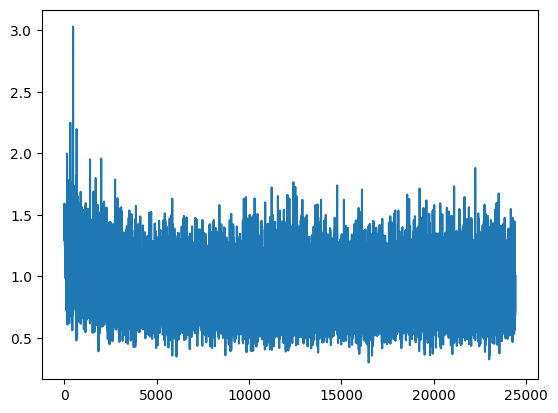

In [67]:
plt.plot(train_losses)

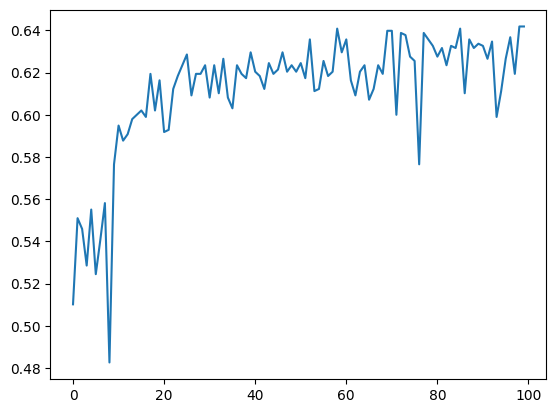

In [68]:
plt.plot(test_accuracy)

In [70]:
model.to('cpu')
best_model_path = f'{model_path_prefix}{best_epoch}epoch.pt'
print(best_model_path)
best_model = M13(config=model_config,
           n_input=1, n_output=len(labels))
best_model.load_state_dict(torch.load(best_model_path))
best_model.to(device)

metrics_best, confusion_matrix_best = report_metrics(
    best_model, labels=labels, device=device)
best_model.to('cpu')
pprint(metrics_best.compute())
confusion_matrix_best.compute()

../models_cremad4/cremad_label4_m13ser_best_99epoch.pt
Correct: 629/976 (0.6445)
{'acc_detail': tensor([0.6693, 0.6759, 0.7087, 0.5278], device='cuda:0'),
 'acc_unweighted': tensor(0.6454, device='cuda:0'),
 'acc_weighted': tensor(0.6445, device='cuda:0'),
 'f1s_detail': tensor([0.7359, 0.5626, 0.7171, 0.5672], device='cuda:0'),
 'f1s_unweighted': tensor(0.6457, device='cuda:0'),
 'f1s_weighted': tensor(0.6491, device='cuda:0'),
 'precision_detail': tensor([0.8173, 0.4818, 0.7258, 0.6129], device='cuda:0'),
 'recall_detail': tensor([0.6693, 0.6759, 0.7087, 0.5278], device='cuda:0'),
 'rocauc': tensor(0.8607, device='cuda:0'),
 'rocauc_detail': tensor([0.9171, 0.8306, 0.9052, 0.7901], device='cuda:0'),
 'uar': tensor(0.6454, device='cuda:0'),
 'wap': tensor(0.6665, device='cuda:0')}


tensor([[170,  21,   5,  58],
        [  3, 146,  45,  22],
        [  5,  65, 180,   4],
        [ 30,  71,  18, 133]], device='cuda:0')

Time domain: Filters' shapes vary by frequency bins


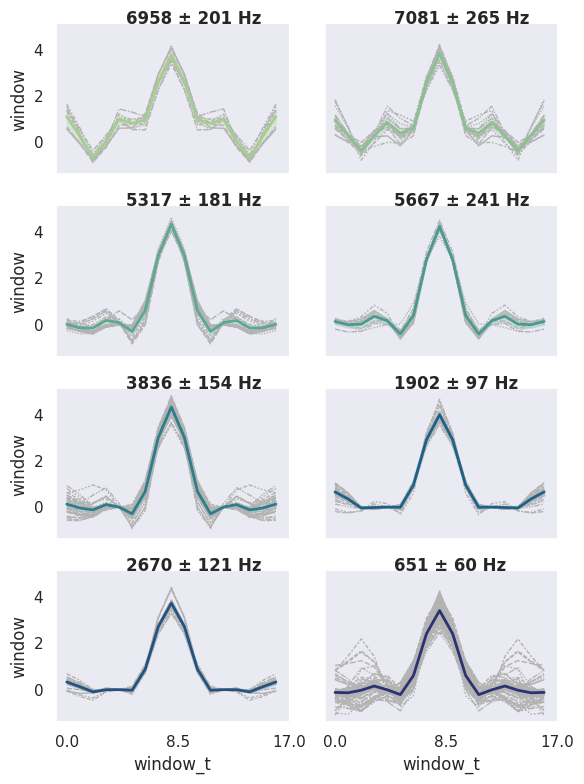

In [71]:
from IConNet.visualizer import visualize_model

layer = best_model.fe_blocks.blocks[0].block.layer

filtviz = visualize_model.FilterVisualizer(
    lowcut_bands = layer.lowcut_bands, 
    bandwidths = layer.bandwidths,
    window_params = layer.window_params, 
    window_length = 64,
    sample_rate = sr
)
filtviz.visualize_filters(filter_domain='time')

Frequency domain: Filters' shapes vary by frequency bins


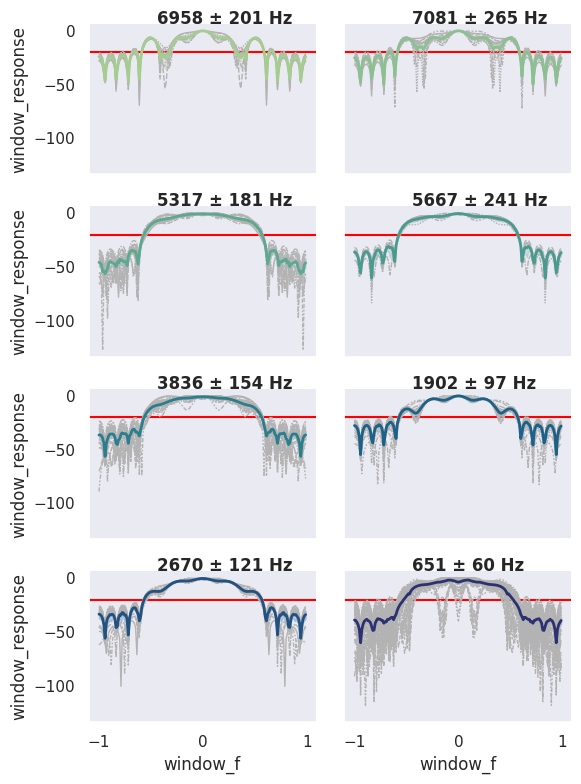

In [72]:
filtviz.visualize_filters(filter_domain='freq')

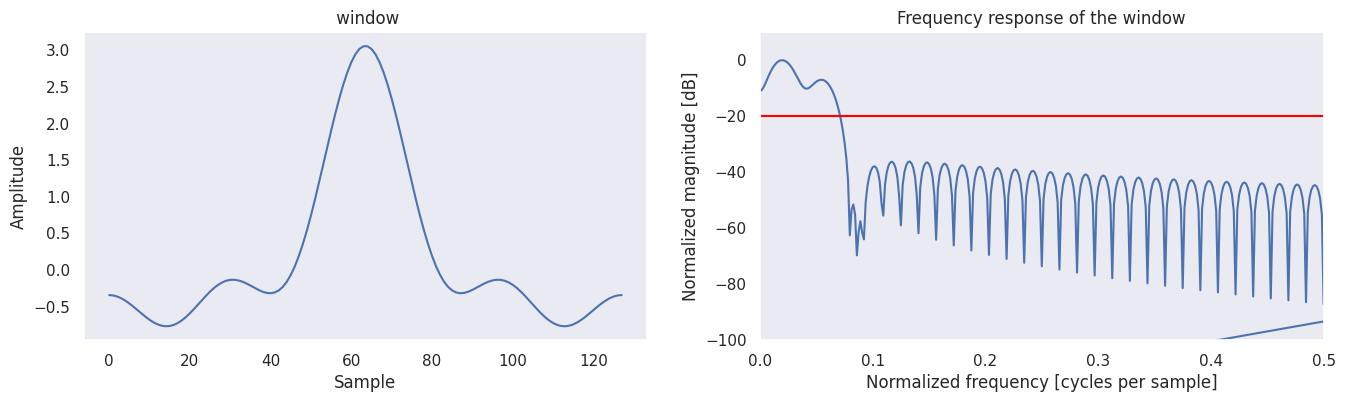

In [73]:
filtviz.visualize_one_window(n_out=10)

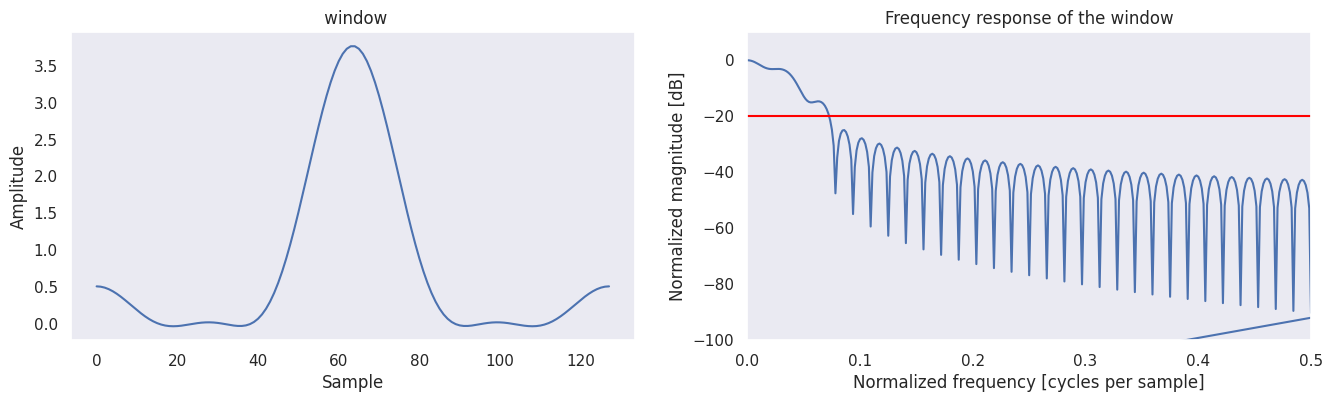

In [74]:
filtviz.visualize_one_window(n_out=30)

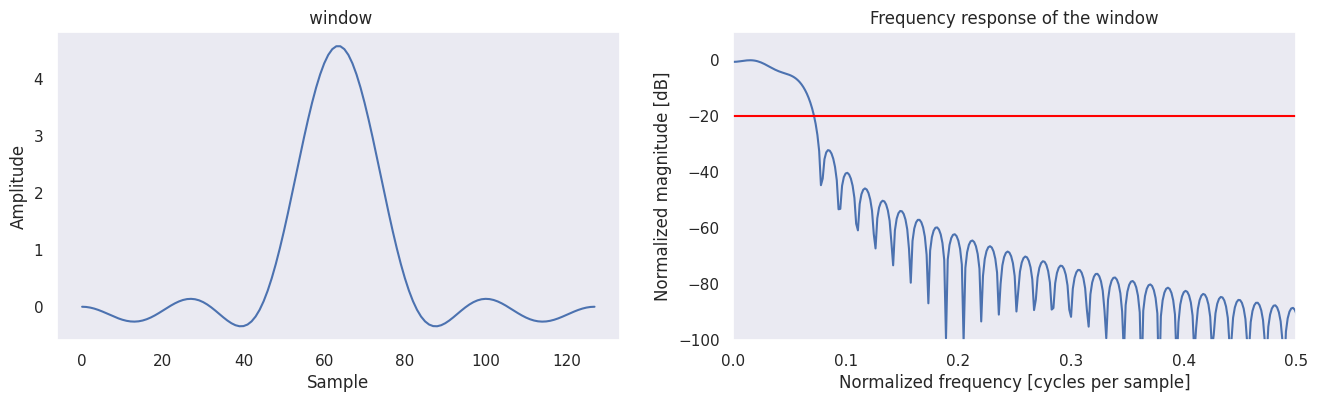

In [75]:
filtviz.visualize_one_window(n_out=50)

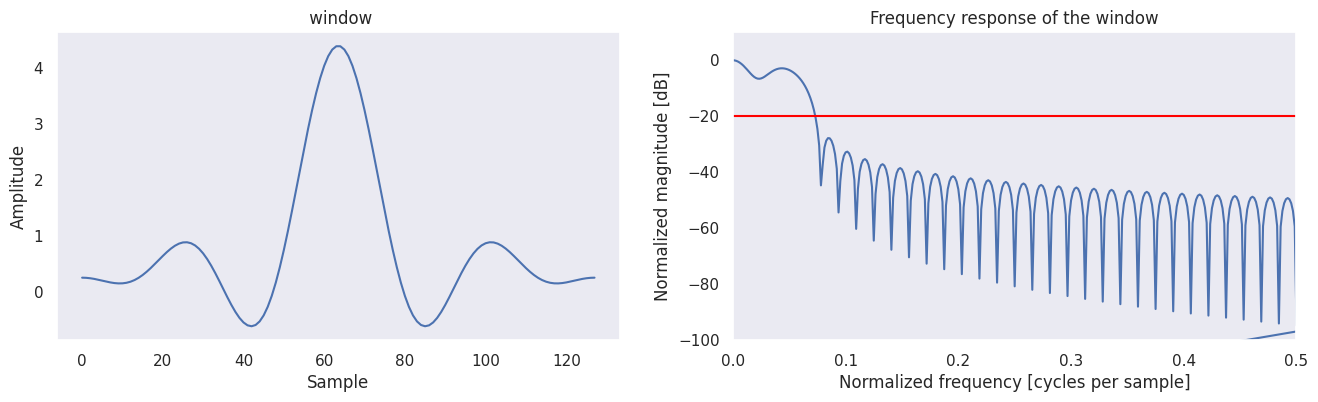

In [76]:
filtviz.visualize_one_window(n_out=60)

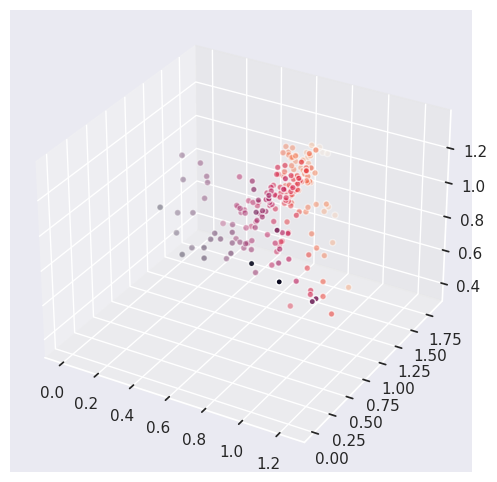

In [77]:
filtviz.visualize_window_params()

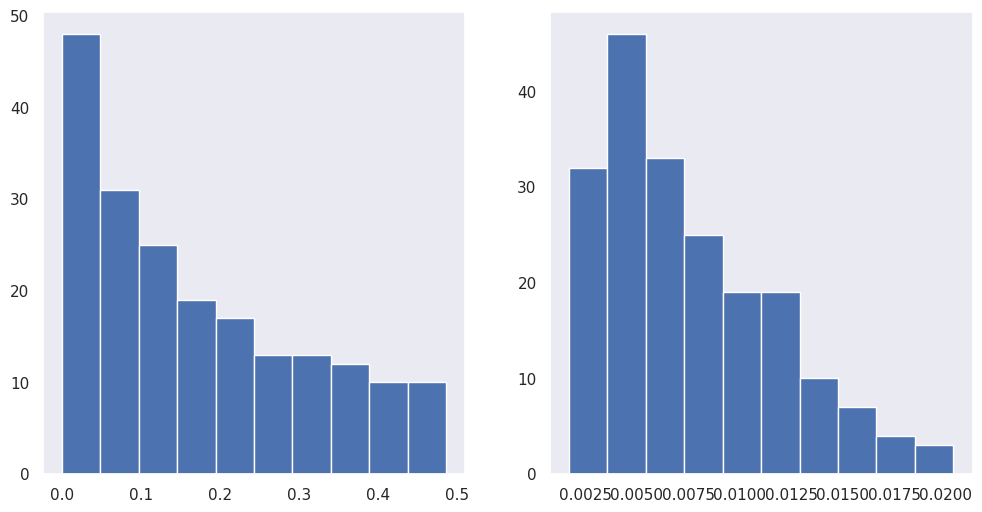

In [78]:
filtviz.visualize_bands()

downsample_factor: 2 => new_sample_rate: 8000
Time domain: Filters' shapes vary by frequency bins


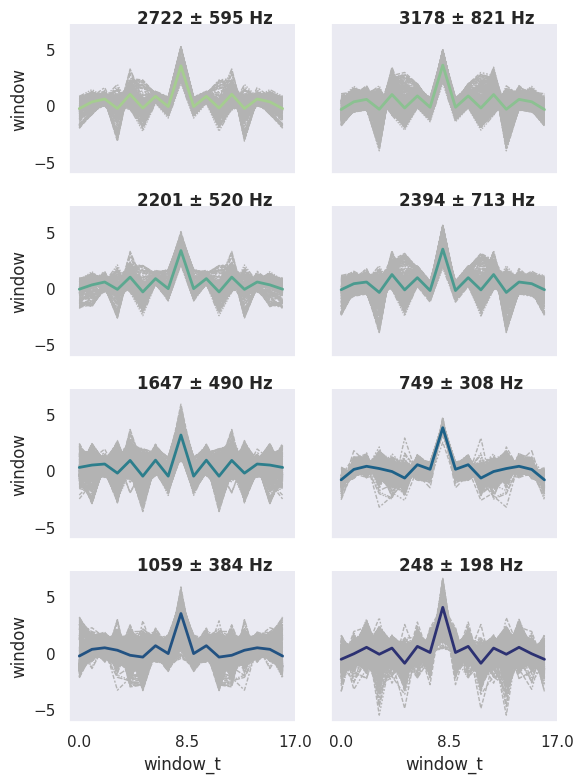

In [79]:
layer2 = best_model.fe_blocks.blocks[1].block.layer
downsample_factor = best_model.fe_blocks.blocks[0].stride
new_sample_rate = sr // downsample_factor
print(f'downsample_factor: {downsample_factor} => new_sample_rate: {new_sample_rate}')

filtviz2 = visualize_model.FilterVisualizer(
    lowcut_bands = layer2.lowcut_bands, 
    bandwidths = layer2.bandwidths,
    window_params = layer2.window_params, 
    window_length = 64,
    sample_rate = new_sample_rate
)
filtviz2.visualize_filters(filter_domain='time')

Frequency domain: Filters' shapes vary by frequency bins


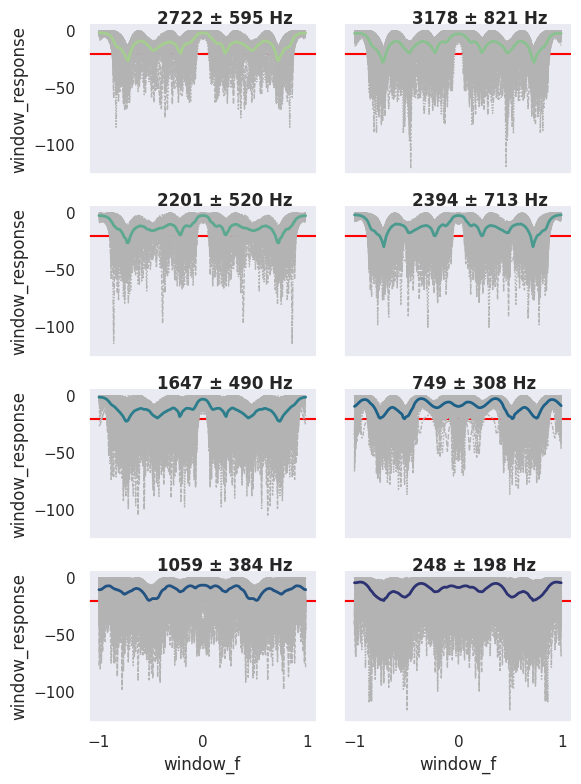

In [80]:
filtviz2.visualize_filters(filter_domain='freq')

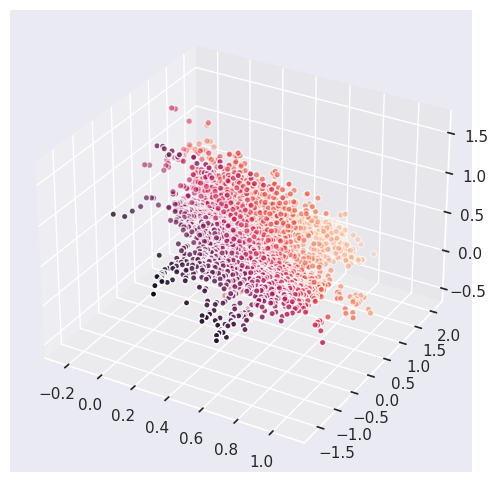

In [81]:
filtviz2.visualize_window_params()

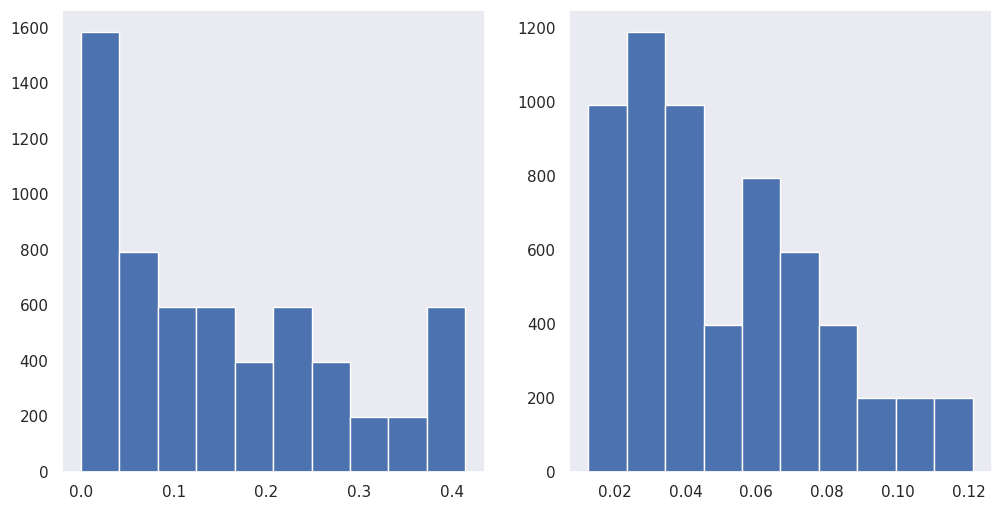

In [82]:
filtviz2.visualize_bands()

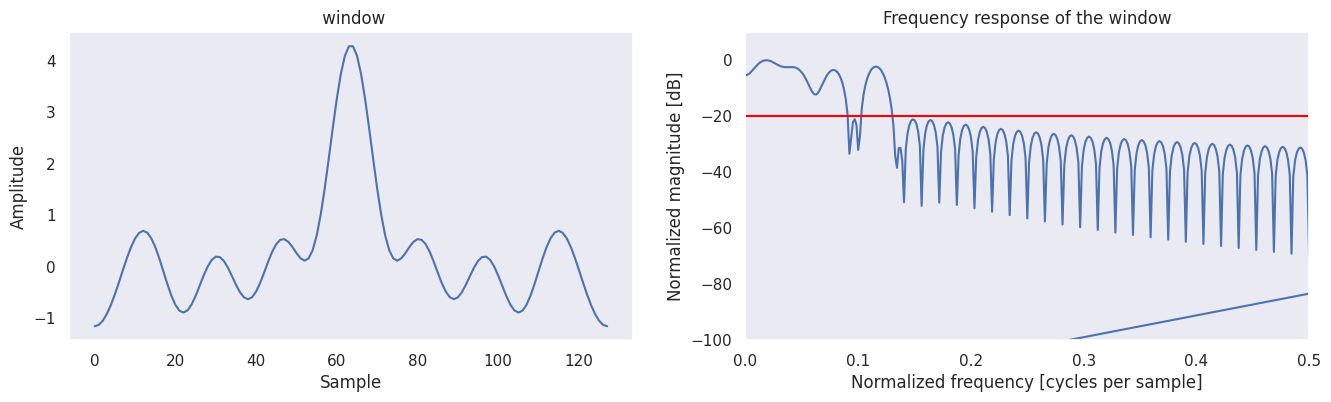

In [83]:
filtviz2.visualize_one_window(n_inp=10, n_out=10)

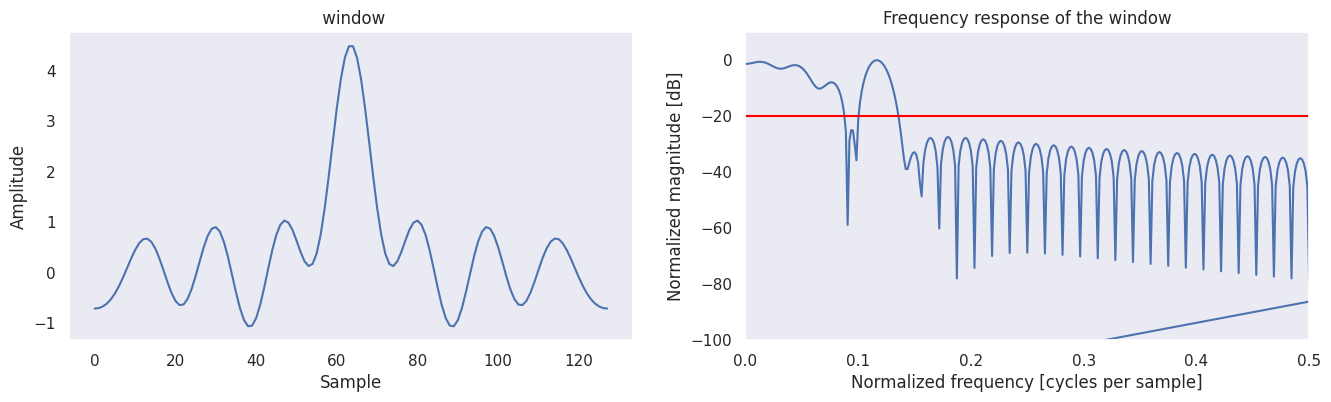

In [85]:
filtviz2.visualize_one_window(n_inp=30, n_out=10)

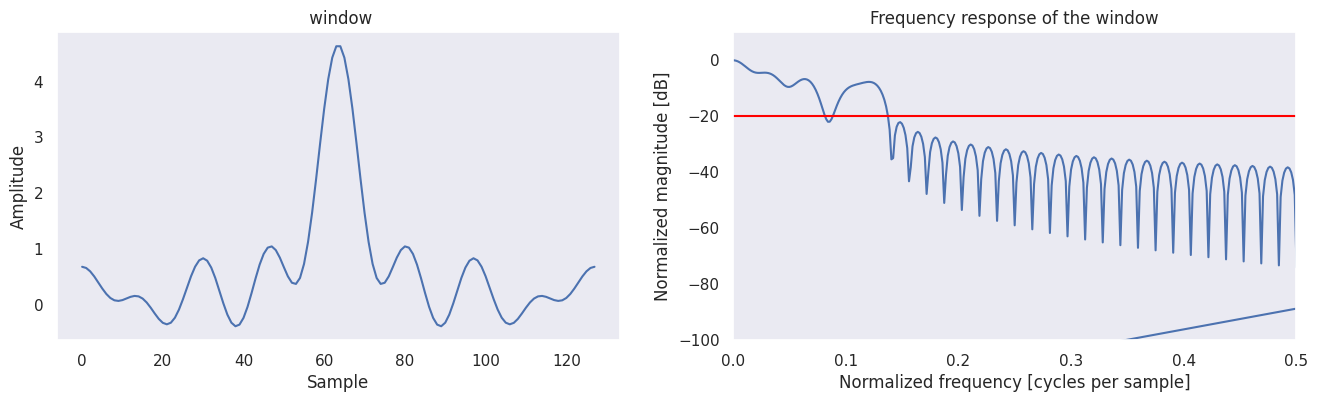

In [86]:
filtviz2.visualize_one_window(n_inp=50, n_out=10)

In [ ]:
n_epoch = 10
n_epoch2 = 50
n_epoch3 = 40
n_epoch4 = 50

optimizer = optim.RAdam(model.parameters(), lr=0.000005)
scheduler = optim.lr_scheduler.OneCycleLR(
    optimizer, max_lr=0.01, pct_start=0.3,
    steps_per_epoch=len(train_loader), epochs=n_epoch4)
log_interval = 40
pbar_update = 1 / (len(train_loader) + len(test_loader))
model.to(device)
with tqdm(total=n_epoch4) as pbar:
    for epoch in range(1+n_epoch+n_epoch2+n_epoch3, n_epoch4+n_epoch3+n_epoch2 + n_epoch + 1):
        train(model, epoch, log_interval, train_losses)
        acc = test(model, epoch)
        test_accuracy += [acc]
        if acc > best_accuracy:
            best_accuracy = acc
            best_epoch = epoch
            bmodel_path = f'{model_path_prefix}{epoch}epoch.pt'
            torch.save(model.state_dict(), bmodel_path)
            print(f'saved model: {bmodel_path}')
        scheduler.step()

In [ ]:
plt.plot(train_losses)

In [ ]:
plt.plot(test_accuracy)

In [44]:
checkpoint_path = '../models_cremad4/cremad4_m13ser_150epoch.ckpt'
torch.save({
    'epoch': epoch,
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'loss': train_losses[-1],
    'best_epoch': best_epoch,
    'best_accuracy': best_accuracy,
    'train_losses': train_losses,
    'test_accuracy': test_accuracy,
    'log_interval': log_interval,
    }, checkpoint_path)